In [2]:
!export CUDA_VISIBLE_DEVICES=0

In [3]:
import os, torch
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
print("CUDA_VISIBLE_DEVICES:", os.environ.get("CUDA_VISIBLE_DEVICES"))
print("Built with CUDA:", torch.version.cuda)     
print("CUDA available?:", torch.cuda.is_available())  
print("Device count:", torch.cuda.device_count())

CUDA_VISIBLE_DEVICES: 0
Built with CUDA: 12.4
CUDA available?: True
Device count: 1


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn
from torch.utils.data import random_split
from semisupervised import SemiSupervisedAutoEncoderOptions, SemiSupervisedAdversarialAutoencoder

## OG Setup

In [4]:
def configure_mnist(batch_size=100, val_size=10000):
    # transform: ToTensor + flatten
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.view(-1))
    ])

    # full train + test datasets
    full_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_ds    = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    # split full_train → train_ds (60k - val_size) and val_ds (val_size)
    print(len(full_train))
    train_size = len(full_train) - val_size
    train_ds, val_ds = random_split(full_train, [train_size, val_size], generator=torch.Generator().manual_seed(42))

    # DataLoaders
    train_loader = DataLoader(train_ds,  batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

    # (Optionally) extract raw tensors:
    X_train = torch.stack([x for x, _ in train_ds])
    Y_train = torch.tensor([y for _, y in train_ds])
    X_val   = torch.stack([x for x, _ in val_ds])
    Y_val   = torch.tensor([y for _, y in val_ds])
    X_test  = torch.stack([x for x, _ in test_ds])
    Y_test  = test_ds.targets.clone()

    return (X_train, X_val, X_test,
            Y_train, Y_val, Y_test,
            train_loader, val_loader, test_loader)

In [5]:
(X_train, X_val, X_test, Y_train, Y_val, Y_test, train_loader, val_loader, test_loader) = configure_mnist()

print(Y_train.max())
print(Y_train.min())

60000
tensor(9)
tensor(0)


In [5]:
NUM_EPOCHS = 50
GAUSSIAN_NOISE = True
INPUT_DIM = 784
BATCH_SIZE = 100
AE_HIDDEN = 1000
DC_HIDDEN = 1000
LATENT_DIM_CAT = 10
LATENT_DIM_STYLE = 10
PRIOR_STD = 1.0
RESULT_FOLDER = 'semisupervised_results/50_momentum_noise_fixed'
NUM_LABELED = 1000

recon_loss = nn.MSELoss()
# init_recon_lr = 0.001 #0.01
init_recon_lr = 0.01

semi_sup_loss = nn.CrossEntropyLoss()
# init_semi_sup_lr = 0.001 #0.1
init_semi_sup_lr = 0.1

# init_gen_lr = init_disc_lr = 0.001 #0.1
init_gen_lr = init_disc_lr = 0.1
use_decoder_sigmoid = True

In [6]:
options = SemiSupervisedAutoEncoderOptions(
    input_dim=INPUT_DIM,
    ae_hidden_dim=AE_HIDDEN,
    disc_hidden_dim=DC_HIDDEN,
    latent_dim_categorical=LATENT_DIM_CAT,
    latent_dim_style=LATENT_DIM_STYLE,
    recon_loss_fn=recon_loss,
    init_recon_lr=init_recon_lr,
    semi_supervised_loss_fn=semi_sup_loss,
    init_semi_sup_lr=init_semi_sup_lr,
    init_gen_lr=init_gen_lr,
    use_decoder_sigmoid=use_decoder_sigmoid,
    init_disc_categorical_lr = init_disc_lr,
    init_disc_style_lr = init_disc_lr
)

model = SemiSupervisedAdversarialAutoencoder(options);

In [ ]:
model.train_mbgd(
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=NUM_EPOCHS,
    prior_std=PRIOR_STD,
    result_folder=RESULT_FOLDER,
    add_gaussian_noise=GAUSSIAN_NOISE
)

## Fixed Experiment

In [5]:
NUM_EPOCHS = 1000
GAUSSIAN_NOISE = True
INPUT_DIM = 784
BATCH_SIZE = 100
AE_HIDDEN = 1000
DC_HIDDEN = 1000
LATENT_DIM_CAT = 10
LATENT_DIM_STYLE = 10
PRIOR_STD = 1.0
RESULT_FOLDER = 'semisupervised_results/1000_epochs_adam_1000_samples'
NUM_LABELED = 1000

recon_loss = nn.MSELoss()
init_recon_lr = 0.001 #0.01
# init_recon_lr = 0.01

semi_sup_loss = nn.CrossEntropyLoss()
init_semi_sup_lr = 0.01 #0.1
# init_semi_sup_lr = 0.1

init_gen_lr = init_disc_lr = 0.001 #0.1
# init_gen_lr = init_disc_lr = 0.1
use_decoder_sigmoid = False

In [6]:
from torch.utils.data import DataLoader, Subset, random_split, Dataset
from torchvision import datasets, transforms
import torch, numpy as np


class UnlabeledWrapper(Dataset):
    """Return images only; label is always -1."""
    def __init__(self, base_ds, indices):
        self.base_ds = base_ds
        self.indices = indices
    def __len__(self):
        return len(self.indices)
    def __getitem__(self, i):
        x, _ = self.base_ds[self.indices[i]]
        return x, -1


def configure_mnist(batch_size=100, n_labeled=1000, val_fraction=0.10, seed=42):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.view(-1))          # flatten to 784
    ])

    full_train = datasets.MNIST(root='./data', train=True,  download=True, transform=transform)
    test_ds    = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    rng = np.random.RandomState(seed)
    all_idx       = np.arange(len(full_train))                       # 60 000 indices
    labeled_idx   = rng.choice(all_idx, size=n_labeled, replace=False)
    remaining_idx = np.setdiff1d(all_idx, labeled_idx)

    n_val   = int(len(remaining_idx) * val_fraction)
    val_idx = rng.choice(remaining_idx, size=n_val, replace=False)
    unlabeled_idx = np.setdiff1d(remaining_idx, val_idx)

    labeled_ds     = Subset(full_train, labeled_idx)                 # (x, y)
    val_ds         = Subset(full_train, val_idx)                     # (x, y)
    unlabeled_ds   = UnlabeledWrapper(full_train, unlabeled_idx)     # (x, -1)

    train_labeled_loader   = DataLoader(labeled_ds,   batch_size=batch_size, shuffle=True,  drop_last=True)
    train_unlabeled_loader = DataLoader(unlabeled_ds, batch_size=batch_size, shuffle=True,  drop_last=True)
    val_loader             = DataLoader(val_ds,       batch_size=batch_size, shuffle=False)
    test_loader            = DataLoader(test_ds,      batch_size=batch_size, shuffle=False)

    X_lab = torch.stack([x for x, _ in labeled_ds])
    Y_lab = torch.tensor([y for _, y in labeled_ds])

    X_val = torch.stack([x for x, _ in val_ds])
    Y_val = torch.tensor([y for _, y in val_ds])

    X_test = torch.stack([x for x, _ in test_ds])
    Y_test = test_ds.targets.clone()

    return (X_lab, X_val, X_test,
            Y_lab, Y_val, Y_test,
            train_labeled_loader, train_unlabeled_loader, val_loader, test_loader)

In [7]:
(X_lab, X_val, X_test,
 Y_lab, Y_val, Y_test,
 train_labeled_loader,
 train_unlabeled_loader,
 val_loader,
 test_loader) = configure_mnist(batch_size=BATCH_SIZE, n_labeled=NUM_LABELED)

print("labelled   :", len(train_labeled_loader.dataset))   # 1 000
print("unlabelled :", len(train_unlabeled_loader.dataset)) # ≈53 000
print("val        :", len(val_loader.dataset))             # ≈6 000
print(Y_lab.max(), Y_lab.min())      

labelled   : 1000
unlabelled : 53100
val        : 5900
tensor(9) tensor(0)


In [8]:
options = SemiSupervisedAutoEncoderOptions(
    input_dim=INPUT_DIM,
    ae_hidden_dim=AE_HIDDEN,
    disc_hidden_dim=DC_HIDDEN,
    latent_dim_categorical=LATENT_DIM_CAT,
    latent_dim_style=LATENT_DIM_STYLE,
    recon_loss_fn=recon_loss,
    init_recon_lr=init_recon_lr,
    semi_supervised_loss_fn=semi_sup_loss,
    init_semi_sup_lr=init_semi_sup_lr,
    init_gen_lr=init_gen_lr,
    use_decoder_sigmoid=use_decoder_sigmoid,
    init_disc_categorical_lr = init_disc_lr,
    init_disc_style_lr = init_disc_lr
)

model = SemiSupervisedAdversarialAutoencoder(options);

In [9]:
model.train_mbgd_2(
    val_loader=val_loader,
    epochs=NUM_EPOCHS,
    prior_std=PRIOR_STD,
    result_folder=RESULT_FOLDER,
    add_gaussian_noise=GAUSSIAN_NOISE,
    train_labeled_loader=train_labeled_loader,
    train_unlabeled_loader=train_unlabeled_loader
)

Epoch [1/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/1000 — Recon_U: 0.0953, Recon_L: 0.0938, SemiSup: 1.9864, Disc_Cat: 1.3447, Gen_Cat: 0.6743, Disc_Sty: 1.2381, Gen_Sty: 0.6962
Validation Accuracy: 62.22%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [2/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2/1000 — Recon_U: 0.0695, Recon_L: 0.0695, SemiSup: 0.9257, Disc_Cat: 1.2683, Gen_Cat: 0.6637, Disc_Sty: 0.7936, Gen_Sty: 0.8610
Validation Accuracy: 81.07%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [3/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3/1000 — Recon_U: 0.0682, Recon_L: 0.0671, SemiSup: 0.5407, Disc_Cat: 1.1787, Gen_Cat: 0.7964, Disc_Sty: 1.0037, Gen_Sty: 1.1114
Validation Accuracy: 86.63%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [4/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4/1000 — Recon_U: 0.0658, Recon_L: 0.0647, SemiSup: 0.4641, Disc_Cat: 1.2215, Gen_Cat: 0.9231, Disc_Sty: 2.1783, Gen_Sty: 2.7870
Validation Accuracy: 87.41%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [5/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 5/1000 — Recon_U: 0.0609, Recon_L: 0.0613, SemiSup: 0.3796, Disc_Cat: 1.1324, Gen_Cat: 1.1512, Disc_Sty: 1.6679, Gen_Sty: 3.0731
Validation Accuracy: 87.69%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [6/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 6/1000 — Recon_U: 0.0586, Recon_L: 0.0578, SemiSup: 0.3341, Disc_Cat: 1.1856, Gen_Cat: 1.2304, Disc_Sty: 1.3440, Gen_Sty: 6.7432
Validation Accuracy: 88.66%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [7/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 7/1000 — Recon_U: 0.0549, Recon_L: 0.0553, SemiSup: 0.2607, Disc_Cat: 1.1949, Gen_Cat: 1.2953, Disc_Sty: 1.1258, Gen_Sty: 4.3700
Validation Accuracy: 90.27%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [8/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 8/1000 — Recon_U: 0.0526, Recon_L: 0.0535, SemiSup: 0.2656, Disc_Cat: 1.2242, Gen_Cat: 1.2209, Disc_Sty: 1.1736, Gen_Sty: 3.4264
Validation Accuracy: 89.20%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [9/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 9/1000 — Recon_U: 0.0535, Recon_L: 0.0532, SemiSup: 0.2729, Disc_Cat: 1.1994, Gen_Cat: 1.2408, Disc_Sty: 1.3928, Gen_Sty: 3.0116
Validation Accuracy: 88.20%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [10/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10/1000 — Recon_U: 0.0521, Recon_L: 0.0520, SemiSup: 0.1862, Disc_Cat: 1.2193, Gen_Cat: 1.2437, Disc_Sty: 1.0047, Gen_Sty: 2.5400
Validation Accuracy: 89.59%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [11/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 11/1000 — Recon_U: 0.0509, Recon_L: 0.0509, SemiSup: 0.2263, Disc_Cat: 1.2397, Gen_Cat: 1.1595, Disc_Sty: 0.5685, Gen_Sty: 3.1113
Validation Accuracy: 88.85%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [12/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 12/1000 — Recon_U: 0.0506, Recon_L: 0.0498, SemiSup: 0.1641, Disc_Cat: 1.1809, Gen_Cat: 1.2624, Disc_Sty: 0.6230, Gen_Sty: 3.3838
Validation Accuracy: 89.86%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [13/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 13/1000 — Recon_U: 0.0492, Recon_L: 0.0490, SemiSup: 0.2284, Disc_Cat: 1.2202, Gen_Cat: 1.2240, Disc_Sty: 1.3788, Gen_Sty: 2.5289
Validation Accuracy: 90.39%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [14/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 14/1000 — Recon_U: 0.0483, Recon_L: 0.0487, SemiSup: 0.2289, Disc_Cat: 1.2372, Gen_Cat: 1.1802, Disc_Sty: 1.8298, Gen_Sty: 2.4763
Validation Accuracy: 88.15%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [15/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 15/1000 — Recon_U: 0.0497, Recon_L: 0.0488, SemiSup: 0.2818, Disc_Cat: 1.2793, Gen_Cat: 1.2006, Disc_Sty: 1.5786, Gen_Sty: 2.5194
Validation Accuracy: 87.64%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [16/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 16/1000 — Recon_U: 0.0486, Recon_L: 0.0481, SemiSup: 0.1791, Disc_Cat: 1.2507, Gen_Cat: 1.2025, Disc_Sty: 1.3153, Gen_Sty: 1.9942
Validation Accuracy: 89.69%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [17/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 17/1000 — Recon_U: 0.0470, Recon_L: 0.0464, SemiSup: 0.1598, Disc_Cat: 1.2695, Gen_Cat: 1.1193, Disc_Sty: 0.9794, Gen_Sty: 1.6314
Validation Accuracy: 90.97%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [18/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 18/1000 — Recon_U: 0.0455, Recon_L: 0.0454, SemiSup: 0.1511, Disc_Cat: 1.2537, Gen_Cat: 1.0890, Disc_Sty: 0.8490, Gen_Sty: 1.7490
Validation Accuracy: 90.00%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [19/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 19/1000 — Recon_U: 0.0442, Recon_L: 0.0440, SemiSup: 0.1217, Disc_Cat: 1.2547, Gen_Cat: 1.0940, Disc_Sty: 0.8303, Gen_Sty: 1.6751
Validation Accuracy: 90.08%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [20/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 20/1000 — Recon_U: 0.0445, Recon_L: 0.0430, SemiSup: 0.0924, Disc_Cat: 1.2531, Gen_Cat: 1.0815, Disc_Sty: 0.7793, Gen_Sty: 1.9035
Validation Accuracy: 90.39%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [21/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 21/1000 — Recon_U: 0.0428, Recon_L: 0.0424, SemiSup: 0.1444, Disc_Cat: 1.2865, Gen_Cat: 1.0334, Disc_Sty: 1.6816, Gen_Sty: 1.4336
Validation Accuracy: 90.41%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [22/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 22/1000 — Recon_U: 0.0424, Recon_L: 0.0417, SemiSup: 0.1418, Disc_Cat: 1.2869, Gen_Cat: 1.0367, Disc_Sty: 1.6577, Gen_Sty: 3.2745
Validation Accuracy: 89.10%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [23/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 23/1000 — Recon_U: 0.0417, Recon_L: 0.0413, SemiSup: 0.1554, Disc_Cat: 1.2714, Gen_Cat: 1.0253, Disc_Sty: 1.8798, Gen_Sty: 1.5799
Validation Accuracy: 89.46%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [24/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 24/1000 — Recon_U: 0.0419, Recon_L: 0.0411, SemiSup: 0.1968, Disc_Cat: 1.2822, Gen_Cat: 1.0640, Disc_Sty: 1.3710, Gen_Sty: 1.0762
Validation Accuracy: 90.95%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [25/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 25/1000 — Recon_U: 0.0422, Recon_L: 0.0410, SemiSup: 0.1326, Disc_Cat: 1.2816, Gen_Cat: 1.0319, Disc_Sty: 1.0858, Gen_Sty: 1.4889
Validation Accuracy: 88.86%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [26/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 26/1000 — Recon_U: 0.0402, Recon_L: 0.0401, SemiSup: 0.2010, Disc_Cat: 1.2828, Gen_Cat: 1.0754, Disc_Sty: 1.1993, Gen_Sty: 1.4635
Validation Accuracy: 91.02%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [27/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 27/1000 — Recon_U: 0.0405, Recon_L: 0.0395, SemiSup: 0.0952, Disc_Cat: 1.2797, Gen_Cat: 1.0261, Disc_Sty: 1.6564, Gen_Sty: 1.0337
Validation Accuracy: 91.54%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [28/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 28/1000 — Recon_U: 0.0392, Recon_L: 0.0386, SemiSup: 0.1364, Disc_Cat: 1.2757, Gen_Cat: 1.0323, Disc_Sty: 1.5798, Gen_Sty: 1.1111
Validation Accuracy: 89.90%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [29/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 29/1000 — Recon_U: 0.0379, Recon_L: 0.0379, SemiSup: 0.1334, Disc_Cat: 1.3100, Gen_Cat: 1.0116, Disc_Sty: 1.4390, Gen_Sty: 0.6931
Validation Accuracy: 89.81%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [30/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 30/1000 — Recon_U: 0.0374, Recon_L: 0.0372, SemiSup: 0.1018, Disc_Cat: 1.3013, Gen_Cat: 0.9845, Disc_Sty: 1.3332, Gen_Sty: 0.6340
Validation Accuracy: 90.93%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [31/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 31/1000 — Recon_U: 0.0375, Recon_L: 0.0366, SemiSup: 0.0598, Disc_Cat: 1.2898, Gen_Cat: 0.9773, Disc_Sty: 1.3556, Gen_Sty: 0.6449
Validation Accuracy: 91.14%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [32/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 32/1000 — Recon_U: 0.0375, Recon_L: 0.0360, SemiSup: 0.1141, Disc_Cat: 1.3066, Gen_Cat: 0.9176, Disc_Sty: 1.1963, Gen_Sty: 0.9266
Validation Accuracy: 90.32%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [33/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 33/1000 — Recon_U: 0.0367, Recon_L: 0.0355, SemiSup: 0.1287, Disc_Cat: 1.2974, Gen_Cat: 0.9654, Disc_Sty: 1.1477, Gen_Sty: 1.1286
Validation Accuracy: 91.02%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [34/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 34/1000 — Recon_U: 0.0365, Recon_L: 0.0357, SemiSup: 0.1306, Disc_Cat: 1.3066, Gen_Cat: 0.9200, Disc_Sty: 1.3428, Gen_Sty: 0.8973
Validation Accuracy: 90.29%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [35/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 35/1000 — Recon_U: 0.0363, Recon_L: 0.0357, SemiSup: 0.1661, Disc_Cat: 1.2833, Gen_Cat: 0.9852, Disc_Sty: 1.6369, Gen_Sty: 0.8609
Validation Accuracy: 90.69%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [36/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 36/1000 — Recon_U: 0.0359, Recon_L: 0.0352, SemiSup: 0.1501, Disc_Cat: 1.3101, Gen_Cat: 0.9531, Disc_Sty: 1.2958, Gen_Sty: 1.6186
Validation Accuracy: 89.66%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [37/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 37/1000 — Recon_U: 0.0366, Recon_L: 0.0348, SemiSup: 0.1245, Disc_Cat: 1.3097, Gen_Cat: 0.9472, Disc_Sty: 1.2925, Gen_Sty: 1.0476
Validation Accuracy: 89.76%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [38/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 38/1000 — Recon_U: 0.0366, Recon_L: 0.0349, SemiSup: 0.1634, Disc_Cat: 1.3318, Gen_Cat: 0.9643, Disc_Sty: 1.1733, Gen_Sty: 1.4048
Validation Accuracy: 89.71%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [39/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 39/1000 — Recon_U: 0.0365, Recon_L: 0.0348, SemiSup: 0.0826, Disc_Cat: 1.3106, Gen_Cat: 0.9498, Disc_Sty: 1.5771, Gen_Sty: 0.7977
Validation Accuracy: 91.19%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [40/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 40/1000 — Recon_U: 0.0361, Recon_L: 0.0346, SemiSup: 0.1720, Disc_Cat: 1.3199, Gen_Cat: 0.9169, Disc_Sty: 1.4882, Gen_Sty: 1.1025
Validation Accuracy: 90.17%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [41/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 41/1000 — Recon_U: 0.0363, Recon_L: 0.0343, SemiSup: 0.1233, Disc_Cat: 1.3165, Gen_Cat: 0.8930, Disc_Sty: 1.2603, Gen_Sty: 1.7533
Validation Accuracy: 90.66%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [42/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 42/1000 — Recon_U: 0.0351, Recon_L: 0.0342, SemiSup: 0.0940, Disc_Cat: 1.2908, Gen_Cat: 0.9204, Disc_Sty: 1.4470, Gen_Sty: 0.9489
Validation Accuracy: 90.47%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [43/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 43/1000 — Recon_U: 0.0363, Recon_L: 0.0342, SemiSup: 0.1416, Disc_Cat: 1.3040, Gen_Cat: 0.9839, Disc_Sty: 1.4516, Gen_Sty: 0.7315
Validation Accuracy: 90.97%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [44/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 44/1000 — Recon_U: 0.0358, Recon_L: 0.0336, SemiSup: 0.1234, Disc_Cat: 1.3089, Gen_Cat: 0.9363, Disc_Sty: 1.3411, Gen_Sty: 0.8137
Validation Accuracy: 90.95%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [45/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 45/1000 — Recon_U: 0.0358, Recon_L: 0.0330, SemiSup: 0.1360, Disc_Cat: 1.3281, Gen_Cat: 0.9547, Disc_Sty: 1.2842, Gen_Sty: 0.9482
Validation Accuracy: 90.39%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [46/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 46/1000 — Recon_U: 0.0352, Recon_L: 0.0329, SemiSup: 0.1076, Disc_Cat: 1.2867, Gen_Cat: 0.9785, Disc_Sty: 1.3053, Gen_Sty: 0.9837
Validation Accuracy: 91.58%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [47/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 47/1000 — Recon_U: 0.0346, Recon_L: 0.0325, SemiSup: 0.0699, Disc_Cat: 1.2947, Gen_Cat: 0.9340, Disc_Sty: 1.3515, Gen_Sty: 0.9085
Validation Accuracy: 91.02%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [48/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 48/1000 — Recon_U: 0.0343, Recon_L: 0.0323, SemiSup: 0.0800, Disc_Cat: 1.3098, Gen_Cat: 0.9344, Disc_Sty: 1.3441, Gen_Sty: 0.8316
Validation Accuracy: 90.64%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [49/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 49/1000 — Recon_U: 0.0344, Recon_L: 0.0325, SemiSup: 0.0724, Disc_Cat: 1.3175, Gen_Cat: 0.9066, Disc_Sty: 1.2974, Gen_Sty: 0.8513
Validation Accuracy: 91.19%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [50/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 50/1000 — Recon_U: 0.0348, Recon_L: 0.0324, SemiSup: 0.1094, Disc_Cat: 1.3189, Gen_Cat: 0.9027, Disc_Sty: 1.2794, Gen_Sty: 0.8418
Validation Accuracy: 91.75%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_epoch_50/weights_*.pth
Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [51/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 51/1000 — Recon_U: 0.0337, Recon_L: 0.0315, SemiSup: 0.0805, Disc_Cat: 1.3327, Gen_Cat: 0.8795, Disc_Sty: 1.2908, Gen_Sty: 0.8410
Validation Accuracy: 91.75%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [52/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 52/1000 — Recon_U: 0.0337, Recon_L: 0.0309, SemiSup: 0.0354, Disc_Cat: 1.3043, Gen_Cat: 0.8850, Disc_Sty: 1.2955, Gen_Sty: 0.8221
Validation Accuracy: 91.75%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [53/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 53/1000 — Recon_U: 0.0334, Recon_L: 0.0307, SemiSup: 0.0623, Disc_Cat: 1.3045, Gen_Cat: 0.8758, Disc_Sty: 1.3003, Gen_Sty: 0.8321
Validation Accuracy: 91.80%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [54/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 54/1000 — Recon_U: 0.0333, Recon_L: 0.0305, SemiSup: 0.0524, Disc_Cat: 1.3003, Gen_Cat: 0.8955, Disc_Sty: 1.3050, Gen_Sty: 0.8323
Validation Accuracy: 91.88%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [55/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 55/1000 — Recon_U: 0.0334, Recon_L: 0.0304, SemiSup: 0.0505, Disc_Cat: 1.2904, Gen_Cat: 0.9086, Disc_Sty: 1.2988, Gen_Sty: 0.8268
Validation Accuracy: 91.98%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [56/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 56/1000 — Recon_U: 0.0328, Recon_L: 0.0302, SemiSup: 0.0847, Disc_Cat: 1.3131, Gen_Cat: 0.8674, Disc_Sty: 1.3108, Gen_Sty: 0.8335
Validation Accuracy: 92.14%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [57/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 57/1000 — Recon_U: 0.0335, Recon_L: 0.0304, SemiSup: 0.0367, Disc_Cat: 1.2923, Gen_Cat: 0.9310, Disc_Sty: 1.3235, Gen_Sty: 0.8297
Validation Accuracy: 92.15%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [58/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 58/1000 — Recon_U: 0.0319, Recon_L: 0.0302, SemiSup: 0.0392, Disc_Cat: 1.3130, Gen_Cat: 0.8367, Disc_Sty: 1.3130, Gen_Sty: 0.8442
Validation Accuracy: 92.10%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [59/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 59/1000 — Recon_U: 0.0328, Recon_L: 0.0302, SemiSup: 0.0457, Disc_Cat: 1.3014, Gen_Cat: 0.9057, Disc_Sty: 1.3096, Gen_Sty: 0.8514
Validation Accuracy: 92.15%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [60/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 60/1000 — Recon_U: 0.0325, Recon_L: 0.0300, SemiSup: 0.0302, Disc_Cat: 1.3021, Gen_Cat: 0.8923, Disc_Sty: 1.3124, Gen_Sty: 0.8616
Validation Accuracy: 92.19%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [61/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 61/1000 — Recon_U: 0.0319, Recon_L: 0.0300, SemiSup: 0.0457, Disc_Cat: 1.3126, Gen_Cat: 0.8748, Disc_Sty: 1.3006, Gen_Sty: 0.8884
Validation Accuracy: 92.17%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [62/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 62/1000 — Recon_U: 0.0326, Recon_L: 0.0299, SemiSup: 0.0564, Disc_Cat: 1.3187, Gen_Cat: 0.8548, Disc_Sty: 1.3098, Gen_Sty: 0.8978
Validation Accuracy: 92.22%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [63/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 63/1000 — Recon_U: 0.0323, Recon_L: 0.0300, SemiSup: 0.0423, Disc_Cat: 1.2982, Gen_Cat: 0.9053, Disc_Sty: 1.2913, Gen_Sty: 0.9183
Validation Accuracy: 92.24%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [64/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 64/1000 — Recon_U: 0.0320, Recon_L: 0.0297, SemiSup: 0.0338, Disc_Cat: 1.3075, Gen_Cat: 0.8785, Disc_Sty: 1.2977, Gen_Sty: 0.9300
Validation Accuracy: 92.27%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [65/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 65/1000 — Recon_U: 0.0332, Recon_L: 0.0298, SemiSup: 0.0467, Disc_Cat: 1.3064, Gen_Cat: 0.9036, Disc_Sty: 1.2847, Gen_Sty: 0.9605
Validation Accuracy: 92.22%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [66/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 66/1000 — Recon_U: 0.0322, Recon_L: 0.0298, SemiSup: 0.0373, Disc_Cat: 1.3015, Gen_Cat: 0.8883, Disc_Sty: 1.2887, Gen_Sty: 0.9726
Validation Accuracy: 92.24%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [67/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 67/1000 — Recon_U: 0.0320, Recon_L: 0.0298, SemiSup: 0.0392, Disc_Cat: 1.3060, Gen_Cat: 0.9105, Disc_Sty: 1.2854, Gen_Sty: 1.0034
Validation Accuracy: 92.24%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [68/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 68/1000 — Recon_U: 0.0322, Recon_L: 0.0297, SemiSup: 0.0225, Disc_Cat: 1.3101, Gen_Cat: 0.8960, Disc_Sty: 1.2718, Gen_Sty: 0.9909
Validation Accuracy: 92.31%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [69/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 69/1000 — Recon_U: 0.0323, Recon_L: 0.0297, SemiSup: 0.0354, Disc_Cat: 1.3092, Gen_Cat: 0.8776, Disc_Sty: 1.2692, Gen_Sty: 0.9935
Validation Accuracy: 92.27%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [70/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 70/1000 — Recon_U: 0.0326, Recon_L: 0.0296, SemiSup: 0.0267, Disc_Cat: 1.3052, Gen_Cat: 0.8911, Disc_Sty: 1.2788, Gen_Sty: 0.9872
Validation Accuracy: 92.31%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [71/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 71/1000 — Recon_U: 0.0317, Recon_L: 0.0295, SemiSup: 0.0393, Disc_Cat: 1.3113, Gen_Cat: 0.8884, Disc_Sty: 1.2874, Gen_Sty: 0.9797
Validation Accuracy: 92.25%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [72/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 72/1000 — Recon_U: 0.0318, Recon_L: 0.0296, SemiSup: 0.0399, Disc_Cat: 1.3114, Gen_Cat: 0.9066, Disc_Sty: 1.2961, Gen_Sty: 0.9683
Validation Accuracy: 92.29%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [73/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 73/1000 — Recon_U: 0.0326, Recon_L: 0.0295, SemiSup: 0.0278, Disc_Cat: 1.3070, Gen_Cat: 0.9009, Disc_Sty: 1.2864, Gen_Sty: 0.9479
Validation Accuracy: 92.27%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [74/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 74/1000 — Recon_U: 0.0318, Recon_L: 0.0295, SemiSup: 0.0282, Disc_Cat: 1.3222, Gen_Cat: 0.8530, Disc_Sty: 1.2931, Gen_Sty: 0.9490
Validation Accuracy: 92.31%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [75/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 75/1000 — Recon_U: 0.0324, Recon_L: 0.0294, SemiSup: 0.0300, Disc_Cat: 1.3098, Gen_Cat: 0.8757, Disc_Sty: 1.3122, Gen_Sty: 0.9085
Validation Accuracy: 92.34%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [76/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 76/1000 — Recon_U: 0.0317, Recon_L: 0.0293, SemiSup: 0.0204, Disc_Cat: 1.3052, Gen_Cat: 0.8825, Disc_Sty: 1.3284, Gen_Sty: 0.8823
Validation Accuracy: 92.29%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [77/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 77/1000 — Recon_U: 0.0323, Recon_L: 0.0294, SemiSup: 0.0557, Disc_Cat: 1.3030, Gen_Cat: 0.9135, Disc_Sty: 1.3443, Gen_Sty: 0.8456
Validation Accuracy: 92.25%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [78/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 78/1000 — Recon_U: 0.0325, Recon_L: 0.0294, SemiSup: 0.0256, Disc_Cat: 1.2984, Gen_Cat: 0.9171, Disc_Sty: 1.3264, Gen_Sty: 0.8544
Validation Accuracy: 92.41%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [79/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 79/1000 — Recon_U: 0.0312, Recon_L: 0.0293, SemiSup: 0.0355, Disc_Cat: 1.3074, Gen_Cat: 0.9139, Disc_Sty: 1.3327, Gen_Sty: 0.8404
Validation Accuracy: 92.41%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [80/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 80/1000 — Recon_U: 0.0322, Recon_L: 0.0294, SemiSup: 0.0582, Disc_Cat: 1.3129, Gen_Cat: 0.8917, Disc_Sty: 1.3344, Gen_Sty: 0.8375
Validation Accuracy: 92.44%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [81/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 81/1000 — Recon_U: 0.0319, Recon_L: 0.0293, SemiSup: 0.0314, Disc_Cat: 1.3067, Gen_Cat: 0.9084, Disc_Sty: 1.3354, Gen_Sty: 0.8196
Validation Accuracy: 92.41%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [82/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 82/1000 — Recon_U: 0.0311, Recon_L: 0.0293, SemiSup: 0.0245, Disc_Cat: 1.3051, Gen_Cat: 0.9064, Disc_Sty: 1.3337, Gen_Sty: 0.8049
Validation Accuracy: 92.39%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [83/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 83/1000 — Recon_U: 0.0311, Recon_L: 0.0293, SemiSup: 0.0340, Disc_Cat: 1.3075, Gen_Cat: 0.9047, Disc_Sty: 1.3299, Gen_Sty: 0.8139
Validation Accuracy: 92.46%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [84/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 84/1000 — Recon_U: 0.0318, Recon_L: 0.0292, SemiSup: 0.0341, Disc_Cat: 1.3066, Gen_Cat: 0.8986, Disc_Sty: 1.3320, Gen_Sty: 0.8116
Validation Accuracy: 92.49%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [85/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 85/1000 — Recon_U: 0.0323, Recon_L: 0.0291, SemiSup: 0.0165, Disc_Cat: 1.3101, Gen_Cat: 0.9048, Disc_Sty: 1.3371, Gen_Sty: 0.8110
Validation Accuracy: 92.49%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [86/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 86/1000 — Recon_U: 0.0318, Recon_L: 0.0291, SemiSup: 0.0265, Disc_Cat: 1.3158, Gen_Cat: 0.8844, Disc_Sty: 1.3192, Gen_Sty: 0.8143
Validation Accuracy: 92.49%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [87/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 87/1000 — Recon_U: 0.0315, Recon_L: 0.0291, SemiSup: 0.0326, Disc_Cat: 1.3091, Gen_Cat: 0.9037, Disc_Sty: 1.3312, Gen_Sty: 0.8191
Validation Accuracy: 92.51%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [88/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 88/1000 — Recon_U: 0.0314, Recon_L: 0.0291, SemiSup: 0.0230, Disc_Cat: 1.3062, Gen_Cat: 0.9119, Disc_Sty: 1.3227, Gen_Sty: 0.8224
Validation Accuracy: 92.46%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [89/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 89/1000 — Recon_U: 0.0311, Recon_L: 0.0291, SemiSup: 0.0520, Disc_Cat: 1.3037, Gen_Cat: 0.9294, Disc_Sty: 1.3254, Gen_Sty: 0.8085
Validation Accuracy: 92.44%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [90/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 90/1000 — Recon_U: 0.0317, Recon_L: 0.0290, SemiSup: 0.0246, Disc_Cat: 1.3044, Gen_Cat: 0.8946, Disc_Sty: 1.3298, Gen_Sty: 0.8164
Validation Accuracy: 92.53%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [91/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 91/1000 — Recon_U: 0.0319, Recon_L: 0.0290, SemiSup: 0.0199, Disc_Cat: 1.3193, Gen_Cat: 0.9054, Disc_Sty: 1.3212, Gen_Sty: 0.8237
Validation Accuracy: 92.51%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [92/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 92/1000 — Recon_U: 0.0319, Recon_L: 0.0288, SemiSup: 0.0220, Disc_Cat: 1.3118, Gen_Cat: 0.9237, Disc_Sty: 1.3403, Gen_Sty: 0.8106
Validation Accuracy: 92.47%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [93/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 93/1000 — Recon_U: 0.0316, Recon_L: 0.0288, SemiSup: 0.0572, Disc_Cat: 1.3027, Gen_Cat: 0.9159, Disc_Sty: 1.3393, Gen_Sty: 0.7951
Validation Accuracy: 92.42%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [94/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 94/1000 — Recon_U: 0.0318, Recon_L: 0.0288, SemiSup: 0.0306, Disc_Cat: 1.3293, Gen_Cat: 0.8549, Disc_Sty: 1.3369, Gen_Sty: 0.8023
Validation Accuracy: 92.54%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [95/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 95/1000 — Recon_U: 0.0308, Recon_L: 0.0288, SemiSup: 0.0215, Disc_Cat: 1.3153, Gen_Cat: 0.8717, Disc_Sty: 1.3338, Gen_Sty: 0.8056
Validation Accuracy: 92.58%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [96/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 96/1000 — Recon_U: 0.0320, Recon_L: 0.0288, SemiSup: 0.0284, Disc_Cat: 1.3103, Gen_Cat: 0.9305, Disc_Sty: 1.3465, Gen_Sty: 0.7927
Validation Accuracy: 92.54%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [97/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 97/1000 — Recon_U: 0.0315, Recon_L: 0.0288, SemiSup: 0.0194, Disc_Cat: 1.3154, Gen_Cat: 0.9094, Disc_Sty: 1.3329, Gen_Sty: 0.7978
Validation Accuracy: 92.58%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [98/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 98/1000 — Recon_U: 0.0322, Recon_L: 0.0287, SemiSup: 0.0246, Disc_Cat: 1.3040, Gen_Cat: 0.9468, Disc_Sty: 1.3365, Gen_Sty: 0.7870
Validation Accuracy: 92.56%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [99/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 99/1000 — Recon_U: 0.0319, Recon_L: 0.0287, SemiSup: 0.0268, Disc_Cat: 1.3133, Gen_Cat: 0.9224, Disc_Sty: 1.3543, Gen_Sty: 0.7832
Validation Accuracy: 92.54%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [100/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 100/1000 — Recon_U: 0.0316, Recon_L: 0.0288, SemiSup: 0.0395, Disc_Cat: 1.3220, Gen_Cat: 0.8827, Disc_Sty: 1.3469, Gen_Sty: 0.7860
Validation Accuracy: 92.44%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_epoch_100/weights_*.pth
Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [101/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 101/1000 — Recon_U: 0.0312, Recon_L: 0.0287, SemiSup: 0.0361, Disc_Cat: 1.3095, Gen_Cat: 0.9528, Disc_Sty: 1.3461, Gen_Sty: 0.7905
Validation Accuracy: 92.54%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [102/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 102/1000 — Recon_U: 0.0317, Recon_L: 0.0286, SemiSup: 0.0356, Disc_Cat: 1.3151, Gen_Cat: 0.8933, Disc_Sty: 1.3540, Gen_Sty: 0.7885
Validation Accuracy: 92.53%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [103/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 103/1000 — Recon_U: 0.0316, Recon_L: 0.0286, SemiSup: 0.0216, Disc_Cat: 1.3164, Gen_Cat: 0.9115, Disc_Sty: 1.3572, Gen_Sty: 0.7870
Validation Accuracy: 92.61%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [104/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 104/1000 — Recon_U: 0.0314, Recon_L: 0.0287, SemiSup: 0.0398, Disc_Cat: 1.3293, Gen_Cat: 0.8724, Disc_Sty: 1.3503, Gen_Sty: 0.7813
Validation Accuracy: 92.56%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [105/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 105/1000 — Recon_U: 0.0319, Recon_L: 0.0286, SemiSup: 0.0209, Disc_Cat: 1.3103, Gen_Cat: 0.9192, Disc_Sty: 1.3593, Gen_Sty: 0.7702
Validation Accuracy: 92.59%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [106/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 106/1000 — Recon_U: 0.0318, Recon_L: 0.0286, SemiSup: 0.0187, Disc_Cat: 1.3070, Gen_Cat: 0.9348, Disc_Sty: 1.3588, Gen_Sty: 0.7804
Validation Accuracy: 92.56%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [107/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 107/1000 — Recon_U: 0.0314, Recon_L: 0.0285, SemiSup: 0.0213, Disc_Cat: 1.3128, Gen_Cat: 0.9213, Disc_Sty: 1.3590, Gen_Sty: 0.7762
Validation Accuracy: 92.59%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [108/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 108/1000 — Recon_U: 0.0321, Recon_L: 0.0285, SemiSup: 0.0114, Disc_Cat: 1.3067, Gen_Cat: 0.9460, Disc_Sty: 1.3712, Gen_Sty: 0.7637
Validation Accuracy: 92.64%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [109/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 109/1000 — Recon_U: 0.0312, Recon_L: 0.0284, SemiSup: 0.0255, Disc_Cat: 1.3098, Gen_Cat: 0.9094, Disc_Sty: 1.3628, Gen_Sty: 0.7677
Validation Accuracy: 92.61%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [110/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 110/1000 — Recon_U: 0.0318, Recon_L: 0.0284, SemiSup: 0.0163, Disc_Cat: 1.3157, Gen_Cat: 0.9222, Disc_Sty: 1.3570, Gen_Sty: 0.7563
Validation Accuracy: 92.58%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [111/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 111/1000 — Recon_U: 0.0307, Recon_L: 0.0284, SemiSup: 0.0208, Disc_Cat: 1.3183, Gen_Cat: 0.8987, Disc_Sty: 1.3664, Gen_Sty: 0.7510
Validation Accuracy: 92.51%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [112/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 112/1000 — Recon_U: 0.0313, Recon_L: 0.0283, SemiSup: 0.0303, Disc_Cat: 1.3187, Gen_Cat: 0.8931, Disc_Sty: 1.3672, Gen_Sty: 0.7472
Validation Accuracy: 92.58%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [113/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 113/1000 — Recon_U: 0.0314, Recon_L: 0.0284, SemiSup: 0.0382, Disc_Cat: 1.3158, Gen_Cat: 0.9151, Disc_Sty: 1.3625, Gen_Sty: 0.7429
Validation Accuracy: 92.47%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [114/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 114/1000 — Recon_U: 0.0308, Recon_L: 0.0283, SemiSup: 0.0322, Disc_Cat: 1.3136, Gen_Cat: 0.9119, Disc_Sty: 1.3561, Gen_Sty: 0.7360
Validation Accuracy: 92.53%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [115/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 115/1000 — Recon_U: 0.0306, Recon_L: 0.0282, SemiSup: 0.0244, Disc_Cat: 1.3257, Gen_Cat: 0.8696, Disc_Sty: 1.3731, Gen_Sty: 0.7341
Validation Accuracy: 92.51%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [116/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 116/1000 — Recon_U: 0.0315, Recon_L: 0.0282, SemiSup: 0.0499, Disc_Cat: 1.3174, Gen_Cat: 0.9169, Disc_Sty: 1.3633, Gen_Sty: 0.7414
Validation Accuracy: 92.39%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [117/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 117/1000 — Recon_U: 0.0303, Recon_L: 0.0281, SemiSup: 0.0296, Disc_Cat: 1.3202, Gen_Cat: 0.9045, Disc_Sty: 1.3692, Gen_Sty: 0.7329
Validation Accuracy: 92.53%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [118/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 118/1000 — Recon_U: 0.0318, Recon_L: 0.0282, SemiSup: 0.0415, Disc_Cat: 1.3070, Gen_Cat: 0.9378, Disc_Sty: 1.3656, Gen_Sty: 0.7260
Validation Accuracy: 92.53%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [119/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 119/1000 — Recon_U: 0.0310, Recon_L: 0.0281, SemiSup: 0.0366, Disc_Cat: 1.3127, Gen_Cat: 0.9224, Disc_Sty: 1.3684, Gen_Sty: 0.7206
Validation Accuracy: 92.46%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [120/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 120/1000 — Recon_U: 0.0309, Recon_L: 0.0281, SemiSup: 0.0196, Disc_Cat: 1.3158, Gen_Cat: 0.9113, Disc_Sty: 1.3748, Gen_Sty: 0.7289
Validation Accuracy: 92.51%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [121/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 121/1000 — Recon_U: 0.0305, Recon_L: 0.0280, SemiSup: 0.0137, Disc_Cat: 1.3129, Gen_Cat: 0.9269, Disc_Sty: 1.3616, Gen_Sty: 0.7214
Validation Accuracy: 92.51%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [122/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 122/1000 — Recon_U: 0.0313, Recon_L: 0.0280, SemiSup: 0.0233, Disc_Cat: 1.3214, Gen_Cat: 0.9056, Disc_Sty: 1.3695, Gen_Sty: 0.7153
Validation Accuracy: 92.47%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [123/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 123/1000 — Recon_U: 0.0312, Recon_L: 0.0280, SemiSup: 0.0287, Disc_Cat: 1.3233, Gen_Cat: 0.9132, Disc_Sty: 1.3784, Gen_Sty: 0.7135
Validation Accuracy: 92.53%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [124/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 124/1000 — Recon_U: 0.0305, Recon_L: 0.0280, SemiSup: 0.0337, Disc_Cat: 1.3190, Gen_Cat: 0.8906, Disc_Sty: 1.3633, Gen_Sty: 0.7183
Validation Accuracy: 92.54%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [125/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 125/1000 — Recon_U: 0.0307, Recon_L: 0.0279, SemiSup: 0.0157, Disc_Cat: 1.3209, Gen_Cat: 0.8833, Disc_Sty: 1.3707, Gen_Sty: 0.7186
Validation Accuracy: 92.49%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [126/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 126/1000 — Recon_U: 0.0310, Recon_L: 0.0279, SemiSup: 0.0356, Disc_Cat: 1.3251, Gen_Cat: 0.8816, Disc_Sty: 1.3749, Gen_Sty: 0.6988
Validation Accuracy: 92.51%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [127/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 127/1000 — Recon_U: 0.0305, Recon_L: 0.0278, SemiSup: 0.0298, Disc_Cat: 1.3253, Gen_Cat: 0.8842, Disc_Sty: 1.3689, Gen_Sty: 0.7043
Validation Accuracy: 92.53%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [128/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 128/1000 — Recon_U: 0.0314, Recon_L: 0.0277, SemiSup: 0.0409, Disc_Cat: 1.3207, Gen_Cat: 0.8982, Disc_Sty: 1.3731, Gen_Sty: 0.7031
Validation Accuracy: 92.58%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [129/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 129/1000 — Recon_U: 0.0305, Recon_L: 0.0278, SemiSup: 0.0139, Disc_Cat: 1.3248, Gen_Cat: 0.8956, Disc_Sty: 1.3668, Gen_Sty: 0.7022
Validation Accuracy: 92.64%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [130/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 130/1000 — Recon_U: 0.0311, Recon_L: 0.0278, SemiSup: 0.0239, Disc_Cat: 1.3134, Gen_Cat: 0.9320, Disc_Sty: 1.3828, Gen_Sty: 0.6902
Validation Accuracy: 92.63%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [131/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 131/1000 — Recon_U: 0.0315, Recon_L: 0.0277, SemiSup: 0.0326, Disc_Cat: 1.3186, Gen_Cat: 0.9086, Disc_Sty: 1.3665, Gen_Sty: 0.7018
Validation Accuracy: 92.54%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [132/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 132/1000 — Recon_U: 0.0299, Recon_L: 0.0277, SemiSup: 0.0342, Disc_Cat: 1.3108, Gen_Cat: 0.8928, Disc_Sty: 1.3654, Gen_Sty: 0.7024
Validation Accuracy: 92.59%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [133/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 133/1000 — Recon_U: 0.0311, Recon_L: 0.0276, SemiSup: 0.0337, Disc_Cat: 1.3197, Gen_Cat: 0.9349, Disc_Sty: 1.3793, Gen_Sty: 0.6941
Validation Accuracy: 92.63%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [134/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 134/1000 — Recon_U: 0.0307, Recon_L: 0.0276, SemiSup: 0.0387, Disc_Cat: 1.3101, Gen_Cat: 0.9282, Disc_Sty: 1.3743, Gen_Sty: 0.6912
Validation Accuracy: 92.61%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [135/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 135/1000 — Recon_U: 0.0300, Recon_L: 0.0276, SemiSup: 0.0447, Disc_Cat: 1.3283, Gen_Cat: 0.8764, Disc_Sty: 1.3803, Gen_Sty: 0.6868
Validation Accuracy: 92.61%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [136/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 136/1000 — Recon_U: 0.0301, Recon_L: 0.0274, SemiSup: 0.0410, Disc_Cat: 1.3182, Gen_Cat: 0.9392, Disc_Sty: 1.3752, Gen_Sty: 0.6960
Validation Accuracy: 92.66%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [137/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 137/1000 — Recon_U: 0.0304, Recon_L: 0.0275, SemiSup: 0.0067, Disc_Cat: 1.3146, Gen_Cat: 0.9169, Disc_Sty: 1.3795, Gen_Sty: 0.6898
Validation Accuracy: 92.56%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [138/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 138/1000 — Recon_U: 0.0310, Recon_L: 0.0275, SemiSup: 0.0122, Disc_Cat: 1.3141, Gen_Cat: 0.9205, Disc_Sty: 1.3819, Gen_Sty: 0.6914
Validation Accuracy: 92.58%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [139/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 139/1000 — Recon_U: 0.0307, Recon_L: 0.0275, SemiSup: 0.0242, Disc_Cat: 1.3311, Gen_Cat: 0.8754, Disc_Sty: 1.3758, Gen_Sty: 0.6924
Validation Accuracy: 92.68%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [140/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 140/1000 — Recon_U: 0.0299, Recon_L: 0.0274, SemiSup: 0.0336, Disc_Cat: 1.3266, Gen_Cat: 0.8826, Disc_Sty: 1.3731, Gen_Sty: 0.6988
Validation Accuracy: 92.66%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [141/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 141/1000 — Recon_U: 0.0301, Recon_L: 0.0276, SemiSup: 0.0214, Disc_Cat: 1.3083, Gen_Cat: 0.9482, Disc_Sty: 1.3770, Gen_Sty: 0.6861
Validation Accuracy: 92.71%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [142/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 142/1000 — Recon_U: 0.0303, Recon_L: 0.0274, SemiSup: 0.0264, Disc_Cat: 1.3116, Gen_Cat: 0.9565, Disc_Sty: 1.3870, Gen_Sty: 0.6803
Validation Accuracy: 92.69%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [143/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 143/1000 — Recon_U: 0.0305, Recon_L: 0.0274, SemiSup: 0.0112, Disc_Cat: 1.3184, Gen_Cat: 0.9144, Disc_Sty: 1.3742, Gen_Sty: 0.6887
Validation Accuracy: 92.75%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [144/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 144/1000 — Recon_U: 0.0305, Recon_L: 0.0274, SemiSup: 0.0213, Disc_Cat: 1.3227, Gen_Cat: 0.9322, Disc_Sty: 1.3816, Gen_Sty: 0.6858
Validation Accuracy: 92.71%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [145/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 145/1000 — Recon_U: 0.0304, Recon_L: 0.0273, SemiSup: 0.0513, Disc_Cat: 1.3287, Gen_Cat: 0.9154, Disc_Sty: 1.3773, Gen_Sty: 0.6881
Validation Accuracy: 92.71%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [146/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 146/1000 — Recon_U: 0.0305, Recon_L: 0.0273, SemiSup: 0.0341, Disc_Cat: 1.3193, Gen_Cat: 0.9406, Disc_Sty: 1.3858, Gen_Sty: 0.6785
Validation Accuracy: 92.68%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [147/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 147/1000 — Recon_U: 0.0307, Recon_L: 0.0272, SemiSup: 0.0326, Disc_Cat: 1.3267, Gen_Cat: 0.8849, Disc_Sty: 1.3793, Gen_Sty: 0.6834
Validation Accuracy: 92.75%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [148/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 148/1000 — Recon_U: 0.0297, Recon_L: 0.0272, SemiSup: 0.0236, Disc_Cat: 1.3149, Gen_Cat: 0.9187, Disc_Sty: 1.3860, Gen_Sty: 0.6770
Validation Accuracy: 92.78%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [149/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 149/1000 — Recon_U: 0.0308, Recon_L: 0.0271, SemiSup: 0.0148, Disc_Cat: 1.3279, Gen_Cat: 0.9291, Disc_Sty: 1.3863, Gen_Sty: 0.6756
Validation Accuracy: 92.78%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [150/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 150/1000 — Recon_U: 0.0303, Recon_L: 0.0272, SemiSup: 0.0399, Disc_Cat: 1.3200, Gen_Cat: 0.9297, Disc_Sty: 1.3764, Gen_Sty: 0.6842
Validation Accuracy: 92.68%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_epoch_150/weights_*.pth
Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [151/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 151/1000 — Recon_U: 0.0310, Recon_L: 0.0270, SemiSup: 0.0148, Disc_Cat: 1.3153, Gen_Cat: 0.9481, Disc_Sty: 1.3867, Gen_Sty: 0.6758
Validation Accuracy: 92.66%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [152/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 152/1000 — Recon_U: 0.0307, Recon_L: 0.0272, SemiSup: 0.0464, Disc_Cat: 1.3214, Gen_Cat: 0.9288, Disc_Sty: 1.3864, Gen_Sty: 0.6717
Validation Accuracy: 92.68%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [153/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 153/1000 — Recon_U: 0.0301, Recon_L: 0.0271, SemiSup: 0.0143, Disc_Cat: 1.3171, Gen_Cat: 0.9216, Disc_Sty: 1.3859, Gen_Sty: 0.6670
Validation Accuracy: 92.73%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [154/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 154/1000 — Recon_U: 0.0301, Recon_L: 0.0271, SemiSup: 0.0160, Disc_Cat: 1.3254, Gen_Cat: 0.9140, Disc_Sty: 1.3843, Gen_Sty: 0.6702
Validation Accuracy: 92.71%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [155/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 155/1000 — Recon_U: 0.0305, Recon_L: 0.0271, SemiSup: 0.0170, Disc_Cat: 1.3241, Gen_Cat: 0.9023, Disc_Sty: 1.3869, Gen_Sty: 0.6696
Validation Accuracy: 92.75%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [156/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 156/1000 — Recon_U: 0.0302, Recon_L: 0.0271, SemiSup: 0.0173, Disc_Cat: 1.3293, Gen_Cat: 0.9087, Disc_Sty: 1.3777, Gen_Sty: 0.6714
Validation Accuracy: 92.68%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [157/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 157/1000 — Recon_U: 0.0303, Recon_L: 0.0269, SemiSup: 0.0349, Disc_Cat: 1.3260, Gen_Cat: 0.8983, Disc_Sty: 1.3847, Gen_Sty: 0.6690
Validation Accuracy: 92.73%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [158/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 158/1000 — Recon_U: 0.0307, Recon_L: 0.0268, SemiSup: 0.0156, Disc_Cat: 1.3103, Gen_Cat: 0.9437, Disc_Sty: 1.3887, Gen_Sty: 0.6627
Validation Accuracy: 92.76%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [159/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 159/1000 — Recon_U: 0.0304, Recon_L: 0.0269, SemiSup: 0.0122, Disc_Cat: 1.3281, Gen_Cat: 0.8990, Disc_Sty: 1.3832, Gen_Sty: 0.6662
Validation Accuracy: 92.75%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [160/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 160/1000 — Recon_U: 0.0300, Recon_L: 0.0268, SemiSup: 0.0295, Disc_Cat: 1.3266, Gen_Cat: 0.9174, Disc_Sty: 1.3811, Gen_Sty: 0.6640
Validation Accuracy: 92.76%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [161/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 161/1000 — Recon_U: 0.0309, Recon_L: 0.0268, SemiSup: 0.0190, Disc_Cat: 1.3048, Gen_Cat: 0.9626, Disc_Sty: 1.3862, Gen_Sty: 0.6566
Validation Accuracy: 92.81%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [162/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 162/1000 — Recon_U: 0.0295, Recon_L: 0.0268, SemiSup: 0.0124, Disc_Cat: 1.3274, Gen_Cat: 0.8997, Disc_Sty: 1.3803, Gen_Sty: 0.6650
Validation Accuracy: 92.83%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [163/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 163/1000 — Recon_U: 0.0309, Recon_L: 0.0268, SemiSup: 0.0372, Disc_Cat: 1.3237, Gen_Cat: 0.9605, Disc_Sty: 1.3836, Gen_Sty: 0.6597
Validation Accuracy: 92.76%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [164/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 164/1000 — Recon_U: 0.0294, Recon_L: 0.0268, SemiSup: 0.0148, Disc_Cat: 1.3285, Gen_Cat: 0.9125, Disc_Sty: 1.3837, Gen_Sty: 0.6576
Validation Accuracy: 92.85%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [165/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 165/1000 — Recon_U: 0.0300, Recon_L: 0.0267, SemiSup: 0.0255, Disc_Cat: 1.3160, Gen_Cat: 0.9545, Disc_Sty: 1.3860, Gen_Sty: 0.6604
Validation Accuracy: 92.86%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [166/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 166/1000 — Recon_U: 0.0305, Recon_L: 0.0267, SemiSup: 0.0098, Disc_Cat: 1.3166, Gen_Cat: 0.9563, Disc_Sty: 1.3788, Gen_Sty: 0.6625
Validation Accuracy: 92.88%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [167/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 167/1000 — Recon_U: 0.0297, Recon_L: 0.0267, SemiSup: 0.0572, Disc_Cat: 1.3257, Gen_Cat: 0.9098, Disc_Sty: 1.3817, Gen_Sty: 0.6599
Validation Accuracy: 92.95%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [168/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 168/1000 — Recon_U: 0.0296, Recon_L: 0.0267, SemiSup: 0.0216, Disc_Cat: 1.3364, Gen_Cat: 0.8750, Disc_Sty: 1.3811, Gen_Sty: 0.6603
Validation Accuracy: 92.90%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [169/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 169/1000 — Recon_U: 0.0302, Recon_L: 0.0266, SemiSup: 0.0250, Disc_Cat: 1.3118, Gen_Cat: 0.9677, Disc_Sty: 1.3870, Gen_Sty: 0.6635
Validation Accuracy: 92.93%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [170/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 170/1000 — Recon_U: 0.0293, Recon_L: 0.0267, SemiSup: 0.0321, Disc_Cat: 1.3171, Gen_Cat: 0.9249, Disc_Sty: 1.3863, Gen_Sty: 0.6610
Validation Accuracy: 92.92%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [171/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 171/1000 — Recon_U: 0.0304, Recon_L: 0.0264, SemiSup: 0.0115, Disc_Cat: 1.3194, Gen_Cat: 0.9451, Disc_Sty: 1.3828, Gen_Sty: 0.6678
Validation Accuracy: 92.85%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [172/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 172/1000 — Recon_U: 0.0304, Recon_L: 0.0265, SemiSup: 0.0174, Disc_Cat: 1.3193, Gen_Cat: 0.9577, Disc_Sty: 1.3865, Gen_Sty: 0.6663
Validation Accuracy: 92.76%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [173/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 173/1000 — Recon_U: 0.0297, Recon_L: 0.0266, SemiSup: 0.0352, Disc_Cat: 1.3201, Gen_Cat: 0.9275, Disc_Sty: 1.3763, Gen_Sty: 0.6751
Validation Accuracy: 92.73%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [174/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 174/1000 — Recon_U: 0.0295, Recon_L: 0.0264, SemiSup: 0.0222, Disc_Cat: 1.3274, Gen_Cat: 0.9048, Disc_Sty: 1.3743, Gen_Sty: 0.6773
Validation Accuracy: 92.68%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [175/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 175/1000 — Recon_U: 0.0300, Recon_L: 0.0265, SemiSup: 0.0116, Disc_Cat: 1.3222, Gen_Cat: 0.9284, Disc_Sty: 1.3836, Gen_Sty: 0.6744
Validation Accuracy: 92.75%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [176/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 176/1000 — Recon_U: 0.0304, Recon_L: 0.0263, SemiSup: 0.0281, Disc_Cat: 1.3229, Gen_Cat: 0.9254, Disc_Sty: 1.3869, Gen_Sty: 0.6748
Validation Accuracy: 92.78%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [177/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 177/1000 — Recon_U: 0.0294, Recon_L: 0.0264, SemiSup: 0.0444, Disc_Cat: 1.3306, Gen_Cat: 0.8787, Disc_Sty: 1.3816, Gen_Sty: 0.6733
Validation Accuracy: 92.81%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [178/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 178/1000 — Recon_U: 0.0297, Recon_L: 0.0263, SemiSup: 0.0116, Disc_Cat: 1.3106, Gen_Cat: 0.9620, Disc_Sty: 1.3849, Gen_Sty: 0.6744
Validation Accuracy: 92.93%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [179/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 179/1000 — Recon_U: 0.0299, Recon_L: 0.0263, SemiSup: 0.0281, Disc_Cat: 1.3367, Gen_Cat: 0.9157, Disc_Sty: 1.3777, Gen_Sty: 0.6749
Validation Accuracy: 92.92%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [180/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 180/1000 — Recon_U: 0.0294, Recon_L: 0.0263, SemiSup: 0.0397, Disc_Cat: 1.3316, Gen_Cat: 0.8968, Disc_Sty: 1.3844, Gen_Sty: 0.6712
Validation Accuracy: 92.92%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [181/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 181/1000 — Recon_U: 0.0303, Recon_L: 0.0264, SemiSup: 0.0407, Disc_Cat: 1.3207, Gen_Cat: 0.9475, Disc_Sty: 1.3845, Gen_Sty: 0.6687
Validation Accuracy: 92.80%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [182/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 182/1000 — Recon_U: 0.0293, Recon_L: 0.0263, SemiSup: 0.0548, Disc_Cat: 1.3362, Gen_Cat: 0.8870, Disc_Sty: 1.3809, Gen_Sty: 0.6696
Validation Accuracy: 92.85%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [183/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 183/1000 — Recon_U: 0.0294, Recon_L: 0.0262, SemiSup: 0.0117, Disc_Cat: 1.3196, Gen_Cat: 0.9192, Disc_Sty: 1.3853, Gen_Sty: 0.6654
Validation Accuracy: 92.92%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [184/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 184/1000 — Recon_U: 0.0308, Recon_L: 0.0262, SemiSup: 0.0123, Disc_Cat: 1.3217, Gen_Cat: 0.9434, Disc_Sty: 1.3841, Gen_Sty: 0.6662
Validation Accuracy: 93.00%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [185/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 185/1000 — Recon_U: 0.0293, Recon_L: 0.0261, SemiSup: 0.0231, Disc_Cat: 1.3354, Gen_Cat: 0.8790, Disc_Sty: 1.3792, Gen_Sty: 0.6691
Validation Accuracy: 92.95%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [186/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 186/1000 — Recon_U: 0.0298, Recon_L: 0.0260, SemiSup: 0.0221, Disc_Cat: 1.3235, Gen_Cat: 0.9212, Disc_Sty: 1.3841, Gen_Sty: 0.6663
Validation Accuracy: 92.90%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [187/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 187/1000 — Recon_U: 0.0295, Recon_L: 0.0262, SemiSup: 0.0176, Disc_Cat: 1.3298, Gen_Cat: 0.9192, Disc_Sty: 1.3768, Gen_Sty: 0.6672
Validation Accuracy: 92.83%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [188/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 188/1000 — Recon_U: 0.0290, Recon_L: 0.0261, SemiSup: 0.0222, Disc_Cat: 1.3240, Gen_Cat: 0.9583, Disc_Sty: 1.3829, Gen_Sty: 0.6623
Validation Accuracy: 92.80%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [189/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 189/1000 — Recon_U: 0.0287, Recon_L: 0.0262, SemiSup: 0.0218, Disc_Cat: 1.3204, Gen_Cat: 0.9300, Disc_Sty: 1.3822, Gen_Sty: 0.6637
Validation Accuracy: 92.80%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [190/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 190/1000 — Recon_U: 0.0297, Recon_L: 0.0260, SemiSup: 0.0262, Disc_Cat: 1.3217, Gen_Cat: 0.9489, Disc_Sty: 1.3801, Gen_Sty: 0.6623
Validation Accuracy: 92.83%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [191/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 191/1000 — Recon_U: 0.0300, Recon_L: 0.0260, SemiSup: 0.0212, Disc_Cat: 1.3118, Gen_Cat: 0.9924, Disc_Sty: 1.3800, Gen_Sty: 0.6632
Validation Accuracy: 92.90%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [192/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 192/1000 — Recon_U: 0.0297, Recon_L: 0.0259, SemiSup: 0.0122, Disc_Cat: 1.3272, Gen_Cat: 0.9128, Disc_Sty: 1.3777, Gen_Sty: 0.6646
Validation Accuracy: 92.93%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [193/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 193/1000 — Recon_U: 0.0289, Recon_L: 0.0258, SemiSup: 0.0138, Disc_Cat: 1.3334, Gen_Cat: 0.8911, Disc_Sty: 1.3821, Gen_Sty: 0.6671
Validation Accuracy: 92.85%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [194/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 194/1000 — Recon_U: 0.0290, Recon_L: 0.0259, SemiSup: 0.0336, Disc_Cat: 1.3199, Gen_Cat: 0.9175, Disc_Sty: 1.3818, Gen_Sty: 0.6635
Validation Accuracy: 92.86%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [195/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 195/1000 — Recon_U: 0.0289, Recon_L: 0.0258, SemiSup: 0.0196, Disc_Cat: 1.3190, Gen_Cat: 0.9582, Disc_Sty: 1.3776, Gen_Sty: 0.6657
Validation Accuracy: 92.92%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [196/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 196/1000 — Recon_U: 0.0295, Recon_L: 0.0259, SemiSup: 0.0151, Disc_Cat: 1.3272, Gen_Cat: 0.9048, Disc_Sty: 1.3740, Gen_Sty: 0.6697
Validation Accuracy: 92.95%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [197/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 197/1000 — Recon_U: 0.0296, Recon_L: 0.0258, SemiSup: 0.0244, Disc_Cat: 1.3345, Gen_Cat: 0.8860, Disc_Sty: 1.3745, Gen_Sty: 0.6754
Validation Accuracy: 93.02%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [198/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 198/1000 — Recon_U: 0.0292, Recon_L: 0.0258, SemiSup: 0.0183, Disc_Cat: 1.3310, Gen_Cat: 0.9022, Disc_Sty: 1.3753, Gen_Sty: 0.6786
Validation Accuracy: 92.98%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [199/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 199/1000 — Recon_U: 0.0294, Recon_L: 0.0258, SemiSup: 0.0200, Disc_Cat: 1.3328, Gen_Cat: 0.8961, Disc_Sty: 1.3797, Gen_Sty: 0.6758
Validation Accuracy: 93.05%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [200/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 200/1000 — Recon_U: 0.0295, Recon_L: 0.0258, SemiSup: 0.0266, Disc_Cat: 1.3424, Gen_Cat: 0.8502, Disc_Sty: 1.3747, Gen_Sty: 0.6803
Validation Accuracy: 93.07%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_epoch_200/weights_*.pth
Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [201/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 201/1000 — Recon_U: 0.0290, Recon_L: 0.0258, SemiSup: 0.0161, Disc_Cat: 1.3275, Gen_Cat: 0.9118, Disc_Sty: 1.3809, Gen_Sty: 0.6831
Validation Accuracy: 93.14%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [202/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 202/1000 — Recon_U: 0.0294, Recon_L: 0.0258, SemiSup: 0.0160, Disc_Cat: 1.3388, Gen_Cat: 0.8801, Disc_Sty: 1.3785, Gen_Sty: 0.6818
Validation Accuracy: 93.10%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [203/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 203/1000 — Recon_U: 0.0295, Recon_L: 0.0257, SemiSup: 0.0347, Disc_Cat: 1.3180, Gen_Cat: 0.9545, Disc_Sty: 1.3803, Gen_Sty: 0.6810
Validation Accuracy: 93.00%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [204/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 204/1000 — Recon_U: 0.0300, Recon_L: 0.0257, SemiSup: 0.0174, Disc_Cat: 1.3290, Gen_Cat: 0.9095, Disc_Sty: 1.3829, Gen_Sty: 0.6744
Validation Accuracy: 92.97%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [205/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 205/1000 — Recon_U: 0.0296, Recon_L: 0.0256, SemiSup: 0.0156, Disc_Cat: 1.3225, Gen_Cat: 0.9501, Disc_Sty: 1.3795, Gen_Sty: 0.6731
Validation Accuracy: 92.92%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [206/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 206/1000 — Recon_U: 0.0292, Recon_L: 0.0256, SemiSup: 0.0200, Disc_Cat: 1.3386, Gen_Cat: 0.8953, Disc_Sty: 1.3833, Gen_Sty: 0.6687
Validation Accuracy: 92.93%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [207/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 207/1000 — Recon_U: 0.0289, Recon_L: 0.0256, SemiSup: 0.0064, Disc_Cat: 1.3307, Gen_Cat: 0.8924, Disc_Sty: 1.3793, Gen_Sty: 0.6707
Validation Accuracy: 92.98%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [208/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 208/1000 — Recon_U: 0.0296, Recon_L: 0.0257, SemiSup: 0.0229, Disc_Cat: 1.3205, Gen_Cat: 0.9509, Disc_Sty: 1.3848, Gen_Sty: 0.6662
Validation Accuracy: 93.00%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [209/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 209/1000 — Recon_U: 0.0291, Recon_L: 0.0255, SemiSup: 0.0250, Disc_Cat: 1.3381, Gen_Cat: 0.9251, Disc_Sty: 1.3794, Gen_Sty: 0.6683
Validation Accuracy: 93.02%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [210/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 210/1000 — Recon_U: 0.0293, Recon_L: 0.0255, SemiSup: 0.0368, Disc_Cat: 1.3390, Gen_Cat: 0.8858, Disc_Sty: 1.3766, Gen_Sty: 0.6642
Validation Accuracy: 93.05%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [211/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 211/1000 — Recon_U: 0.0294, Recon_L: 0.0255, SemiSup: 0.0296, Disc_Cat: 1.3286, Gen_Cat: 0.9326, Disc_Sty: 1.3779, Gen_Sty: 0.6661
Validation Accuracy: 93.08%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [212/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 212/1000 — Recon_U: 0.0294, Recon_L: 0.0255, SemiSup: 0.0088, Disc_Cat: 1.3362, Gen_Cat: 0.8692, Disc_Sty: 1.3700, Gen_Sty: 0.6684
Validation Accuracy: 93.08%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [213/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 213/1000 — Recon_U: 0.0293, Recon_L: 0.0256, SemiSup: 0.0113, Disc_Cat: 1.3299, Gen_Cat: 0.9359, Disc_Sty: 1.3717, Gen_Sty: 0.6699
Validation Accuracy: 93.14%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [214/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 214/1000 — Recon_U: 0.0298, Recon_L: 0.0255, SemiSup: 0.0222, Disc_Cat: 1.3052, Gen_Cat: 1.0203, Disc_Sty: 1.3761, Gen_Sty: 0.6656
Validation Accuracy: 93.10%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [215/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 215/1000 — Recon_U: 0.0286, Recon_L: 0.0254, SemiSup: 0.0220, Disc_Cat: 1.3405, Gen_Cat: 0.8728, Disc_Sty: 1.3724, Gen_Sty: 0.6698
Validation Accuracy: 93.10%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [216/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 216/1000 — Recon_U: 0.0298, Recon_L: 0.0253, SemiSup: 0.0158, Disc_Cat: 1.3194, Gen_Cat: 0.9738, Disc_Sty: 1.3775, Gen_Sty: 0.6693
Validation Accuracy: 93.20%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [217/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 217/1000 — Recon_U: 0.0285, Recon_L: 0.0253, SemiSup: 0.0242, Disc_Cat: 1.3304, Gen_Cat: 0.9248, Disc_Sty: 1.3732, Gen_Sty: 0.6739
Validation Accuracy: 93.20%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [218/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 218/1000 — Recon_U: 0.0289, Recon_L: 0.0253, SemiSup: 0.0286, Disc_Cat: 1.3289, Gen_Cat: 0.9058, Disc_Sty: 1.3794, Gen_Sty: 0.6758
Validation Accuracy: 93.15%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [219/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 219/1000 — Recon_U: 0.0291, Recon_L: 0.0253, SemiSup: 0.0224, Disc_Cat: 1.3277, Gen_Cat: 0.9076, Disc_Sty: 1.3760, Gen_Sty: 0.6759
Validation Accuracy: 93.15%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [220/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 220/1000 — Recon_U: 0.0288, Recon_L: 0.0254, SemiSup: 0.0181, Disc_Cat: 1.3225, Gen_Cat: 0.9443, Disc_Sty: 1.3728, Gen_Sty: 0.6834
Validation Accuracy: 93.10%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [221/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 221/1000 — Recon_U: 0.0283, Recon_L: 0.0253, SemiSup: 0.0096, Disc_Cat: 1.3386, Gen_Cat: 0.8770, Disc_Sty: 1.3685, Gen_Sty: 0.6903
Validation Accuracy: 93.05%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [222/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 222/1000 — Recon_U: 0.0292, Recon_L: 0.0253, SemiSup: 0.0207, Disc_Cat: 1.3285, Gen_Cat: 0.9054, Disc_Sty: 1.3724, Gen_Sty: 0.6922
Validation Accuracy: 93.05%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [223/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 223/1000 — Recon_U: 0.0283, Recon_L: 0.0251, SemiSup: 0.0156, Disc_Cat: 1.3345, Gen_Cat: 0.9096, Disc_Sty: 1.3692, Gen_Sty: 0.6969
Validation Accuracy: 93.00%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [224/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 224/1000 — Recon_U: 0.0297, Recon_L: 0.0252, SemiSup: 0.0211, Disc_Cat: 1.3323, Gen_Cat: 0.9252, Disc_Sty: 1.3817, Gen_Sty: 0.6853
Validation Accuracy: 92.92%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [225/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 225/1000 — Recon_U: 0.0293, Recon_L: 0.0252, SemiSup: 0.0280, Disc_Cat: 1.3237, Gen_Cat: 0.9401, Disc_Sty: 1.3816, Gen_Sty: 0.6786
Validation Accuracy: 92.90%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [226/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 226/1000 — Recon_U: 0.0287, Recon_L: 0.0252, SemiSup: 0.0401, Disc_Cat: 1.3454, Gen_Cat: 0.8846, Disc_Sty: 1.3715, Gen_Sty: 0.6826
Validation Accuracy: 92.90%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [227/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 227/1000 — Recon_U: 0.0286, Recon_L: 0.0251, SemiSup: 0.0118, Disc_Cat: 1.3379, Gen_Cat: 0.8814, Disc_Sty: 1.3725, Gen_Sty: 0.6809
Validation Accuracy: 93.00%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [228/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 228/1000 — Recon_U: 0.0291, Recon_L: 0.0251, SemiSup: 0.0274, Disc_Cat: 1.3385, Gen_Cat: 0.9246, Disc_Sty: 1.3760, Gen_Sty: 0.6776
Validation Accuracy: 93.07%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [229/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 229/1000 — Recon_U: 0.0294, Recon_L: 0.0250, SemiSup: 0.0555, Disc_Cat: 1.3319, Gen_Cat: 0.9059, Disc_Sty: 1.3719, Gen_Sty: 0.6777
Validation Accuracy: 93.05%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [230/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 230/1000 — Recon_U: 0.0286, Recon_L: 0.0250, SemiSup: 0.0190, Disc_Cat: 1.3278, Gen_Cat: 0.9370, Disc_Sty: 1.3708, Gen_Sty: 0.6781
Validation Accuracy: 93.12%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [231/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 231/1000 — Recon_U: 0.0284, Recon_L: 0.0249, SemiSup: 0.0245, Disc_Cat: 1.3261, Gen_Cat: 0.9323, Disc_Sty: 1.3683, Gen_Sty: 0.6780
Validation Accuracy: 93.17%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [232/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 232/1000 — Recon_U: 0.0294, Recon_L: 0.0250, SemiSup: 0.0363, Disc_Cat: 1.3327, Gen_Cat: 0.9257, Disc_Sty: 1.3697, Gen_Sty: 0.6765
Validation Accuracy: 93.10%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [233/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 233/1000 — Recon_U: 0.0282, Recon_L: 0.0249, SemiSup: 0.0198, Disc_Cat: 1.3377, Gen_Cat: 0.8974, Disc_Sty: 1.3747, Gen_Sty: 0.6747
Validation Accuracy: 93.10%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [234/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 234/1000 — Recon_U: 0.0295, Recon_L: 0.0250, SemiSup: 0.0173, Disc_Cat: 1.3198, Gen_Cat: 0.9909, Disc_Sty: 1.3749, Gen_Sty: 0.6736
Validation Accuracy: 93.15%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [235/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 235/1000 — Recon_U: 0.0283, Recon_L: 0.0249, SemiSup: 0.0317, Disc_Cat: 1.3410, Gen_Cat: 0.9410, Disc_Sty: 1.3787, Gen_Sty: 0.6773
Validation Accuracy: 93.15%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [236/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 236/1000 — Recon_U: 0.0286, Recon_L: 0.0251, SemiSup: 0.0175, Disc_Cat: 1.3381, Gen_Cat: 0.8843, Disc_Sty: 1.3821, Gen_Sty: 0.6748
Validation Accuracy: 93.17%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [237/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 237/1000 — Recon_U: 0.0300, Recon_L: 0.0251, SemiSup: 0.0266, Disc_Cat: 1.3192, Gen_Cat: 0.9341, Disc_Sty: 1.3747, Gen_Sty: 0.6848
Validation Accuracy: 93.20%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [238/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 238/1000 — Recon_U: 0.0287, Recon_L: 0.0250, SemiSup: 0.0140, Disc_Cat: 1.3278, Gen_Cat: 0.9369, Disc_Sty: 1.3694, Gen_Sty: 0.6877
Validation Accuracy: 93.15%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [239/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 239/1000 — Recon_U: 0.0285, Recon_L: 0.0249, SemiSup: 0.0203, Disc_Cat: 1.3321, Gen_Cat: 0.9363, Disc_Sty: 1.3648, Gen_Sty: 0.6979
Validation Accuracy: 93.19%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [240/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 240/1000 — Recon_U: 0.0289, Recon_L: 0.0249, SemiSup: 0.0247, Disc_Cat: 1.3242, Gen_Cat: 0.9309, Disc_Sty: 1.3725, Gen_Sty: 0.6920
Validation Accuracy: 93.05%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [241/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 241/1000 — Recon_U: 0.0279, Recon_L: 0.0248, SemiSup: 0.0136, Disc_Cat: 1.3243, Gen_Cat: 0.9481, Disc_Sty: 1.3734, Gen_Sty: 0.6862
Validation Accuracy: 93.05%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [242/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 242/1000 — Recon_U: 0.0279, Recon_L: 0.0248, SemiSup: 0.0120, Disc_Cat: 1.3308, Gen_Cat: 0.9056, Disc_Sty: 1.3742, Gen_Sty: 0.6864
Validation Accuracy: 93.10%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [243/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 243/1000 — Recon_U: 0.0287, Recon_L: 0.0248, SemiSup: 0.0461, Disc_Cat: 1.3351, Gen_Cat: 0.9266, Disc_Sty: 1.3720, Gen_Sty: 0.6815
Validation Accuracy: 93.17%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [244/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 244/1000 — Recon_U: 0.0288, Recon_L: 0.0247, SemiSup: 0.0268, Disc_Cat: 1.3241, Gen_Cat: 0.9109, Disc_Sty: 1.3708, Gen_Sty: 0.6783
Validation Accuracy: 93.17%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [245/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 245/1000 — Recon_U: 0.0293, Recon_L: 0.0247, SemiSup: 0.0241, Disc_Cat: 1.3329, Gen_Cat: 0.9327, Disc_Sty: 1.3708, Gen_Sty: 0.6748
Validation Accuracy: 93.20%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [246/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 246/1000 — Recon_U: 0.0279, Recon_L: 0.0248, SemiSup: 0.0177, Disc_Cat: 1.3343, Gen_Cat: 0.8837, Disc_Sty: 1.3693, Gen_Sty: 0.6784
Validation Accuracy: 93.19%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [247/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 247/1000 — Recon_U: 0.0283, Recon_L: 0.0247, SemiSup: 0.0086, Disc_Cat: 1.3246, Gen_Cat: 0.9275, Disc_Sty: 1.3674, Gen_Sty: 0.6763
Validation Accuracy: 93.24%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [248/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 248/1000 — Recon_U: 0.0279, Recon_L: 0.0247, SemiSup: 0.0300, Disc_Cat: 1.3365, Gen_Cat: 0.8885, Disc_Sty: 1.3660, Gen_Sty: 0.6781
Validation Accuracy: 93.20%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [249/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 249/1000 — Recon_U: 0.0288, Recon_L: 0.0245, SemiSup: 0.0149, Disc_Cat: 1.3277, Gen_Cat: 0.9213, Disc_Sty: 1.3677, Gen_Sty: 0.6726
Validation Accuracy: 93.22%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [250/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 250/1000 — Recon_U: 0.0286, Recon_L: 0.0246, SemiSup: 0.0246, Disc_Cat: 1.3300, Gen_Cat: 0.9281, Disc_Sty: 1.3665, Gen_Sty: 0.6809
Validation Accuracy: 93.24%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_epoch_250/weights_*.pth
Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [251/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 251/1000 — Recon_U: 0.0286, Recon_L: 0.0246, SemiSup: 0.0221, Disc_Cat: 1.3276, Gen_Cat: 0.9670, Disc_Sty: 1.3739, Gen_Sty: 0.6775
Validation Accuracy: 93.31%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [252/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 252/1000 — Recon_U: 0.0285, Recon_L: 0.0246, SemiSup: 0.0408, Disc_Cat: 1.3226, Gen_Cat: 0.9483, Disc_Sty: 1.3760, Gen_Sty: 0.6768
Validation Accuracy: 93.31%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [253/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 253/1000 — Recon_U: 0.0288, Recon_L: 0.0246, SemiSup: 0.0270, Disc_Cat: 1.3361, Gen_Cat: 0.8921, Disc_Sty: 1.3724, Gen_Sty: 0.6814
Validation Accuracy: 93.31%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [254/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 254/1000 — Recon_U: 0.0282, Recon_L: 0.0245, SemiSup: 0.0202, Disc_Cat: 1.3295, Gen_Cat: 0.9125, Disc_Sty: 1.3678, Gen_Sty: 0.6939
Validation Accuracy: 93.36%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [255/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 255/1000 — Recon_U: 0.0283, Recon_L: 0.0245, SemiSup: 0.0433, Disc_Cat: 1.3297, Gen_Cat: 0.9260, Disc_Sty: 1.3697, Gen_Sty: 0.6986
Validation Accuracy: 93.29%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [256/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 256/1000 — Recon_U: 0.0290, Recon_L: 0.0245, SemiSup: 0.0311, Disc_Cat: 1.3233, Gen_Cat: 0.9408, Disc_Sty: 1.3617, Gen_Sty: 0.7028
Validation Accuracy: 93.25%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [257/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 257/1000 — Recon_U: 0.0288, Recon_L: 0.0244, SemiSup: 0.0216, Disc_Cat: 1.3315, Gen_Cat: 0.9102, Disc_Sty: 1.3669, Gen_Sty: 0.6947
Validation Accuracy: 93.29%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [258/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 258/1000 — Recon_U: 0.0291, Recon_L: 0.0246, SemiSup: 0.0074, Disc_Cat: 1.3309, Gen_Cat: 0.9124, Disc_Sty: 1.3776, Gen_Sty: 0.6829
Validation Accuracy: 93.25%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [259/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 259/1000 — Recon_U: 0.0284, Recon_L: 0.0245, SemiSup: 0.0126, Disc_Cat: 1.3324, Gen_Cat: 0.9230, Disc_Sty: 1.3733, Gen_Sty: 0.6792
Validation Accuracy: 93.19%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [260/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 260/1000 — Recon_U: 0.0284, Recon_L: 0.0243, SemiSup: 0.0078, Disc_Cat: 1.3341, Gen_Cat: 0.9200, Disc_Sty: 1.3707, Gen_Sty: 0.6798
Validation Accuracy: 93.22%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [261/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 261/1000 — Recon_U: 0.0285, Recon_L: 0.0244, SemiSup: 0.0242, Disc_Cat: 1.3338, Gen_Cat: 0.9327, Disc_Sty: 1.3732, Gen_Sty: 0.6799
Validation Accuracy: 93.24%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [262/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 262/1000 — Recon_U: 0.0287, Recon_L: 0.0241, SemiSup: 0.0185, Disc_Cat: 1.3384, Gen_Cat: 0.8859, Disc_Sty: 1.3655, Gen_Sty: 0.6836
Validation Accuracy: 93.32%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [263/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 263/1000 — Recon_U: 0.0289, Recon_L: 0.0243, SemiSup: 0.0048, Disc_Cat: 1.3442, Gen_Cat: 0.8684, Disc_Sty: 1.3651, Gen_Sty: 0.6797
Validation Accuracy: 93.31%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [264/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 264/1000 — Recon_U: 0.0283, Recon_L: 0.0243, SemiSup: 0.0229, Disc_Cat: 1.3267, Gen_Cat: 0.9428, Disc_Sty: 1.3669, Gen_Sty: 0.6814
Validation Accuracy: 93.32%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [265/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 265/1000 — Recon_U: 0.0287, Recon_L: 0.0245, SemiSup: 0.0341, Disc_Cat: 1.3328, Gen_Cat: 0.9070, Disc_Sty: 1.3632, Gen_Sty: 0.6836
Validation Accuracy: 93.37%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [266/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 266/1000 — Recon_U: 0.0286, Recon_L: 0.0242, SemiSup: 0.0162, Disc_Cat: 1.3356, Gen_Cat: 0.9459, Disc_Sty: 1.3681, Gen_Sty: 0.6812
Validation Accuracy: 93.27%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [267/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 267/1000 — Recon_U: 0.0291, Recon_L: 0.0243, SemiSup: 0.0104, Disc_Cat: 1.3272, Gen_Cat: 0.9409, Disc_Sty: 1.3791, Gen_Sty: 0.6731
Validation Accuracy: 93.25%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [268/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 268/1000 — Recon_U: 0.0282, Recon_L: 0.0242, SemiSup: 0.0110, Disc_Cat: 1.3210, Gen_Cat: 0.9715, Disc_Sty: 1.3788, Gen_Sty: 0.6779
Validation Accuracy: 93.25%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [269/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 269/1000 — Recon_U: 0.0289, Recon_L: 0.0242, SemiSup: 0.0230, Disc_Cat: 1.3313, Gen_Cat: 0.9469, Disc_Sty: 1.3697, Gen_Sty: 0.6864
Validation Accuracy: 93.15%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [270/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 270/1000 — Recon_U: 0.0277, Recon_L: 0.0244, SemiSup: 0.0356, Disc_Cat: 1.3296, Gen_Cat: 0.9325, Disc_Sty: 1.3662, Gen_Sty: 0.7053
Validation Accuracy: 93.19%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [271/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 271/1000 — Recon_U: 0.0286, Recon_L: 0.0243, SemiSup: 0.0274, Disc_Cat: 1.3352, Gen_Cat: 0.8997, Disc_Sty: 1.3685, Gen_Sty: 0.7136
Validation Accuracy: 93.12%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [272/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 272/1000 — Recon_U: 0.0284, Recon_L: 0.0242, SemiSup: 0.0213, Disc_Cat: 1.3331, Gen_Cat: 0.9260, Disc_Sty: 1.3651, Gen_Sty: 0.7176
Validation Accuracy: 93.19%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [273/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 273/1000 — Recon_U: 0.0285, Recon_L: 0.0242, SemiSup: 0.0284, Disc_Cat: 1.3264, Gen_Cat: 0.9644, Disc_Sty: 1.3745, Gen_Sty: 0.7006
Validation Accuracy: 93.24%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [274/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 274/1000 — Recon_U: 0.0279, Recon_L: 0.0243, SemiSup: 0.0551, Disc_Cat: 1.3405, Gen_Cat: 0.9115, Disc_Sty: 1.3774, Gen_Sty: 0.6944
Validation Accuracy: 93.22%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [275/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 275/1000 — Recon_U: 0.0285, Recon_L: 0.0241, SemiSup: 0.0179, Disc_Cat: 1.3361, Gen_Cat: 0.9002, Disc_Sty: 1.3788, Gen_Sty: 0.6823
Validation Accuracy: 93.27%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [276/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 276/1000 — Recon_U: 0.0277, Recon_L: 0.0241, SemiSup: 0.0177, Disc_Cat: 1.3390, Gen_Cat: 0.8896, Disc_Sty: 1.3771, Gen_Sty: 0.6769
Validation Accuracy: 93.20%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [277/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 277/1000 — Recon_U: 0.0288, Recon_L: 0.0240, SemiSup: 0.0379, Disc_Cat: 1.3340, Gen_Cat: 0.9119, Disc_Sty: 1.3780, Gen_Sty: 0.6693
Validation Accuracy: 93.29%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [278/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 278/1000 — Recon_U: 0.0290, Recon_L: 0.0241, SemiSup: 0.0272, Disc_Cat: 1.3476, Gen_Cat: 0.9173, Disc_Sty: 1.3665, Gen_Sty: 0.6780
Validation Accuracy: 93.29%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [279/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 279/1000 — Recon_U: 0.0279, Recon_L: 0.0240, SemiSup: 0.0188, Disc_Cat: 1.3327, Gen_Cat: 0.9155, Disc_Sty: 1.3585, Gen_Sty: 0.6848
Validation Accuracy: 93.34%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [280/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 280/1000 — Recon_U: 0.0280, Recon_L: 0.0240, SemiSup: 0.0483, Disc_Cat: 1.3272, Gen_Cat: 0.9506, Disc_Sty: 1.3587, Gen_Sty: 0.6884
Validation Accuracy: 93.34%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [281/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 281/1000 — Recon_U: 0.0285, Recon_L: 0.0239, SemiSup: 0.0162, Disc_Cat: 1.3413, Gen_Cat: 0.8941, Disc_Sty: 1.3699, Gen_Sty: 0.6794
Validation Accuracy: 93.41%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [282/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 282/1000 — Recon_U: 0.0290, Recon_L: 0.0241, SemiSup: 0.0130, Disc_Cat: 1.3420, Gen_Cat: 0.8813, Disc_Sty: 1.3808, Gen_Sty: 0.6754
Validation Accuracy: 93.42%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [283/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 283/1000 — Recon_U: 0.0279, Recon_L: 0.0241, SemiSup: 0.0253, Disc_Cat: 1.3294, Gen_Cat: 0.9395, Disc_Sty: 1.3822, Gen_Sty: 0.6804
Validation Accuracy: 93.44%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [284/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 284/1000 — Recon_U: 0.0278, Recon_L: 0.0241, SemiSup: 0.0299, Disc_Cat: 1.3385, Gen_Cat: 0.8857, Disc_Sty: 1.3789, Gen_Sty: 0.6920
Validation Accuracy: 93.42%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [285/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 285/1000 — Recon_U: 0.0288, Recon_L: 0.0241, SemiSup: 0.0122, Disc_Cat: 1.3366, Gen_Cat: 0.9408, Disc_Sty: 1.3659, Gen_Sty: 0.7176
Validation Accuracy: 93.36%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [286/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 286/1000 — Recon_U: 0.0279, Recon_L: 0.0240, SemiSup: 0.0172, Disc_Cat: 1.3302, Gen_Cat: 0.9144, Disc_Sty: 1.3646, Gen_Sty: 0.7338
Validation Accuracy: 93.34%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [287/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 287/1000 — Recon_U: 0.0290, Recon_L: 0.0239, SemiSup: 0.0079, Disc_Cat: 1.3318, Gen_Cat: 0.9274, Disc_Sty: 1.3579, Gen_Sty: 0.7327
Validation Accuracy: 93.27%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [288/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 288/1000 — Recon_U: 0.0277, Recon_L: 0.0239, SemiSup: 0.0161, Disc_Cat: 1.3413, Gen_Cat: 0.8950, Disc_Sty: 1.3724, Gen_Sty: 0.7226
Validation Accuracy: 93.27%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [289/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 289/1000 — Recon_U: 0.0282, Recon_L: 0.0239, SemiSup: 0.0108, Disc_Cat: 1.3373, Gen_Cat: 0.8769, Disc_Sty: 1.3704, Gen_Sty: 0.7011
Validation Accuracy: 93.36%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [290/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 290/1000 — Recon_U: 0.0291, Recon_L: 0.0238, SemiSup: 0.0059, Disc_Cat: 1.3324, Gen_Cat: 0.9382, Disc_Sty: 1.3702, Gen_Sty: 0.6901
Validation Accuracy: 93.37%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [291/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 291/1000 — Recon_U: 0.0282, Recon_L: 0.0239, SemiSup: 0.0145, Disc_Cat: 1.3326, Gen_Cat: 0.9315, Disc_Sty: 1.3695, Gen_Sty: 0.6796
Validation Accuracy: 93.39%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [292/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 292/1000 — Recon_U: 0.0277, Recon_L: 0.0239, SemiSup: 0.0094, Disc_Cat: 1.3372, Gen_Cat: 0.9247, Disc_Sty: 1.3737, Gen_Sty: 0.6706
Validation Accuracy: 93.42%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [293/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 293/1000 — Recon_U: 0.0283, Recon_L: 0.0239, SemiSup: 0.0257, Disc_Cat: 1.3313, Gen_Cat: 0.9147, Disc_Sty: 1.3622, Gen_Sty: 0.6786
Validation Accuracy: 93.41%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [294/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 294/1000 — Recon_U: 0.0276, Recon_L: 0.0238, SemiSup: 0.0122, Disc_Cat: 1.3402, Gen_Cat: 0.9102, Disc_Sty: 1.3602, Gen_Sty: 0.6791
Validation Accuracy: 93.36%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [295/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 295/1000 — Recon_U: 0.0272, Recon_L: 0.0237, SemiSup: 0.0258, Disc_Cat: 1.3355, Gen_Cat: 0.9052, Disc_Sty: 1.3589, Gen_Sty: 0.6868
Validation Accuracy: 93.36%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [296/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 296/1000 — Recon_U: 0.0281, Recon_L: 0.0238, SemiSup: 0.0376, Disc_Cat: 1.3323, Gen_Cat: 0.9563, Disc_Sty: 1.3713, Gen_Sty: 0.6817
Validation Accuracy: 93.37%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [297/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 297/1000 — Recon_U: 0.0289, Recon_L: 0.0240, SemiSup: 0.0161, Disc_Cat: 1.3265, Gen_Cat: 0.9344, Disc_Sty: 1.3843, Gen_Sty: 0.6698
Validation Accuracy: 93.42%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [298/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 298/1000 — Recon_U: 0.0286, Recon_L: 0.0239, SemiSup: 0.0107, Disc_Cat: 1.3270, Gen_Cat: 0.9590, Disc_Sty: 1.3902, Gen_Sty: 0.6800
Validation Accuracy: 93.44%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [299/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 299/1000 — Recon_U: 0.0279, Recon_L: 0.0238, SemiSup: 0.0181, Disc_Cat: 1.3381, Gen_Cat: 0.9066, Disc_Sty: 1.3822, Gen_Sty: 0.6954
Validation Accuracy: 93.41%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [300/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 300/1000 — Recon_U: 0.0278, Recon_L: 0.0239, SemiSup: 0.0197, Disc_Cat: 1.3224, Gen_Cat: 0.9559, Disc_Sty: 1.3748, Gen_Sty: 0.7212
Validation Accuracy: 93.36%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_epoch_300/weights_*.pth
Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [301/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 301/1000 — Recon_U: 0.0275, Recon_L: 0.0239, SemiSup: 0.0136, Disc_Cat: 1.3334, Gen_Cat: 0.9026, Disc_Sty: 1.3617, Gen_Sty: 0.7478
Validation Accuracy: 93.44%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [302/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 302/1000 — Recon_U: 0.0285, Recon_L: 0.0239, SemiSup: 0.0154, Disc_Cat: 1.3376, Gen_Cat: 0.9011, Disc_Sty: 1.3717, Gen_Sty: 0.7425
Validation Accuracy: 93.44%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [303/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 303/1000 — Recon_U: 0.0284, Recon_L: 0.0238, SemiSup: 0.0143, Disc_Cat: 1.3344, Gen_Cat: 0.9122, Disc_Sty: 1.3795, Gen_Sty: 0.7176
Validation Accuracy: 93.42%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [304/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 304/1000 — Recon_U: 0.0281, Recon_L: 0.0238, SemiSup: 0.0215, Disc_Cat: 1.3464, Gen_Cat: 0.8903, Disc_Sty: 1.3803, Gen_Sty: 0.6999
Validation Accuracy: 93.39%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [305/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 305/1000 — Recon_U: 0.0279, Recon_L: 0.0237, SemiSup: 0.0122, Disc_Cat: 1.3400, Gen_Cat: 0.8919, Disc_Sty: 1.3802, Gen_Sty: 0.6857
Validation Accuracy: 93.39%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [306/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 306/1000 — Recon_U: 0.0283, Recon_L: 0.0235, SemiSup: 0.0362, Disc_Cat: 1.3441, Gen_Cat: 0.9058, Disc_Sty: 1.3769, Gen_Sty: 0.6810
Validation Accuracy: 93.42%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [307/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 307/1000 — Recon_U: 0.0275, Recon_L: 0.0237, SemiSup: 0.0391, Disc_Cat: 1.3371, Gen_Cat: 0.8887, Disc_Sty: 1.3665, Gen_Sty: 0.6832
Validation Accuracy: 93.39%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [308/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 308/1000 — Recon_U: 0.0277, Recon_L: 0.0237, SemiSup: 0.0505, Disc_Cat: 1.3441, Gen_Cat: 0.9024, Disc_Sty: 1.3595, Gen_Sty: 0.6887
Validation Accuracy: 93.36%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [309/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 309/1000 — Recon_U: 0.0285, Recon_L: 0.0235, SemiSup: 0.0156, Disc_Cat: 1.3314, Gen_Cat: 0.9545, Disc_Sty: 1.3559, Gen_Sty: 0.6925
Validation Accuracy: 93.31%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [310/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 310/1000 — Recon_U: 0.0281, Recon_L: 0.0235, SemiSup: 0.0301, Disc_Cat: 1.3382, Gen_Cat: 0.8922, Disc_Sty: 1.3678, Gen_Sty: 0.6863
Validation Accuracy: 93.39%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [311/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 311/1000 — Recon_U: 0.0287, Recon_L: 0.0235, SemiSup: 0.0201, Disc_Cat: 1.3350, Gen_Cat: 0.9233, Disc_Sty: 1.3846, Gen_Sty: 0.6763
Validation Accuracy: 93.39%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [312/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 312/1000 — Recon_U: 0.0283, Recon_L: 0.0237, SemiSup: 0.0152, Disc_Cat: 1.3311, Gen_Cat: 0.9120, Disc_Sty: 1.3933, Gen_Sty: 0.6741
Validation Accuracy: 93.41%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [313/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 313/1000 — Recon_U: 0.0279, Recon_L: 0.0236, SemiSup: 0.0301, Disc_Cat: 1.3477, Gen_Cat: 0.8576, Disc_Sty: 1.3820, Gen_Sty: 0.6944
Validation Accuracy: 93.49%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [314/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 314/1000 — Recon_U: 0.0282, Recon_L: 0.0236, SemiSup: 0.0099, Disc_Cat: 1.3382, Gen_Cat: 0.8930, Disc_Sty: 1.3806, Gen_Sty: 0.7071
Validation Accuracy: 93.47%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [315/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 315/1000 — Recon_U: 0.0282, Recon_L: 0.0236, SemiSup: 0.0228, Disc_Cat: 1.3508, Gen_Cat: 0.8766, Disc_Sty: 1.3697, Gen_Sty: 0.7218
Validation Accuracy: 93.49%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [316/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 316/1000 — Recon_U: 0.0283, Recon_L: 0.0235, SemiSup: 0.0184, Disc_Cat: 1.3438, Gen_Cat: 0.9120, Disc_Sty: 1.3734, Gen_Sty: 0.7271
Validation Accuracy: 93.49%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [317/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 317/1000 — Recon_U: 0.0281, Recon_L: 0.0236, SemiSup: 0.0099, Disc_Cat: 1.3475, Gen_Cat: 0.8393, Disc_Sty: 1.3717, Gen_Sty: 0.7194
Validation Accuracy: 93.41%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [318/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 318/1000 — Recon_U: 0.0285, Recon_L: 0.0235, SemiSup: 0.0201, Disc_Cat: 1.3432, Gen_Cat: 0.8876, Disc_Sty: 1.3833, Gen_Sty: 0.6981
Validation Accuracy: 93.32%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [319/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 319/1000 — Recon_U: 0.0280, Recon_L: 0.0234, SemiSup: 0.0125, Disc_Cat: 1.3477, Gen_Cat: 0.8792, Disc_Sty: 1.3708, Gen_Sty: 0.6934
Validation Accuracy: 93.32%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [320/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 320/1000 — Recon_U: 0.0284, Recon_L: 0.0234, SemiSup: 0.0133, Disc_Cat: 1.3367, Gen_Cat: 0.9248, Disc_Sty: 1.3772, Gen_Sty: 0.6778
Validation Accuracy: 93.37%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [321/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 321/1000 — Recon_U: 0.0276, Recon_L: 0.0231, SemiSup: 0.0192, Disc_Cat: 1.3390, Gen_Cat: 0.8887, Disc_Sty: 1.3753, Gen_Sty: 0.6734
Validation Accuracy: 93.44%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [322/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 322/1000 — Recon_U: 0.0280, Recon_L: 0.0233, SemiSup: 0.0213, Disc_Cat: 1.3346, Gen_Cat: 0.9333, Disc_Sty: 1.3672, Gen_Sty: 0.6779
Validation Accuracy: 93.41%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [323/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 323/1000 — Recon_U: 0.0274, Recon_L: 0.0232, SemiSup: 0.0056, Disc_Cat: 1.3218, Gen_Cat: 0.9698, Disc_Sty: 1.3610, Gen_Sty: 0.6872
Validation Accuracy: 93.44%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [324/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 324/1000 — Recon_U: 0.0281, Recon_L: 0.0233, SemiSup: 0.0142, Disc_Cat: 1.3353, Gen_Cat: 0.9372, Disc_Sty: 1.3594, Gen_Sty: 0.6901
Validation Accuracy: 93.41%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [325/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 325/1000 — Recon_U: 0.0276, Recon_L: 0.0232, SemiSup: 0.0031, Disc_Cat: 1.3357, Gen_Cat: 0.9367, Disc_Sty: 1.3628, Gen_Sty: 0.6975
Validation Accuracy: 93.37%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [326/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 326/1000 — Recon_U: 0.0276, Recon_L: 0.0232, SemiSup: 0.0113, Disc_Cat: 1.3376, Gen_Cat: 0.8892, Disc_Sty: 1.3754, Gen_Sty: 0.6976
Validation Accuracy: 93.37%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [327/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 327/1000 — Recon_U: 0.0276, Recon_L: 0.0232, SemiSup: 0.0067, Disc_Cat: 1.3351, Gen_Cat: 0.9125, Disc_Sty: 1.3853, Gen_Sty: 0.6955
Validation Accuracy: 93.44%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [328/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 328/1000 — Recon_U: 0.0282, Recon_L: 0.0234, SemiSup: 0.0143, Disc_Cat: 1.3383, Gen_Cat: 0.9149, Disc_Sty: 1.3940, Gen_Sty: 0.6945
Validation Accuracy: 93.46%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [329/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 329/1000 — Recon_U: 0.0275, Recon_L: 0.0233, SemiSup: 0.0235, Disc_Cat: 1.3392, Gen_Cat: 0.9054, Disc_Sty: 1.3847, Gen_Sty: 0.7103
Validation Accuracy: 93.53%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [330/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 330/1000 — Recon_U: 0.0283, Recon_L: 0.0233, SemiSup: 0.0100, Disc_Cat: 1.3374, Gen_Cat: 0.9178, Disc_Sty: 1.3873, Gen_Sty: 0.7119
Validation Accuracy: 93.46%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [331/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 331/1000 — Recon_U: 0.0288, Recon_L: 0.0233, SemiSup: 0.0081, Disc_Cat: 1.3389, Gen_Cat: 0.9007, Disc_Sty: 1.3737, Gen_Sty: 0.7216
Validation Accuracy: 93.44%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [332/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 332/1000 — Recon_U: 0.0277, Recon_L: 0.0232, SemiSup: 0.0206, Disc_Cat: 1.3477, Gen_Cat: 0.8931, Disc_Sty: 1.3745, Gen_Sty: 0.7139
Validation Accuracy: 93.42%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [333/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 333/1000 — Recon_U: 0.0274, Recon_L: 0.0232, SemiSup: 0.0289, Disc_Cat: 1.3408, Gen_Cat: 0.9105, Disc_Sty: 1.3674, Gen_Sty: 0.7080
Validation Accuracy: 93.56%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [334/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 334/1000 — Recon_U: 0.0282, Recon_L: 0.0233, SemiSup: 0.0237, Disc_Cat: 1.3368, Gen_Cat: 0.8894, Disc_Sty: 1.3729, Gen_Sty: 0.6879
Validation Accuracy: 93.53%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [335/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 335/1000 — Recon_U: 0.0281, Recon_L: 0.0231, SemiSup: 0.0158, Disc_Cat: 1.3263, Gen_Cat: 0.9778, Disc_Sty: 1.3742, Gen_Sty: 0.6778
Validation Accuracy: 93.51%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [336/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 336/1000 — Recon_U: 0.0277, Recon_L: 0.0231, SemiSup: 0.0177, Disc_Cat: 1.3389, Gen_Cat: 0.8978, Disc_Sty: 1.3753, Gen_Sty: 0.6659
Validation Accuracy: 93.54%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [337/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 337/1000 — Recon_U: 0.0272, Recon_L: 0.0230, SemiSup: 0.0274, Disc_Cat: 1.3272, Gen_Cat: 0.9267, Disc_Sty: 1.3857, Gen_Sty: 0.6598
Validation Accuracy: 93.56%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [338/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 338/1000 — Recon_U: 0.0281, Recon_L: 0.0230, SemiSup: 0.0217, Disc_Cat: 1.3432, Gen_Cat: 0.9176, Disc_Sty: 1.3779, Gen_Sty: 0.6698
Validation Accuracy: 93.58%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [339/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 339/1000 — Recon_U: 0.0272, Recon_L: 0.0229, SemiSup: 0.0081, Disc_Cat: 1.3392, Gen_Cat: 0.9168, Disc_Sty: 1.3710, Gen_Sty: 0.6845
Validation Accuracy: 93.54%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [340/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 340/1000 — Recon_U: 0.0283, Recon_L: 0.0229, SemiSup: 0.0115, Disc_Cat: 1.3330, Gen_Cat: 0.9020, Disc_Sty: 1.3584, Gen_Sty: 0.7146
Validation Accuracy: 93.54%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [341/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 341/1000 — Recon_U: 0.0272, Recon_L: 0.0230, SemiSup: 0.0053, Disc_Cat: 1.3382, Gen_Cat: 0.9138, Disc_Sty: 1.3516, Gen_Sty: 0.7457
Validation Accuracy: 93.56%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [342/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 342/1000 — Recon_U: 0.0279, Recon_L: 0.0230, SemiSup: 0.0386, Disc_Cat: 1.3389, Gen_Cat: 0.9137, Disc_Sty: 1.3737, Gen_Sty: 0.7302
Validation Accuracy: 93.51%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [343/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 343/1000 — Recon_U: 0.0289, Recon_L: 0.0232, SemiSup: 0.0166, Disc_Cat: 1.3364, Gen_Cat: 0.9293, Disc_Sty: 1.3951, Gen_Sty: 0.7134
Validation Accuracy: 93.46%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [344/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 344/1000 — Recon_U: 0.0281, Recon_L: 0.0233, SemiSup: 0.0633, Disc_Cat: 1.3419, Gen_Cat: 0.8812, Disc_Sty: 1.4066, Gen_Sty: 0.6967
Validation Accuracy: 93.53%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [345/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 345/1000 — Recon_U: 0.0274, Recon_L: 0.0234, SemiSup: 0.0231, Disc_Cat: 1.3312, Gen_Cat: 0.9233, Disc_Sty: 1.4062, Gen_Sty: 0.6903
Validation Accuracy: 93.59%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [346/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 346/1000 — Recon_U: 0.0282, Recon_L: 0.0232, SemiSup: 0.0075, Disc_Cat: 1.3337, Gen_Cat: 0.9069, Disc_Sty: 1.3874, Gen_Sty: 0.7051
Validation Accuracy: 93.61%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [347/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 347/1000 — Recon_U: 0.0274, Recon_L: 0.0232, SemiSup: 0.0462, Disc_Cat: 1.3448, Gen_Cat: 0.8614, Disc_Sty: 1.3802, Gen_Sty: 0.7048
Validation Accuracy: 93.59%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [348/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 348/1000 — Recon_U: 0.0271, Recon_L: 0.0230, SemiSup: 0.0111, Disc_Cat: 1.3266, Gen_Cat: 0.9537, Disc_Sty: 1.3704, Gen_Sty: 0.7032
Validation Accuracy: 93.53%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [349/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 349/1000 — Recon_U: 0.0275, Recon_L: 0.0229, SemiSup: 0.0214, Disc_Cat: 1.3331, Gen_Cat: 0.9470, Disc_Sty: 1.3751, Gen_Sty: 0.6944
Validation Accuracy: 93.58%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [350/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 350/1000 — Recon_U: 0.0279, Recon_L: 0.0228, SemiSup: 0.0071, Disc_Cat: 1.3356, Gen_Cat: 0.9186, Disc_Sty: 1.3789, Gen_Sty: 0.6866
Validation Accuracy: 93.49%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_epoch_350/weights_*.pth
Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [351/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 351/1000 — Recon_U: 0.0278, Recon_L: 0.0229, SemiSup: 0.0147, Disc_Cat: 1.3459, Gen_Cat: 0.8699, Disc_Sty: 1.3766, Gen_Sty: 0.6846
Validation Accuracy: 93.46%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [352/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 352/1000 — Recon_U: 0.0275, Recon_L: 0.0227, SemiSup: 0.0312, Disc_Cat: 1.3419, Gen_Cat: 0.8935, Disc_Sty: 1.3794, Gen_Sty: 0.6802
Validation Accuracy: 93.49%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [353/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 353/1000 — Recon_U: 0.0270, Recon_L: 0.0227, SemiSup: 0.0209, Disc_Cat: 1.3259, Gen_Cat: 0.9337, Disc_Sty: 1.3784, Gen_Sty: 0.6849
Validation Accuracy: 93.53%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [354/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 354/1000 — Recon_U: 0.0270, Recon_L: 0.0228, SemiSup: 0.0118, Disc_Cat: 1.3356, Gen_Cat: 0.9400, Disc_Sty: 1.3807, Gen_Sty: 0.6913
Validation Accuracy: 93.51%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [355/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 355/1000 — Recon_U: 0.0275, Recon_L: 0.0228, SemiSup: 0.0217, Disc_Cat: 1.3362, Gen_Cat: 0.9205, Disc_Sty: 1.3783, Gen_Sty: 0.7023
Validation Accuracy: 93.61%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [356/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 356/1000 — Recon_U: 0.0278, Recon_L: 0.0228, SemiSup: 0.0071, Disc_Cat: 1.3336, Gen_Cat: 0.9382, Disc_Sty: 1.3739, Gen_Sty: 0.7173
Validation Accuracy: 93.49%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [357/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 357/1000 — Recon_U: 0.0279, Recon_L: 0.0228, SemiSup: 0.0202, Disc_Cat: 1.3380, Gen_Cat: 0.9301, Disc_Sty: 1.3657, Gen_Sty: 0.7347
Validation Accuracy: 93.51%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [358/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 358/1000 — Recon_U: 0.0276, Recon_L: 0.0230, SemiSup: 0.0185, Disc_Cat: 1.3337, Gen_Cat: 0.9120, Disc_Sty: 1.3689, Gen_Sty: 0.7261
Validation Accuracy: 93.56%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [359/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 359/1000 — Recon_U: 0.0274, Recon_L: 0.0229, SemiSup: 0.0302, Disc_Cat: 1.3366, Gen_Cat: 0.9192, Disc_Sty: 1.3713, Gen_Sty: 0.7175
Validation Accuracy: 93.49%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [360/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 360/1000 — Recon_U: 0.0275, Recon_L: 0.0229, SemiSup: 0.0033, Disc_Cat: 1.3369, Gen_Cat: 0.9317, Disc_Sty: 1.3916, Gen_Sty: 0.6958
Validation Accuracy: 93.46%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [361/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 361/1000 — Recon_U: 0.0273, Recon_L: 0.0229, SemiSup: 0.0175, Disc_Cat: 1.3433, Gen_Cat: 0.8769, Disc_Sty: 1.3944, Gen_Sty: 0.6827
Validation Accuracy: 93.49%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [362/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 362/1000 — Recon_U: 0.0284, Recon_L: 0.0229, SemiSup: 0.0115, Disc_Cat: 1.3497, Gen_Cat: 0.8715, Disc_Sty: 1.4007, Gen_Sty: 0.6669
Validation Accuracy: 93.42%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [363/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 363/1000 — Recon_U: 0.0278, Recon_L: 0.0228, SemiSup: 0.0097, Disc_Cat: 1.3327, Gen_Cat: 0.9271, Disc_Sty: 1.3983, Gen_Sty: 0.6761
Validation Accuracy: 93.44%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [364/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 364/1000 — Recon_U: 0.0280, Recon_L: 0.0227, SemiSup: 0.0047, Disc_Cat: 1.3322, Gen_Cat: 0.9438, Disc_Sty: 1.3762, Gen_Sty: 0.6984
Validation Accuracy: 93.41%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [365/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 365/1000 — Recon_U: 0.0283, Recon_L: 0.0228, SemiSup: 0.0055, Disc_Cat: 1.3200, Gen_Cat: 0.9763, Disc_Sty: 1.3628, Gen_Sty: 0.7199
Validation Accuracy: 93.37%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [366/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 366/1000 — Recon_U: 0.0271, Recon_L: 0.0227, SemiSup: 0.0154, Disc_Cat: 1.3399, Gen_Cat: 0.9084, Disc_Sty: 1.3626, Gen_Sty: 0.7318
Validation Accuracy: 93.37%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [367/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 367/1000 — Recon_U: 0.0272, Recon_L: 0.0228, SemiSup: 0.0109, Disc_Cat: 1.3516, Gen_Cat: 0.8956, Disc_Sty: 1.3717, Gen_Sty: 0.7223
Validation Accuracy: 93.41%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [368/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 368/1000 — Recon_U: 0.0277, Recon_L: 0.0226, SemiSup: 0.0124, Disc_Cat: 1.3285, Gen_Cat: 0.9436, Disc_Sty: 1.3813, Gen_Sty: 0.6950
Validation Accuracy: 93.36%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [369/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 369/1000 — Recon_U: 0.0275, Recon_L: 0.0225, SemiSup: 0.0157, Disc_Cat: 1.3417, Gen_Cat: 0.9170, Disc_Sty: 1.3927, Gen_Sty: 0.6758
Validation Accuracy: 93.32%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [370/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 370/1000 — Recon_U: 0.0273, Recon_L: 0.0226, SemiSup: 0.0010, Disc_Cat: 1.3460, Gen_Cat: 0.9056, Disc_Sty: 1.3931, Gen_Sty: 0.6680
Validation Accuracy: 93.41%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [371/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 371/1000 — Recon_U: 0.0282, Recon_L: 0.0226, SemiSup: 0.0112, Disc_Cat: 1.3450, Gen_Cat: 0.8550, Disc_Sty: 1.3850, Gen_Sty: 0.6760
Validation Accuracy: 93.44%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [372/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 372/1000 — Recon_U: 0.0276, Recon_L: 0.0225, SemiSup: 0.0214, Disc_Cat: 1.3417, Gen_Cat: 0.9119, Disc_Sty: 1.3737, Gen_Sty: 0.6893
Validation Accuracy: 93.47%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [373/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 373/1000 — Recon_U: 0.0277, Recon_L: 0.0226, SemiSup: 0.0096, Disc_Cat: 1.3371, Gen_Cat: 0.9277, Disc_Sty: 1.3670, Gen_Sty: 0.7013
Validation Accuracy: 93.42%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [374/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 374/1000 — Recon_U: 0.0274, Recon_L: 0.0228, SemiSup: 0.0282, Disc_Cat: 1.3397, Gen_Cat: 0.8833, Disc_Sty: 1.3696, Gen_Sty: 0.7119
Validation Accuracy: 93.47%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [375/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 375/1000 — Recon_U: 0.0279, Recon_L: 0.0227, SemiSup: 0.0030, Disc_Cat: 1.3441, Gen_Cat: 0.9046, Disc_Sty: 1.3852, Gen_Sty: 0.7120
Validation Accuracy: 93.51%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [376/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 376/1000 — Recon_U: 0.0273, Recon_L: 0.0228, SemiSup: 0.0318, Disc_Cat: 1.3374, Gen_Cat: 0.9240, Disc_Sty: 1.3975, Gen_Sty: 0.7100
Validation Accuracy: 93.47%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [377/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 377/1000 — Recon_U: 0.0283, Recon_L: 0.0228, SemiSup: 0.0184, Disc_Cat: 1.3501, Gen_Cat: 0.8604, Disc_Sty: 1.4031, Gen_Sty: 0.7152
Validation Accuracy: 93.47%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [378/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 378/1000 — Recon_U: 0.0276, Recon_L: 0.0227, SemiSup: 0.0347, Disc_Cat: 1.3469, Gen_Cat: 0.8710, Disc_Sty: 1.4025, Gen_Sty: 0.7104
Validation Accuracy: 93.51%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [379/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 379/1000 — Recon_U: 0.0275, Recon_L: 0.0226, SemiSup: 0.0089, Disc_Cat: 1.3384, Gen_Cat: 0.9233, Disc_Sty: 1.4033, Gen_Sty: 0.7056
Validation Accuracy: 93.54%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [380/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 380/1000 — Recon_U: 0.0273, Recon_L: 0.0226, SemiSup: 0.0314, Disc_Cat: 1.3407, Gen_Cat: 0.9176, Disc_Sty: 1.3854, Gen_Sty: 0.7097
Validation Accuracy: 93.54%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [381/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 381/1000 — Recon_U: 0.0279, Recon_L: 0.0226, SemiSup: 0.0106, Disc_Cat: 1.3436, Gen_Cat: 0.8992, Disc_Sty: 1.3821, Gen_Sty: 0.7050
Validation Accuracy: 93.49%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [382/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 382/1000 — Recon_U: 0.0268, Recon_L: 0.0223, SemiSup: 0.0295, Disc_Cat: 1.3213, Gen_Cat: 0.9714, Disc_Sty: 1.3712, Gen_Sty: 0.6997
Validation Accuracy: 93.49%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [383/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 383/1000 — Recon_U: 0.0273, Recon_L: 0.0224, SemiSup: 0.0374, Disc_Cat: 1.3439, Gen_Cat: 0.9233, Disc_Sty: 1.3777, Gen_Sty: 0.6884
Validation Accuracy: 93.46%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [384/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 384/1000 — Recon_U: 0.0278, Recon_L: 0.0222, SemiSup: 0.0406, Disc_Cat: 1.3331, Gen_Cat: 0.9766, Disc_Sty: 1.3714, Gen_Sty: 0.6823
Validation Accuracy: 93.47%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [385/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 385/1000 — Recon_U: 0.0271, Recon_L: 0.0223, SemiSup: 0.0291, Disc_Cat: 1.3430, Gen_Cat: 0.9119, Disc_Sty: 1.3811, Gen_Sty: 0.6704
Validation Accuracy: 93.56%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [386/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 386/1000 — Recon_U: 0.0268, Recon_L: 0.0222, SemiSup: 0.0219, Disc_Cat: 1.3364, Gen_Cat: 0.9267, Disc_Sty: 1.3792, Gen_Sty: 0.6698
Validation Accuracy: 93.63%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [387/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 387/1000 — Recon_U: 0.0273, Recon_L: 0.0221, SemiSup: 0.0194, Disc_Cat: 1.3428, Gen_Cat: 0.9256, Disc_Sty: 1.3908, Gen_Sty: 0.6605
Validation Accuracy: 93.56%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [388/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 388/1000 — Recon_U: 0.0273, Recon_L: 0.0221, SemiSup: 0.0143, Disc_Cat: 1.3376, Gen_Cat: 0.9337, Disc_Sty: 1.3819, Gen_Sty: 0.6755
Validation Accuracy: 93.53%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [389/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 389/1000 — Recon_U: 0.0272, Recon_L: 0.0221, SemiSup: 0.0090, Disc_Cat: 1.3382, Gen_Cat: 0.8845, Disc_Sty: 1.3733, Gen_Sty: 0.6963
Validation Accuracy: 93.54%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [390/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 390/1000 — Recon_U: 0.0267, Recon_L: 0.0223, SemiSup: 0.0305, Disc_Cat: 1.3318, Gen_Cat: 0.8961, Disc_Sty: 1.3642, Gen_Sty: 0.7170
Validation Accuracy: 93.47%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [391/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 391/1000 — Recon_U: 0.0279, Recon_L: 0.0223, SemiSup: 0.0237, Disc_Cat: 1.3420, Gen_Cat: 0.9546, Disc_Sty: 1.3803, Gen_Sty: 0.7246
Validation Accuracy: 93.56%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [392/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 392/1000 — Recon_U: 0.0270, Recon_L: 0.0224, SemiSup: 0.0166, Disc_Cat: 1.3377, Gen_Cat: 0.9249, Disc_Sty: 1.3787, Gen_Sty: 0.7240
Validation Accuracy: 93.59%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [393/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 393/1000 — Recon_U: 0.0282, Recon_L: 0.0226, SemiSup: 0.0097, Disc_Cat: 1.3372, Gen_Cat: 0.8997, Disc_Sty: 1.4005, Gen_Sty: 0.7064
Validation Accuracy: 93.56%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [394/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 394/1000 — Recon_U: 0.0274, Recon_L: 0.0225, SemiSup: 0.0034, Disc_Cat: 1.3374, Gen_Cat: 0.9180, Disc_Sty: 1.3949, Gen_Sty: 0.7126
Validation Accuracy: 93.47%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [395/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 395/1000 — Recon_U: 0.0272, Recon_L: 0.0224, SemiSup: 0.0216, Disc_Cat: 1.3474, Gen_Cat: 0.8457, Disc_Sty: 1.3838, Gen_Sty: 0.7133
Validation Accuracy: 93.53%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [396/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 396/1000 — Recon_U: 0.0285, Recon_L: 0.0223, SemiSup: 0.0065, Disc_Cat: 1.3283, Gen_Cat: 0.9543, Disc_Sty: 1.3886, Gen_Sty: 0.7024
Validation Accuracy: 93.46%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [397/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 397/1000 — Recon_U: 0.0281, Recon_L: 0.0224, SemiSup: 0.0096, Disc_Cat: 1.3287, Gen_Cat: 0.9639, Disc_Sty: 1.3897, Gen_Sty: 0.6894
Validation Accuracy: 93.41%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [398/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 398/1000 — Recon_U: 0.0265, Recon_L: 0.0223, SemiSup: 0.0091, Disc_Cat: 1.3380, Gen_Cat: 0.8977, Disc_Sty: 1.4049, Gen_Sty: 0.6684
Validation Accuracy: 93.42%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [399/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 399/1000 — Recon_U: 0.0277, Recon_L: 0.0222, SemiSup: 0.0097, Disc_Cat: 1.3455, Gen_Cat: 0.9011, Disc_Sty: 1.4140, Gen_Sty: 0.6620
Validation Accuracy: 93.41%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [400/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 400/1000 — Recon_U: 0.0264, Recon_L: 0.0222, SemiSup: 0.0115, Disc_Cat: 1.3341, Gen_Cat: 0.9359, Disc_Sty: 1.3964, Gen_Sty: 0.6805
Validation Accuracy: 93.42%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_epoch_400/weights_*.pth
Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [401/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 401/1000 — Recon_U: 0.0265, Recon_L: 0.0222, SemiSup: 0.0125, Disc_Cat: 1.3333, Gen_Cat: 0.9328, Disc_Sty: 1.3725, Gen_Sty: 0.7086
Validation Accuracy: 93.47%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [402/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 402/1000 — Recon_U: 0.0270, Recon_L: 0.0221, SemiSup: 0.0093, Disc_Cat: 1.3327, Gen_Cat: 0.9416, Disc_Sty: 1.3563, Gen_Sty: 0.7401
Validation Accuracy: 93.42%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [403/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 403/1000 — Recon_U: 0.0274, Recon_L: 0.0220, SemiSup: 0.0037, Disc_Cat: 1.3221, Gen_Cat: 0.9961, Disc_Sty: 1.3558, Gen_Sty: 0.7434
Validation Accuracy: 93.46%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [404/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 404/1000 — Recon_U: 0.0275, Recon_L: 0.0221, SemiSup: 0.0036, Disc_Cat: 1.3360, Gen_Cat: 0.9251, Disc_Sty: 1.3755, Gen_Sty: 0.7190
Validation Accuracy: 93.46%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [405/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 405/1000 — Recon_U: 0.0270, Recon_L: 0.0221, SemiSup: 0.0017, Disc_Cat: 1.3440, Gen_Cat: 0.9033, Disc_Sty: 1.3961, Gen_Sty: 0.6917
Validation Accuracy: 93.49%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [406/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 406/1000 — Recon_U: 0.0270, Recon_L: 0.0222, SemiSup: 0.0105, Disc_Cat: 1.3301, Gen_Cat: 0.9446, Disc_Sty: 1.4075, Gen_Sty: 0.6739
Validation Accuracy: 93.44%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [407/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 407/1000 — Recon_U: 0.0264, Recon_L: 0.0222, SemiSup: 0.0036, Disc_Cat: 1.3369, Gen_Cat: 0.9047, Disc_Sty: 1.4053, Gen_Sty: 0.6728
Validation Accuracy: 93.37%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [408/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 408/1000 — Recon_U: 0.0271, Recon_L: 0.0222, SemiSup: 0.0275, Disc_Cat: 1.3431, Gen_Cat: 0.8956, Disc_Sty: 1.3944, Gen_Sty: 0.6832
Validation Accuracy: 93.36%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [409/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 409/1000 — Recon_U: 0.0273, Recon_L: 0.0223, SemiSup: 0.0073, Disc_Cat: 1.3560, Gen_Cat: 0.8413, Disc_Sty: 1.3846, Gen_Sty: 0.6987
Validation Accuracy: 93.34%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [410/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 410/1000 — Recon_U: 0.0276, Recon_L: 0.0223, SemiSup: 0.0311, Disc_Cat: 1.3439, Gen_Cat: 0.9041, Disc_Sty: 1.3747, Gen_Sty: 0.7160
Validation Accuracy: 93.39%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [411/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 411/1000 — Recon_U: 0.0275, Recon_L: 0.0225, SemiSup: 0.0127, Disc_Cat: 1.3328, Gen_Cat: 0.9349, Disc_Sty: 1.3946, Gen_Sty: 0.7104
Validation Accuracy: 93.41%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [412/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 412/1000 — Recon_U: 0.0273, Recon_L: 0.0221, SemiSup: 0.0188, Disc_Cat: 1.3316, Gen_Cat: 0.9254, Disc_Sty: 1.4031, Gen_Sty: 0.7062
Validation Accuracy: 93.37%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [413/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 413/1000 — Recon_U: 0.0276, Recon_L: 0.0222, SemiSup: 0.0047, Disc_Cat: 1.3470, Gen_Cat: 0.8888, Disc_Sty: 1.4099, Gen_Sty: 0.7003
Validation Accuracy: 93.39%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [414/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 414/1000 — Recon_U: 0.0268, Recon_L: 0.0221, SemiSup: 0.0242, Disc_Cat: 1.3388, Gen_Cat: 0.8805, Disc_Sty: 1.4030, Gen_Sty: 0.7080
Validation Accuracy: 93.34%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [415/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 415/1000 — Recon_U: 0.0280, Recon_L: 0.0221, SemiSup: 0.0187, Disc_Cat: 1.3419, Gen_Cat: 0.9182, Disc_Sty: 1.4037, Gen_Sty: 0.7078
Validation Accuracy: 93.47%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [416/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 416/1000 — Recon_U: 0.0275, Recon_L: 0.0220, SemiSup: 0.0087, Disc_Cat: 1.3329, Gen_Cat: 0.9467, Disc_Sty: 1.3988, Gen_Sty: 0.7067
Validation Accuracy: 93.53%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [417/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 417/1000 — Recon_U: 0.0275, Recon_L: 0.0219, SemiSup: 0.0156, Disc_Cat: 1.3373, Gen_Cat: 0.9365, Disc_Sty: 1.3925, Gen_Sty: 0.7055
Validation Accuracy: 93.61%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [418/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 418/1000 — Recon_U: 0.0276, Recon_L: 0.0218, SemiSup: 0.0037, Disc_Cat: 1.3359, Gen_Cat: 0.9225, Disc_Sty: 1.3793, Gen_Sty: 0.7070
Validation Accuracy: 93.64%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [419/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 419/1000 — Recon_U: 0.0268, Recon_L: 0.0218, SemiSup: 0.0245, Disc_Cat: 1.3376, Gen_Cat: 0.9201, Disc_Sty: 1.3749, Gen_Sty: 0.7025
Validation Accuracy: 93.63%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [420/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 420/1000 — Recon_U: 0.0268, Recon_L: 0.0216, SemiSup: 0.0092, Disc_Cat: 1.3440, Gen_Cat: 0.8937, Disc_Sty: 1.3692, Gen_Sty: 0.6997
Validation Accuracy: 93.63%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [421/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 421/1000 — Recon_U: 0.0269, Recon_L: 0.0216, SemiSup: 0.0230, Disc_Cat: 1.3455, Gen_Cat: 0.8881, Disc_Sty: 1.3750, Gen_Sty: 0.6895
Validation Accuracy: 93.46%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [422/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 422/1000 — Recon_U: 0.0268, Recon_L: 0.0216, SemiSup: 0.0277, Disc_Cat: 1.3415, Gen_Cat: 0.9125, Disc_Sty: 1.3817, Gen_Sty: 0.6764
Validation Accuracy: 93.46%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [423/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 423/1000 — Recon_U: 0.0268, Recon_L: 0.0215, SemiSup: 0.0310, Disc_Cat: 1.3543, Gen_Cat: 0.8744, Disc_Sty: 1.3799, Gen_Sty: 0.6714
Validation Accuracy: 93.53%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [424/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 424/1000 — Recon_U: 0.0276, Recon_L: 0.0215, SemiSup: 0.0114, Disc_Cat: 1.3481, Gen_Cat: 0.9012, Disc_Sty: 1.3981, Gen_Sty: 0.6572
Validation Accuracy: 93.58%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [425/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 425/1000 — Recon_U: 0.0267, Recon_L: 0.0215, SemiSup: 0.0215, Disc_Cat: 1.3474, Gen_Cat: 0.8962, Disc_Sty: 1.3970, Gen_Sty: 0.6598
Validation Accuracy: 93.59%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [426/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 426/1000 — Recon_U: 0.0274, Recon_L: 0.0215, SemiSup: 0.0083, Disc_Cat: 1.3317, Gen_Cat: 0.9366, Disc_Sty: 1.3989, Gen_Sty: 0.6623
Validation Accuracy: 93.58%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [427/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 427/1000 — Recon_U: 0.0268, Recon_L: 0.0216, SemiSup: 0.0019, Disc_Cat: 1.3389, Gen_Cat: 0.9140, Disc_Sty: 1.3845, Gen_Sty: 0.6870
Validation Accuracy: 93.53%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [428/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 428/1000 — Recon_U: 0.0272, Recon_L: 0.0217, SemiSup: 0.0046, Disc_Cat: 1.3391, Gen_Cat: 0.9153, Disc_Sty: 1.3651, Gen_Sty: 0.7209
Validation Accuracy: 93.56%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [429/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 429/1000 — Recon_U: 0.0270, Recon_L: 0.0217, SemiSup: 0.0141, Disc_Cat: 1.3289, Gen_Cat: 0.9586, Disc_Sty: 1.3625, Gen_Sty: 0.7369
Validation Accuracy: 93.58%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [430/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 430/1000 — Recon_U: 0.0271, Recon_L: 0.0218, SemiSup: 0.0384, Disc_Cat: 1.3410, Gen_Cat: 0.9288, Disc_Sty: 1.3705, Gen_Sty: 0.7338
Validation Accuracy: 93.63%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [431/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 431/1000 — Recon_U: 0.0271, Recon_L: 0.0219, SemiSup: 0.0281, Disc_Cat: 1.3334, Gen_Cat: 0.9291, Disc_Sty: 1.3938, Gen_Sty: 0.7122
Validation Accuracy: 93.59%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [432/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 432/1000 — Recon_U: 0.0271, Recon_L: 0.0217, SemiSup: 0.0064, Disc_Cat: 1.3454, Gen_Cat: 0.8672, Disc_Sty: 1.4088, Gen_Sty: 0.6930
Validation Accuracy: 93.59%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [433/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 433/1000 — Recon_U: 0.0269, Recon_L: 0.0217, SemiSup: 0.0160, Disc_Cat: 1.3274, Gen_Cat: 0.9292, Disc_Sty: 1.4126, Gen_Sty: 0.6847
Validation Accuracy: 93.49%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [434/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 434/1000 — Recon_U: 0.0272, Recon_L: 0.0216, SemiSup: 0.0083, Disc_Cat: 1.3503, Gen_Cat: 0.9250, Disc_Sty: 1.3987, Gen_Sty: 0.6837
Validation Accuracy: 93.49%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [435/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 435/1000 — Recon_U: 0.0264, Recon_L: 0.0216, SemiSup: 0.0411, Disc_Cat: 1.3289, Gen_Cat: 0.9752, Disc_Sty: 1.3860, Gen_Sty: 0.6952
Validation Accuracy: 93.58%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [436/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 436/1000 — Recon_U: 0.0268, Recon_L: 0.0215, SemiSup: 0.0054, Disc_Cat: 1.3501, Gen_Cat: 0.8671, Disc_Sty: 1.3796, Gen_Sty: 0.6938
Validation Accuracy: 93.63%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [437/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 437/1000 — Recon_U: 0.0276, Recon_L: 0.0215, SemiSup: 0.0211, Disc_Cat: 1.3379, Gen_Cat: 0.9291, Disc_Sty: 1.3728, Gen_Sty: 0.6928
Validation Accuracy: 93.61%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [438/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 438/1000 — Recon_U: 0.0269, Recon_L: 0.0214, SemiSup: 0.0256, Disc_Cat: 1.3387, Gen_Cat: 0.9193, Disc_Sty: 1.3720, Gen_Sty: 0.6882
Validation Accuracy: 93.59%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [439/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 439/1000 — Recon_U: 0.0259, Recon_L: 0.0214, SemiSup: 0.0036, Disc_Cat: 1.3332, Gen_Cat: 0.9322, Disc_Sty: 1.3763, Gen_Sty: 0.6828
Validation Accuracy: 93.58%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [440/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 440/1000 — Recon_U: 0.0271, Recon_L: 0.0212, SemiSup: 0.0106, Disc_Cat: 1.3429, Gen_Cat: 0.9080, Disc_Sty: 1.3840, Gen_Sty: 0.6751
Validation Accuracy: 93.58%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [441/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 441/1000 — Recon_U: 0.0268, Recon_L: 0.0214, SemiSup: 0.0224, Disc_Cat: 1.3477, Gen_Cat: 0.8969, Disc_Sty: 1.3915, Gen_Sty: 0.6700
Validation Accuracy: 93.53%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [442/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 442/1000 — Recon_U: 0.0267, Recon_L: 0.0213, SemiSup: 0.0083, Disc_Cat: 1.3416, Gen_Cat: 0.9148, Disc_Sty: 1.3920, Gen_Sty: 0.6697
Validation Accuracy: 93.56%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [443/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 443/1000 — Recon_U: 0.0264, Recon_L: 0.0214, SemiSup: 0.0077, Disc_Cat: 1.3422, Gen_Cat: 0.8772, Disc_Sty: 1.3899, Gen_Sty: 0.6808
Validation Accuracy: 93.58%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [444/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 444/1000 — Recon_U: 0.0265, Recon_L: 0.0213, SemiSup: 0.0121, Disc_Cat: 1.3473, Gen_Cat: 0.8987, Disc_Sty: 1.3793, Gen_Sty: 0.6948
Validation Accuracy: 93.64%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [445/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 445/1000 — Recon_U: 0.0268, Recon_L: 0.0212, SemiSup: 0.0045, Disc_Cat: 1.3417, Gen_Cat: 0.9198, Disc_Sty: 1.3728, Gen_Sty: 0.7081
Validation Accuracy: 93.58%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [446/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 446/1000 — Recon_U: 0.0272, Recon_L: 0.0213, SemiSup: 0.0234, Disc_Cat: 1.3464, Gen_Cat: 0.9064, Disc_Sty: 1.3710, Gen_Sty: 0.7142
Validation Accuracy: 93.66%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [447/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 447/1000 — Recon_U: 0.0267, Recon_L: 0.0213, SemiSup: 0.0257, Disc_Cat: 1.3430, Gen_Cat: 0.8806, Disc_Sty: 1.3786, Gen_Sty: 0.7113
Validation Accuracy: 93.58%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [448/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 448/1000 — Recon_U: 0.0267, Recon_L: 0.0215, SemiSup: 0.0264, Disc_Cat: 1.3412, Gen_Cat: 0.9166, Disc_Sty: 1.3995, Gen_Sty: 0.6914
Validation Accuracy: 93.53%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [449/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 449/1000 — Recon_U: 0.0273, Recon_L: 0.0214, SemiSup: 0.0108, Disc_Cat: 1.3302, Gen_Cat: 0.9544, Disc_Sty: 1.4041, Gen_Sty: 0.6870
Validation Accuracy: 93.53%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [450/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 450/1000 — Recon_U: 0.0276, Recon_L: 0.0215, SemiSup: 0.0120, Disc_Cat: 1.3434, Gen_Cat: 0.9103, Disc_Sty: 1.3986, Gen_Sty: 0.6882
Validation Accuracy: 93.53%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_epoch_450/weights_*.pth
Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [451/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 451/1000 — Recon_U: 0.0260, Recon_L: 0.0216, SemiSup: 0.0292, Disc_Cat: 1.3387, Gen_Cat: 0.9020, Disc_Sty: 1.3881, Gen_Sty: 0.6965
Validation Accuracy: 93.56%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [452/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 452/1000 — Recon_U: 0.0271, Recon_L: 0.0216, SemiSup: 0.0098, Disc_Cat: 1.3384, Gen_Cat: 0.9482, Disc_Sty: 1.3795, Gen_Sty: 0.6985
Validation Accuracy: 93.59%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [453/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 453/1000 — Recon_U: 0.0267, Recon_L: 0.0214, SemiSup: 0.0090, Disc_Cat: 1.3499, Gen_Cat: 0.8981, Disc_Sty: 1.3904, Gen_Sty: 0.6917
Validation Accuracy: 93.58%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [454/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 454/1000 — Recon_U: 0.0263, Recon_L: 0.0215, SemiSup: 0.0156, Disc_Cat: 1.3424, Gen_Cat: 0.9177, Disc_Sty: 1.3988, Gen_Sty: 0.6905
Validation Accuracy: 93.61%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [455/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 455/1000 — Recon_U: 0.0263, Recon_L: 0.0215, SemiSup: 0.0179, Disc_Cat: 1.3360, Gen_Cat: 0.9643, Disc_Sty: 1.3998, Gen_Sty: 0.6890
Validation Accuracy: 93.58%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [456/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 456/1000 — Recon_U: 0.0276, Recon_L: 0.0215, SemiSup: 0.0250, Disc_Cat: 1.3330, Gen_Cat: 0.9468, Disc_Sty: 1.3921, Gen_Sty: 0.7043
Validation Accuracy: 93.59%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [457/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 457/1000 — Recon_U: 0.0270, Recon_L: 0.0214, SemiSup: 0.0064, Disc_Cat: 1.3382, Gen_Cat: 0.9293, Disc_Sty: 1.3885, Gen_Sty: 0.7180
Validation Accuracy: 93.71%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [458/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 458/1000 — Recon_U: 0.0267, Recon_L: 0.0214, SemiSup: 0.0474, Disc_Cat: 1.3375, Gen_Cat: 0.9259, Disc_Sty: 1.3943, Gen_Sty: 0.7206
Validation Accuracy: 93.69%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [459/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 459/1000 — Recon_U: 0.0265, Recon_L: 0.0214, SemiSup: 0.0215, Disc_Cat: 1.3308, Gen_Cat: 0.9521, Disc_Sty: 1.4052, Gen_Sty: 0.7120
Validation Accuracy: 93.73%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [460/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 460/1000 — Recon_U: 0.0261, Recon_L: 0.0214, SemiSup: 0.0318, Disc_Cat: 1.3325, Gen_Cat: 0.9329, Disc_Sty: 1.4046, Gen_Sty: 0.7025
Validation Accuracy: 93.63%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [461/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 461/1000 — Recon_U: 0.0265, Recon_L: 0.0212, SemiSup: 0.0142, Disc_Cat: 1.3498, Gen_Cat: 0.8884, Disc_Sty: 1.3923, Gen_Sty: 0.7038
Validation Accuracy: 93.59%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [462/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 462/1000 — Recon_U: 0.0264, Recon_L: 0.0212, SemiSup: 0.0358, Disc_Cat: 1.3444, Gen_Cat: 0.8757, Disc_Sty: 1.3815, Gen_Sty: 0.7089
Validation Accuracy: 93.51%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [463/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 463/1000 — Recon_U: 0.0269, Recon_L: 0.0210, SemiSup: 0.0061, Disc_Cat: 1.3385, Gen_Cat: 0.9288, Disc_Sty: 1.3688, Gen_Sty: 0.7155
Validation Accuracy: 93.51%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [464/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 464/1000 — Recon_U: 0.0262, Recon_L: 0.0210, SemiSup: 0.0154, Disc_Cat: 1.3418, Gen_Cat: 0.8700, Disc_Sty: 1.3642, Gen_Sty: 0.7145
Validation Accuracy: 93.54%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [465/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 465/1000 — Recon_U: 0.0267, Recon_L: 0.0209, SemiSup: 0.0117, Disc_Cat: 1.3470, Gen_Cat: 0.8733, Disc_Sty: 1.3698, Gen_Sty: 0.7045
Validation Accuracy: 93.68%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [466/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 466/1000 — Recon_U: 0.0264, Recon_L: 0.0209, SemiSup: 0.0304, Disc_Cat: 1.3476, Gen_Cat: 0.9016, Disc_Sty: 1.3825, Gen_Sty: 0.6901
Validation Accuracy: 93.66%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [467/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 467/1000 — Recon_U: 0.0261, Recon_L: 0.0210, SemiSup: 0.0101, Disc_Cat: 1.3467, Gen_Cat: 0.8714, Disc_Sty: 1.3992, Gen_Sty: 0.6764
Validation Accuracy: 93.63%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [468/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 468/1000 — Recon_U: 0.0271, Recon_L: 0.0211, SemiSup: 0.0084, Disc_Cat: 1.3535, Gen_Cat: 0.8752, Disc_Sty: 1.4036, Gen_Sty: 0.6701
Validation Accuracy: 93.66%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [469/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 469/1000 — Recon_U: 0.0267, Recon_L: 0.0212, SemiSup: 0.0085, Disc_Cat: 1.3377, Gen_Cat: 0.9149, Disc_Sty: 1.4036, Gen_Sty: 0.6733
Validation Accuracy: 93.63%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [470/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 470/1000 — Recon_U: 0.0274, Recon_L: 0.0211, SemiSup: 0.0030, Disc_Cat: 1.3332, Gen_Cat: 0.9680, Disc_Sty: 1.3917, Gen_Sty: 0.6866
Validation Accuracy: 93.66%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [471/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 471/1000 — Recon_U: 0.0275, Recon_L: 0.0210, SemiSup: 0.0224, Disc_Cat: 1.3451, Gen_Cat: 0.9066, Disc_Sty: 1.3875, Gen_Sty: 0.7017
Validation Accuracy: 93.69%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [472/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 472/1000 — Recon_U: 0.0265, Recon_L: 0.0212, SemiSup: 0.0076, Disc_Cat: 1.3466, Gen_Cat: 0.9011, Disc_Sty: 1.3856, Gen_Sty: 0.7091
Validation Accuracy: 93.69%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [473/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 473/1000 — Recon_U: 0.0266, Recon_L: 0.0210, SemiSup: 0.0132, Disc_Cat: 1.3375, Gen_Cat: 0.9265, Disc_Sty: 1.3906, Gen_Sty: 0.7078
Validation Accuracy: 93.63%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [474/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 474/1000 — Recon_U: 0.0268, Recon_L: 0.0211, SemiSup: 0.0108, Disc_Cat: 1.3388, Gen_Cat: 0.9061, Disc_Sty: 1.4017, Gen_Sty: 0.6948
Validation Accuracy: 93.58%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [475/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 475/1000 — Recon_U: 0.0267, Recon_L: 0.0211, SemiSup: 0.0279, Disc_Cat: 1.3475, Gen_Cat: 0.8800, Disc_Sty: 1.3987, Gen_Sty: 0.6923
Validation Accuracy: 93.54%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [476/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 476/1000 — Recon_U: 0.0266, Recon_L: 0.0209, SemiSup: 0.0119, Disc_Cat: 1.3492, Gen_Cat: 0.8750, Disc_Sty: 1.3915, Gen_Sty: 0.6925
Validation Accuracy: 93.63%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [477/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 477/1000 — Recon_U: 0.0274, Recon_L: 0.0208, SemiSup: 0.0082, Disc_Cat: 1.3415, Gen_Cat: 0.8837, Disc_Sty: 1.3919, Gen_Sty: 0.6917
Validation Accuracy: 93.63%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [478/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 478/1000 — Recon_U: 0.0262, Recon_L: 0.0209, SemiSup: 0.0127, Disc_Cat: 1.3446, Gen_Cat: 0.9097, Disc_Sty: 1.3857, Gen_Sty: 0.6948
Validation Accuracy: 93.61%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [479/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 479/1000 — Recon_U: 0.0267, Recon_L: 0.0207, SemiSup: 0.0116, Disc_Cat: 1.3320, Gen_Cat: 0.9491, Disc_Sty: 1.3798, Gen_Sty: 0.6945
Validation Accuracy: 93.61%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [480/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 480/1000 — Recon_U: 0.0265, Recon_L: 0.0206, SemiSup: 0.0308, Disc_Cat: 1.3458, Gen_Cat: 0.8857, Disc_Sty: 1.3801, Gen_Sty: 0.6946
Validation Accuracy: 93.64%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [481/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 481/1000 — Recon_U: 0.0262, Recon_L: 0.0206, SemiSup: 0.0051, Disc_Cat: 1.3404, Gen_Cat: 0.9047, Disc_Sty: 1.3751, Gen_Sty: 0.6966
Validation Accuracy: 93.63%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [482/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 482/1000 — Recon_U: 0.0266, Recon_L: 0.0206, SemiSup: 0.0140, Disc_Cat: 1.3301, Gen_Cat: 0.9733, Disc_Sty: 1.3756, Gen_Sty: 0.6932
Validation Accuracy: 93.63%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [483/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 483/1000 — Recon_U: 0.0261, Recon_L: 0.0205, SemiSup: 0.0040, Disc_Cat: 1.3447, Gen_Cat: 0.9042, Disc_Sty: 1.3804, Gen_Sty: 0.6885
Validation Accuracy: 93.54%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [484/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 484/1000 — Recon_U: 0.0263, Recon_L: 0.0205, SemiSup: 0.0114, Disc_Cat: 1.3372, Gen_Cat: 0.9627, Disc_Sty: 1.3864, Gen_Sty: 0.6803
Validation Accuracy: 93.58%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [485/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 485/1000 — Recon_U: 0.0262, Recon_L: 0.0205, SemiSup: 0.0134, Disc_Cat: 1.3510, Gen_Cat: 0.8565, Disc_Sty: 1.3926, Gen_Sty: 0.6721
Validation Accuracy: 93.53%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [486/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 486/1000 — Recon_U: 0.0262, Recon_L: 0.0207, SemiSup: 0.0542, Disc_Cat: 1.3382, Gen_Cat: 0.9212, Disc_Sty: 1.3930, Gen_Sty: 0.6695
Validation Accuracy: 93.51%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [487/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 487/1000 — Recon_U: 0.0261, Recon_L: 0.0205, SemiSup: 0.0108, Disc_Cat: 1.3451, Gen_Cat: 0.9142, Disc_Sty: 1.3925, Gen_Sty: 0.6713
Validation Accuracy: 93.54%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [488/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 488/1000 — Recon_U: 0.0262, Recon_L: 0.0207, SemiSup: 0.0323, Disc_Cat: 1.3233, Gen_Cat: 0.9433, Disc_Sty: 1.3907, Gen_Sty: 0.6774
Validation Accuracy: 93.51%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [489/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 489/1000 — Recon_U: 0.0259, Recon_L: 0.0204, SemiSup: 0.0050, Disc_Cat: 1.3457, Gen_Cat: 0.9069, Disc_Sty: 1.3859, Gen_Sty: 0.6885
Validation Accuracy: 93.63%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [490/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 490/1000 — Recon_U: 0.0274, Recon_L: 0.0205, SemiSup: 0.0393, Disc_Cat: 1.3400, Gen_Cat: 0.9715, Disc_Sty: 1.3719, Gen_Sty: 0.7040
Validation Accuracy: 93.58%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [491/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 491/1000 — Recon_U: 0.0264, Recon_L: 0.0205, SemiSup: 0.0148, Disc_Cat: 1.3471, Gen_Cat: 0.8853, Disc_Sty: 1.3720, Gen_Sty: 0.7053
Validation Accuracy: 93.63%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [492/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 492/1000 — Recon_U: 0.0259, Recon_L: 0.0206, SemiSup: 0.0275, Disc_Cat: 1.3414, Gen_Cat: 0.9200, Disc_Sty: 1.3734, Gen_Sty: 0.7052
Validation Accuracy: 93.66%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [493/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 493/1000 — Recon_U: 0.0268, Recon_L: 0.0207, SemiSup: 0.0023, Disc_Cat: 1.3393, Gen_Cat: 0.9065, Disc_Sty: 1.3869, Gen_Sty: 0.6927
Validation Accuracy: 93.66%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [494/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 494/1000 — Recon_U: 0.0264, Recon_L: 0.0207, SemiSup: 0.0049, Disc_Cat: 1.3554, Gen_Cat: 0.8819, Disc_Sty: 1.4022, Gen_Sty: 0.6772
Validation Accuracy: 93.68%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [495/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 495/1000 — Recon_U: 0.0264, Recon_L: 0.0206, SemiSup: 0.0094, Disc_Cat: 1.3502, Gen_Cat: 0.8515, Disc_Sty: 1.4097, Gen_Sty: 0.6699
Validation Accuracy: 93.71%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [496/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 496/1000 — Recon_U: 0.0264, Recon_L: 0.0206, SemiSup: 0.0324, Disc_Cat: 1.3371, Gen_Cat: 0.9056, Disc_Sty: 1.4012, Gen_Sty: 0.6787
Validation Accuracy: 93.61%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [497/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 497/1000 — Recon_U: 0.0263, Recon_L: 0.0205, SemiSup: 0.0007, Disc_Cat: 1.3331, Gen_Cat: 0.9601, Disc_Sty: 1.3929, Gen_Sty: 0.6920
Validation Accuracy: 93.63%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [498/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 498/1000 — Recon_U: 0.0267, Recon_L: 0.0206, SemiSup: 0.0191, Disc_Cat: 1.3391, Gen_Cat: 0.8924, Disc_Sty: 1.3829, Gen_Sty: 0.7019
Validation Accuracy: 93.64%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [499/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 499/1000 — Recon_U: 0.0265, Recon_L: 0.0205, SemiSup: 0.0030, Disc_Cat: 1.3413, Gen_Cat: 0.9045, Disc_Sty: 1.3796, Gen_Sty: 0.7028
Validation Accuracy: 93.66%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [500/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 500/1000 — Recon_U: 0.0264, Recon_L: 0.0203, SemiSup: 0.0094, Disc_Cat: 1.3478, Gen_Cat: 0.9137, Disc_Sty: 1.3746, Gen_Sty: 0.7106
Validation Accuracy: 93.51%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_epoch_500/weights_*.pth
Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [501/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 501/1000 — Recon_U: 0.0259, Recon_L: 0.0204, SemiSup: 0.0029, Disc_Cat: 1.3408, Gen_Cat: 0.8983, Disc_Sty: 1.3848, Gen_Sty: 0.6998
Validation Accuracy: 93.51%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [502/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 502/1000 — Recon_U: 0.0269, Recon_L: 0.0204, SemiSup: 0.0124, Disc_Cat: 1.3324, Gen_Cat: 0.9539, Disc_Sty: 1.3865, Gen_Sty: 0.6951
Validation Accuracy: 93.54%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [503/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 503/1000 — Recon_U: 0.0268, Recon_L: 0.0203, SemiSup: 0.0031, Disc_Cat: 1.3387, Gen_Cat: 0.9195, Disc_Sty: 1.3874, Gen_Sty: 0.6878
Validation Accuracy: 93.59%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [504/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 504/1000 — Recon_U: 0.0252, Recon_L: 0.0204, SemiSup: 0.0078, Disc_Cat: 1.3374, Gen_Cat: 0.9265, Disc_Sty: 1.3842, Gen_Sty: 0.6845
Validation Accuracy: 93.59%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [505/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 505/1000 — Recon_U: 0.0263, Recon_L: 0.0204, SemiSup: 0.0132, Disc_Cat: 1.3301, Gen_Cat: 0.9584, Disc_Sty: 1.3868, Gen_Sty: 0.6790
Validation Accuracy: 93.51%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [506/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 506/1000 — Recon_U: 0.0261, Recon_L: 0.0204, SemiSup: 0.0363, Disc_Cat: 1.3370, Gen_Cat: 0.9145, Disc_Sty: 1.3867, Gen_Sty: 0.6775
Validation Accuracy: 93.59%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [507/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 507/1000 — Recon_U: 0.0255, Recon_L: 0.0205, SemiSup: 0.0069, Disc_Cat: 1.3415, Gen_Cat: 0.8722, Disc_Sty: 1.3839, Gen_Sty: 0.6811
Validation Accuracy: 93.66%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [508/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 508/1000 — Recon_U: 0.0256, Recon_L: 0.0203, SemiSup: 0.0206, Disc_Cat: 1.3379, Gen_Cat: 0.9125, Disc_Sty: 1.3815, Gen_Sty: 0.6801
Validation Accuracy: 93.68%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [509/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 509/1000 — Recon_U: 0.0266, Recon_L: 0.0204, SemiSup: 0.0192, Disc_Cat: 1.3308, Gen_Cat: 0.9691, Disc_Sty: 1.3846, Gen_Sty: 0.6814
Validation Accuracy: 93.68%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [510/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 510/1000 — Recon_U: 0.0266, Recon_L: 0.0203, SemiSup: 0.0241, Disc_Cat: 1.3358, Gen_Cat: 0.9515, Disc_Sty: 1.3861, Gen_Sty: 0.6826
Validation Accuracy: 93.66%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [511/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 511/1000 — Recon_U: 0.0258, Recon_L: 0.0203, SemiSup: 0.0054, Disc_Cat: 1.3415, Gen_Cat: 0.8960, Disc_Sty: 1.3842, Gen_Sty: 0.6897
Validation Accuracy: 93.76%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [512/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 512/1000 — Recon_U: 0.0260, Recon_L: 0.0203, SemiSup: 0.0259, Disc_Cat: 1.3463, Gen_Cat: 0.9278, Disc_Sty: 1.3886, Gen_Sty: 0.6940
Validation Accuracy: 93.76%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [513/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 513/1000 — Recon_U: 0.0260, Recon_L: 0.0203, SemiSup: 0.0071, Disc_Cat: 1.3331, Gen_Cat: 0.9433, Disc_Sty: 1.3829, Gen_Sty: 0.7058
Validation Accuracy: 93.68%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [514/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 514/1000 — Recon_U: 0.0255, Recon_L: 0.0204, SemiSup: 0.0066, Disc_Cat: 1.3552, Gen_Cat: 0.8926, Disc_Sty: 1.3854, Gen_Sty: 0.7104
Validation Accuracy: 93.68%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [515/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 515/1000 — Recon_U: 0.0265, Recon_L: 0.0203, SemiSup: 0.0042, Disc_Cat: 1.3495, Gen_Cat: 0.8868, Disc_Sty: 1.3855, Gen_Sty: 0.7053
Validation Accuracy: 93.69%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [516/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 516/1000 — Recon_U: 0.0266, Recon_L: 0.0202, SemiSup: 0.0072, Disc_Cat: 1.3478, Gen_Cat: 0.9073, Disc_Sty: 1.3883, Gen_Sty: 0.6990
Validation Accuracy: 93.71%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [517/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 517/1000 — Recon_U: 0.0260, Recon_L: 0.0202, SemiSup: 0.0134, Disc_Cat: 1.3394, Gen_Cat: 0.9070, Disc_Sty: 1.3938, Gen_Sty: 0.6901
Validation Accuracy: 93.75%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [518/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 518/1000 — Recon_U: 0.0260, Recon_L: 0.0201, SemiSup: 0.0033, Disc_Cat: 1.3389, Gen_Cat: 0.9239, Disc_Sty: 1.3862, Gen_Sty: 0.6867
Validation Accuracy: 93.75%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [519/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 519/1000 — Recon_U: 0.0261, Recon_L: 0.0202, SemiSup: 0.0181, Disc_Cat: 1.3486, Gen_Cat: 0.8660, Disc_Sty: 1.3875, Gen_Sty: 0.6784
Validation Accuracy: 93.73%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [520/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 520/1000 — Recon_U: 0.0255, Recon_L: 0.0199, SemiSup: 0.0077, Disc_Cat: 1.3420, Gen_Cat: 0.8955, Disc_Sty: 1.3838, Gen_Sty: 0.6778
Validation Accuracy: 93.76%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [521/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 521/1000 — Recon_U: 0.0265, Recon_L: 0.0202, SemiSup: 0.0219, Disc_Cat: 1.3350, Gen_Cat: 0.9339, Disc_Sty: 1.3818, Gen_Sty: 0.6753
Validation Accuracy: 93.66%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [522/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 522/1000 — Recon_U: 0.0261, Recon_L: 0.0201, SemiSup: 0.0042, Disc_Cat: 1.3382, Gen_Cat: 0.9233, Disc_Sty: 1.3820, Gen_Sty: 0.6765
Validation Accuracy: 93.73%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [523/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 523/1000 — Recon_U: 0.0268, Recon_L: 0.0200, SemiSup: 0.0112, Disc_Cat: 1.3389, Gen_Cat: 0.9445, Disc_Sty: 1.3832, Gen_Sty: 0.6727
Validation Accuracy: 93.71%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [524/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 524/1000 — Recon_U: 0.0268, Recon_L: 0.0200, SemiSup: 0.0133, Disc_Cat: 1.3409, Gen_Cat: 0.9257, Disc_Sty: 1.3822, Gen_Sty: 0.6725
Validation Accuracy: 93.69%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [525/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 525/1000 — Recon_U: 0.0260, Recon_L: 0.0200, SemiSup: 0.0182, Disc_Cat: 1.3417, Gen_Cat: 0.8993, Disc_Sty: 1.3880, Gen_Sty: 0.6764
Validation Accuracy: 93.73%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [526/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 526/1000 — Recon_U: 0.0257, Recon_L: 0.0200, SemiSup: 0.0161, Disc_Cat: 1.3424, Gen_Cat: 0.9343, Disc_Sty: 1.3819, Gen_Sty: 0.6854
Validation Accuracy: 93.69%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [527/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 527/1000 — Recon_U: 0.0261, Recon_L: 0.0200, SemiSup: 0.0110, Disc_Cat: 1.3380, Gen_Cat: 0.9179, Disc_Sty: 1.3854, Gen_Sty: 0.6885
Validation Accuracy: 93.69%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [528/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 528/1000 — Recon_U: 0.0263, Recon_L: 0.0200, SemiSup: 0.0019, Disc_Cat: 1.3360, Gen_Cat: 0.9447, Disc_Sty: 1.3844, Gen_Sty: 0.6957
Validation Accuracy: 93.73%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [529/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 529/1000 — Recon_U: 0.0261, Recon_L: 0.0200, SemiSup: 0.0280, Disc_Cat: 1.3487, Gen_Cat: 0.9026, Disc_Sty: 1.3830, Gen_Sty: 0.7000
Validation Accuracy: 93.83%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [530/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 530/1000 — Recon_U: 0.0265, Recon_L: 0.0199, SemiSup: 0.0201, Disc_Cat: 1.3482, Gen_Cat: 0.8780, Disc_Sty: 1.3858, Gen_Sty: 0.6984
Validation Accuracy: 93.78%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [531/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 531/1000 — Recon_U: 0.0260, Recon_L: 0.0198, SemiSup: 0.0070, Disc_Cat: 1.3498, Gen_Cat: 0.9090, Disc_Sty: 1.3813, Gen_Sty: 0.6992
Validation Accuracy: 93.75%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [532/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 532/1000 — Recon_U: 0.0262, Recon_L: 0.0199, SemiSup: 0.0027, Disc_Cat: 1.3352, Gen_Cat: 0.9232, Disc_Sty: 1.3787, Gen_Sty: 0.6980
Validation Accuracy: 93.69%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [533/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 533/1000 — Recon_U: 0.0263, Recon_L: 0.0199, SemiSup: 0.0248, Disc_Cat: 1.3414, Gen_Cat: 0.9371, Disc_Sty: 1.3764, Gen_Sty: 0.6972
Validation Accuracy: 93.75%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [534/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 534/1000 — Recon_U: 0.0258, Recon_L: 0.0197, SemiSup: 0.0030, Disc_Cat: 1.3515, Gen_Cat: 0.8687, Disc_Sty: 1.3752, Gen_Sty: 0.6962
Validation Accuracy: 93.76%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [535/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 535/1000 — Recon_U: 0.0262, Recon_L: 0.0196, SemiSup: 0.0247, Disc_Cat: 1.3394, Gen_Cat: 0.9680, Disc_Sty: 1.3807, Gen_Sty: 0.6922
Validation Accuracy: 93.78%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [536/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 536/1000 — Recon_U: 0.0258, Recon_L: 0.0198, SemiSup: 0.0027, Disc_Cat: 1.3592, Gen_Cat: 0.8594, Disc_Sty: 1.3817, Gen_Sty: 0.6884
Validation Accuracy: 93.78%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [537/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 537/1000 — Recon_U: 0.0263, Recon_L: 0.0198, SemiSup: 0.0247, Disc_Cat: 1.3390, Gen_Cat: 0.9220, Disc_Sty: 1.3871, Gen_Sty: 0.6863
Validation Accuracy: 93.83%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [538/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 538/1000 — Recon_U: 0.0257, Recon_L: 0.0198, SemiSup: 0.0010, Disc_Cat: 1.3393, Gen_Cat: 0.9274, Disc_Sty: 1.3872, Gen_Sty: 0.6855
Validation Accuracy: 93.81%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [539/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 539/1000 — Recon_U: 0.0258, Recon_L: 0.0200, SemiSup: 0.0120, Disc_Cat: 1.3454, Gen_Cat: 0.8948, Disc_Sty: 1.3893, Gen_Sty: 0.6846
Validation Accuracy: 93.80%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [540/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 540/1000 — Recon_U: 0.0261, Recon_L: 0.0199, SemiSup: 0.0231, Disc_Cat: 1.3450, Gen_Cat: 0.8894, Disc_Sty: 1.3855, Gen_Sty: 0.6937
Validation Accuracy: 93.76%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [541/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 541/1000 — Recon_U: 0.0257, Recon_L: 0.0200, SemiSup: 0.0112, Disc_Cat: 1.3298, Gen_Cat: 0.9514, Disc_Sty: 1.3842, Gen_Sty: 0.6989
Validation Accuracy: 93.78%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [542/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 542/1000 — Recon_U: 0.0257, Recon_L: 0.0201, SemiSup: 0.0076, Disc_Cat: 1.3450, Gen_Cat: 0.8890, Disc_Sty: 1.3859, Gen_Sty: 0.7008
Validation Accuracy: 93.75%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [543/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 543/1000 — Recon_U: 0.0270, Recon_L: 0.0200, SemiSup: 0.0008, Disc_Cat: 1.3386, Gen_Cat: 0.9419, Disc_Sty: 1.3873, Gen_Sty: 0.6953
Validation Accuracy: 93.68%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [544/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 544/1000 — Recon_U: 0.0261, Recon_L: 0.0198, SemiSup: 0.0176, Disc_Cat: 1.3421, Gen_Cat: 0.9042, Disc_Sty: 1.3886, Gen_Sty: 0.6973
Validation Accuracy: 93.66%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [545/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 545/1000 — Recon_U: 0.0251, Recon_L: 0.0197, SemiSup: 0.0276, Disc_Cat: 1.3476, Gen_Cat: 0.9216, Disc_Sty: 1.3885, Gen_Sty: 0.6963
Validation Accuracy: 93.63%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [546/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 546/1000 — Recon_U: 0.0267, Recon_L: 0.0198, SemiSup: 0.0086, Disc_Cat: 1.3443, Gen_Cat: 0.8871, Disc_Sty: 1.3852, Gen_Sty: 0.6921
Validation Accuracy: 93.73%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [547/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 547/1000 — Recon_U: 0.0258, Recon_L: 0.0198, SemiSup: 0.0129, Disc_Cat: 1.3499, Gen_Cat: 0.8900, Disc_Sty: 1.3859, Gen_Sty: 0.6894
Validation Accuracy: 93.76%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [548/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 548/1000 — Recon_U: 0.0261, Recon_L: 0.0197, SemiSup: 0.0188, Disc_Cat: 1.3372, Gen_Cat: 0.9235, Disc_Sty: 1.3827, Gen_Sty: 0.6898
Validation Accuracy: 93.68%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [549/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 549/1000 — Recon_U: 0.0258, Recon_L: 0.0196, SemiSup: 0.0153, Disc_Cat: 1.3295, Gen_Cat: 0.9752, Disc_Sty: 1.3816, Gen_Sty: 0.6892
Validation Accuracy: 93.64%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [550/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 550/1000 — Recon_U: 0.0257, Recon_L: 0.0196, SemiSup: 0.0271, Disc_Cat: 1.3398, Gen_Cat: 0.9239, Disc_Sty: 1.3855, Gen_Sty: 0.6879
Validation Accuracy: 93.71%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_epoch_550/weights_*.pth
Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [551/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 551/1000 — Recon_U: 0.0261, Recon_L: 0.0197, SemiSup: 0.0293, Disc_Cat: 1.3508, Gen_Cat: 0.8797, Disc_Sty: 1.3864, Gen_Sty: 0.6894
Validation Accuracy: 93.73%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [552/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 552/1000 — Recon_U: 0.0257, Recon_L: 0.0198, SemiSup: 0.0345, Disc_Cat: 1.3480, Gen_Cat: 0.9025, Disc_Sty: 1.3930, Gen_Sty: 0.6898
Validation Accuracy: 93.78%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [553/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 553/1000 — Recon_U: 0.0263, Recon_L: 0.0196, SemiSup: 0.0043, Disc_Cat: 1.3385, Gen_Cat: 0.9370, Disc_Sty: 1.3862, Gen_Sty: 0.7021
Validation Accuracy: 93.83%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [554/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 554/1000 — Recon_U: 0.0256, Recon_L: 0.0197, SemiSup: 0.0072, Disc_Cat: 1.3511, Gen_Cat: 0.8615, Disc_Sty: 1.3890, Gen_Sty: 0.7061
Validation Accuracy: 93.86%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [555/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 555/1000 — Recon_U: 0.0266, Recon_L: 0.0197, SemiSup: 0.0075, Disc_Cat: 1.3514, Gen_Cat: 0.9152, Disc_Sty: 1.3881, Gen_Sty: 0.7079
Validation Accuracy: 93.81%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [556/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 556/1000 — Recon_U: 0.0263, Recon_L: 0.0197, SemiSup: 0.0027, Disc_Cat: 1.3377, Gen_Cat: 0.9185, Disc_Sty: 1.3912, Gen_Sty: 0.7025
Validation Accuracy: 93.88%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [557/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 557/1000 — Recon_U: 0.0250, Recon_L: 0.0196, SemiSup: 0.0207, Disc_Cat: 1.3453, Gen_Cat: 0.8785, Disc_Sty: 1.3870, Gen_Sty: 0.6978
Validation Accuracy: 93.88%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [558/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 558/1000 — Recon_U: 0.0259, Recon_L: 0.0195, SemiSup: 0.0021, Disc_Cat: 1.3450, Gen_Cat: 0.9096, Disc_Sty: 1.3867, Gen_Sty: 0.6933
Validation Accuracy: 93.80%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [559/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 559/1000 — Recon_U: 0.0255, Recon_L: 0.0195, SemiSup: 0.0144, Disc_Cat: 1.3428, Gen_Cat: 0.8799, Disc_Sty: 1.3881, Gen_Sty: 0.6869
Validation Accuracy: 93.66%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [560/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 560/1000 — Recon_U: 0.0249, Recon_L: 0.0195, SemiSup: 0.0025, Disc_Cat: 1.3517, Gen_Cat: 0.8764, Disc_Sty: 1.3807, Gen_Sty: 0.6876
Validation Accuracy: 93.63%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [561/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 561/1000 — Recon_U: 0.0254, Recon_L: 0.0195, SemiSup: 0.0098, Disc_Cat: 1.3312, Gen_Cat: 0.9586, Disc_Sty: 1.3815, Gen_Sty: 0.6865
Validation Accuracy: 93.66%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [562/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 562/1000 — Recon_U: 0.0258, Recon_L: 0.0195, SemiSup: 0.0120, Disc_Cat: 1.3418, Gen_Cat: 0.9131, Disc_Sty: 1.3853, Gen_Sty: 0.6845
Validation Accuracy: 93.75%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [563/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 563/1000 — Recon_U: 0.0264, Recon_L: 0.0195, SemiSup: 0.0116, Disc_Cat: 1.3294, Gen_Cat: 0.9823, Disc_Sty: 1.3882, Gen_Sty: 0.6823
Validation Accuracy: 93.81%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [564/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 564/1000 — Recon_U: 0.0257, Recon_L: 0.0196, SemiSup: 0.0257, Disc_Cat: 1.3389, Gen_Cat: 0.9208, Disc_Sty: 1.3842, Gen_Sty: 0.6903
Validation Accuracy: 93.81%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [565/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 565/1000 — Recon_U: 0.0255, Recon_L: 0.0195, SemiSup: 0.0225, Disc_Cat: 1.3439, Gen_Cat: 0.9149, Disc_Sty: 1.3882, Gen_Sty: 0.6959
Validation Accuracy: 93.80%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [566/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 566/1000 — Recon_U: 0.0256, Recon_L: 0.0195, SemiSup: 0.0095, Disc_Cat: 1.3387, Gen_Cat: 0.9156, Disc_Sty: 1.3844, Gen_Sty: 0.7080
Validation Accuracy: 93.80%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [567/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 567/1000 — Recon_U: 0.0252, Recon_L: 0.0195, SemiSup: 0.0041, Disc_Cat: 1.3453, Gen_Cat: 0.8898, Disc_Sty: 1.3842, Gen_Sty: 0.7140
Validation Accuracy: 93.81%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [568/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 568/1000 — Recon_U: 0.0259, Recon_L: 0.0195, SemiSup: 0.0122, Disc_Cat: 1.3422, Gen_Cat: 0.8822, Disc_Sty: 1.3809, Gen_Sty: 0.7135
Validation Accuracy: 93.75%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [569/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 569/1000 — Recon_U: 0.0260, Recon_L: 0.0195, SemiSup: 0.0071, Disc_Cat: 1.3395, Gen_Cat: 0.9360, Disc_Sty: 1.3857, Gen_Sty: 0.7132
Validation Accuracy: 93.78%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [570/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 570/1000 — Recon_U: 0.0260, Recon_L: 0.0196, SemiSup: 0.0311, Disc_Cat: 1.3498, Gen_Cat: 0.8897, Disc_Sty: 1.3856, Gen_Sty: 0.7066
Validation Accuracy: 93.78%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [571/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 571/1000 — Recon_U: 0.0259, Recon_L: 0.0196, SemiSup: 0.0228, Disc_Cat: 1.3422, Gen_Cat: 0.9192, Disc_Sty: 1.3833, Gen_Sty: 0.7028
Validation Accuracy: 93.80%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [572/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 572/1000 — Recon_U: 0.0258, Recon_L: 0.0194, SemiSup: 0.0186, Disc_Cat: 1.3440, Gen_Cat: 0.9075, Disc_Sty: 1.3854, Gen_Sty: 0.6948
Validation Accuracy: 93.85%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [573/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 573/1000 — Recon_U: 0.0250, Recon_L: 0.0194, SemiSup: 0.0128, Disc_Cat: 1.3382, Gen_Cat: 0.9209, Disc_Sty: 1.3870, Gen_Sty: 0.6892
Validation Accuracy: 93.83%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [574/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 574/1000 — Recon_U: 0.0263, Recon_L: 0.0195, SemiSup: 0.0138, Disc_Cat: 1.3511, Gen_Cat: 0.8870, Disc_Sty: 1.3920, Gen_Sty: 0.6812
Validation Accuracy: 93.80%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [575/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 575/1000 — Recon_U: 0.0260, Recon_L: 0.0195, SemiSup: 0.0089, Disc_Cat: 1.3430, Gen_Cat: 0.9071, Disc_Sty: 1.3843, Gen_Sty: 0.6857
Validation Accuracy: 93.80%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [576/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 576/1000 — Recon_U: 0.0264, Recon_L: 0.0195, SemiSup: 0.0073, Disc_Cat: 1.3439, Gen_Cat: 0.9084, Disc_Sty: 1.3796, Gen_Sty: 0.6868
Validation Accuracy: 93.83%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [577/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 577/1000 — Recon_U: 0.0265, Recon_L: 0.0196, SemiSup: 0.0101, Disc_Cat: 1.3472, Gen_Cat: 0.8440, Disc_Sty: 1.3836, Gen_Sty: 0.6877
Validation Accuracy: 93.90%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [578/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 578/1000 — Recon_U: 0.0257, Recon_L: 0.0195, SemiSup: 0.0064, Disc_Cat: 1.3483, Gen_Cat: 0.9022, Disc_Sty: 1.3907, Gen_Sty: 0.6840
Validation Accuracy: 93.93%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [579/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 579/1000 — Recon_U: 0.0257, Recon_L: 0.0195, SemiSup: 0.0004, Disc_Cat: 1.3390, Gen_Cat: 0.9103, Disc_Sty: 1.3914, Gen_Sty: 0.6855
Validation Accuracy: 93.90%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [580/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 580/1000 — Recon_U: 0.0257, Recon_L: 0.0196, SemiSup: 0.0081, Disc_Cat: 1.3364, Gen_Cat: 0.9386, Disc_Sty: 1.3986, Gen_Sty: 0.6854
Validation Accuracy: 93.85%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [581/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 581/1000 — Recon_U: 0.0260, Recon_L: 0.0196, SemiSup: 0.0221, Disc_Cat: 1.3446, Gen_Cat: 0.9231, Disc_Sty: 1.3943, Gen_Sty: 0.6965
Validation Accuracy: 93.75%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [582/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 582/1000 — Recon_U: 0.0257, Recon_L: 0.0195, SemiSup: 0.0089, Disc_Cat: 1.3443, Gen_Cat: 0.8939, Disc_Sty: 1.3872, Gen_Sty: 0.7057
Validation Accuracy: 93.76%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [583/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 583/1000 — Recon_U: 0.0263, Recon_L: 0.0196, SemiSup: 0.0119, Disc_Cat: 1.3447, Gen_Cat: 0.8780, Disc_Sty: 1.3905, Gen_Sty: 0.7084
Validation Accuracy: 93.83%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [584/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 584/1000 — Recon_U: 0.0259, Recon_L: 0.0195, SemiSup: 0.0123, Disc_Cat: 1.3463, Gen_Cat: 0.8973, Disc_Sty: 1.3896, Gen_Sty: 0.7076
Validation Accuracy: 93.73%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [585/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 585/1000 — Recon_U: 0.0260, Recon_L: 0.0193, SemiSup: 0.0055, Disc_Cat: 1.3381, Gen_Cat: 0.9264, Disc_Sty: 1.3884, Gen_Sty: 0.7048
Validation Accuracy: 93.78%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [586/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 586/1000 — Recon_U: 0.0262, Recon_L: 0.0193, SemiSup: 0.0170, Disc_Cat: 1.3256, Gen_Cat: 0.9953, Disc_Sty: 1.3856, Gen_Sty: 0.7024
Validation Accuracy: 93.85%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [587/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 587/1000 — Recon_U: 0.0253, Recon_L: 0.0191, SemiSup: 0.0017, Disc_Cat: 1.3415, Gen_Cat: 0.9211, Disc_Sty: 1.3845, Gen_Sty: 0.6996
Validation Accuracy: 93.88%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [588/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 588/1000 — Recon_U: 0.0262, Recon_L: 0.0192, SemiSup: 0.0138, Disc_Cat: 1.3344, Gen_Cat: 0.9777, Disc_Sty: 1.3823, Gen_Sty: 0.6967
Validation Accuracy: 93.88%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [589/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 589/1000 — Recon_U: 0.0251, Recon_L: 0.0191, SemiSup: 0.0071, Disc_Cat: 1.3484, Gen_Cat: 0.8570, Disc_Sty: 1.3834, Gen_Sty: 0.6934
Validation Accuracy: 93.88%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [590/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 590/1000 — Recon_U: 0.0258, Recon_L: 0.0192, SemiSup: 0.0175, Disc_Cat: 1.3455, Gen_Cat: 0.9103, Disc_Sty: 1.3813, Gen_Sty: 0.6913
Validation Accuracy: 93.71%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [591/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 591/1000 — Recon_U: 0.0255, Recon_L: 0.0192, SemiSup: 0.0201, Disc_Cat: 1.3512, Gen_Cat: 0.8489, Disc_Sty: 1.3845, Gen_Sty: 0.6856
Validation Accuracy: 93.69%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [592/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 592/1000 — Recon_U: 0.0252, Recon_L: 0.0192, SemiSup: 0.0105, Disc_Cat: 1.3450, Gen_Cat: 0.8749, Disc_Sty: 1.3875, Gen_Sty: 0.6789
Validation Accuracy: 93.75%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [593/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 593/1000 — Recon_U: 0.0255, Recon_L: 0.0192, SemiSup: 0.0056, Disc_Cat: 1.3465, Gen_Cat: 0.9280, Disc_Sty: 1.3908, Gen_Sty: 0.6774
Validation Accuracy: 93.80%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [594/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 594/1000 — Recon_U: 0.0255, Recon_L: 0.0193, SemiSup: 0.0127, Disc_Cat: 1.3300, Gen_Cat: 0.9452, Disc_Sty: 1.3909, Gen_Sty: 0.6778
Validation Accuracy: 93.76%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [595/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 595/1000 — Recon_U: 0.0251, Recon_L: 0.0193, SemiSup: 0.0029, Disc_Cat: 1.3493, Gen_Cat: 0.9112, Disc_Sty: 1.3910, Gen_Sty: 0.6873
Validation Accuracy: 93.66%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [596/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 596/1000 — Recon_U: 0.0264, Recon_L: 0.0191, SemiSup: 0.0007, Disc_Cat: 1.3404, Gen_Cat: 0.9319, Disc_Sty: 1.3842, Gen_Sty: 0.6993
Validation Accuracy: 93.69%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [597/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 597/1000 — Recon_U: 0.0257, Recon_L: 0.0191, SemiSup: 0.0116, Disc_Cat: 1.3354, Gen_Cat: 0.9365, Disc_Sty: 1.3809, Gen_Sty: 0.7092
Validation Accuracy: 93.69%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [598/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 598/1000 — Recon_U: 0.0253, Recon_L: 0.0191, SemiSup: 0.0252, Disc_Cat: 1.3446, Gen_Cat: 0.9242, Disc_Sty: 1.3844, Gen_Sty: 0.7076
Validation Accuracy: 93.69%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [599/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 599/1000 — Recon_U: 0.0259, Recon_L: 0.0193, SemiSup: 0.0258, Disc_Cat: 1.3433, Gen_Cat: 0.9000, Disc_Sty: 1.3853, Gen_Sty: 0.7048
Validation Accuracy: 93.71%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [600/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 600/1000 — Recon_U: 0.0255, Recon_L: 0.0191, SemiSup: 0.0065, Disc_Cat: 1.3484, Gen_Cat: 0.9088, Disc_Sty: 1.3912, Gen_Sty: 0.6975
Validation Accuracy: 93.78%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_epoch_600/weights_*.pth
Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [601/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 601/1000 — Recon_U: 0.0260, Recon_L: 0.0191, SemiSup: 0.0206, Disc_Cat: 1.3305, Gen_Cat: 0.9494, Disc_Sty: 1.3853, Gen_Sty: 0.6978
Validation Accuracy: 93.78%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [602/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 602/1000 — Recon_U: 0.0253, Recon_L: 0.0190, SemiSup: 0.0122, Disc_Cat: 1.3376, Gen_Cat: 0.9386, Disc_Sty: 1.3880, Gen_Sty: 0.6954
Validation Accuracy: 93.81%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [603/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 603/1000 — Recon_U: 0.0254, Recon_L: 0.0189, SemiSup: 0.0085, Disc_Cat: 1.3246, Gen_Cat: 0.9749, Disc_Sty: 1.3811, Gen_Sty: 0.6976
Validation Accuracy: 93.83%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [604/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 604/1000 — Recon_U: 0.0259, Recon_L: 0.0190, SemiSup: 0.0060, Disc_Cat: 1.3535, Gen_Cat: 0.8640, Disc_Sty: 1.3822, Gen_Sty: 0.6969
Validation Accuracy: 93.80%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [605/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 605/1000 — Recon_U: 0.0251, Recon_L: 0.0188, SemiSup: 0.0053, Disc_Cat: 1.3519, Gen_Cat: 0.8868, Disc_Sty: 1.3817, Gen_Sty: 0.6937
Validation Accuracy: 93.85%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [606/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 606/1000 — Recon_U: 0.0258, Recon_L: 0.0189, SemiSup: 0.0106, Disc_Cat: 1.3364, Gen_Cat: 0.9576, Disc_Sty: 1.3837, Gen_Sty: 0.6908
Validation Accuracy: 93.95%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [607/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 607/1000 — Recon_U: 0.0251, Recon_L: 0.0189, SemiSup: 0.0111, Disc_Cat: 1.3476, Gen_Cat: 0.8864, Disc_Sty: 1.3846, Gen_Sty: 0.6928
Validation Accuracy: 93.95%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [608/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 608/1000 — Recon_U: 0.0258, Recon_L: 0.0189, SemiSup: 0.0012, Disc_Cat: 1.3384, Gen_Cat: 0.9157, Disc_Sty: 1.3832, Gen_Sty: 0.6925
Validation Accuracy: 93.97%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [609/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 609/1000 — Recon_U: 0.0262, Recon_L: 0.0188, SemiSup: 0.0147, Disc_Cat: 1.3426, Gen_Cat: 0.9049, Disc_Sty: 1.3835, Gen_Sty: 0.6937
Validation Accuracy: 93.90%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [610/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 610/1000 — Recon_U: 0.0246, Recon_L: 0.0189, SemiSup: 0.0260, Disc_Cat: 1.3384, Gen_Cat: 0.8860, Disc_Sty: 1.3839, Gen_Sty: 0.6932
Validation Accuracy: 93.88%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [611/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 611/1000 — Recon_U: 0.0255, Recon_L: 0.0189, SemiSup: 0.0199, Disc_Cat: 1.3380, Gen_Cat: 0.9320, Disc_Sty: 1.3838, Gen_Sty: 0.6942
Validation Accuracy: 93.90%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [612/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 612/1000 — Recon_U: 0.0253, Recon_L: 0.0188, SemiSup: 0.0064, Disc_Cat: 1.3468, Gen_Cat: 0.9137, Disc_Sty: 1.3867, Gen_Sty: 0.6943
Validation Accuracy: 93.80%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [613/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 613/1000 — Recon_U: 0.0247, Recon_L: 0.0189, SemiSup: 0.0168, Disc_Cat: 1.3415, Gen_Cat: 0.9365, Disc_Sty: 1.3877, Gen_Sty: 0.6936
Validation Accuracy: 93.97%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [614/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 614/1000 — Recon_U: 0.0247, Recon_L: 0.0188, SemiSup: 0.0123, Disc_Cat: 1.3329, Gen_Cat: 0.9760, Disc_Sty: 1.3828, Gen_Sty: 0.6984
Validation Accuracy: 94.00%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [615/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 615/1000 — Recon_U: 0.0255, Recon_L: 0.0187, SemiSup: 0.0070, Disc_Cat: 1.3357, Gen_Cat: 0.9323, Disc_Sty: 1.3828, Gen_Sty: 0.6990
Validation Accuracy: 93.95%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [616/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 616/1000 — Recon_U: 0.0259, Recon_L: 0.0188, SemiSup: 0.0018, Disc_Cat: 1.3371, Gen_Cat: 0.9324, Disc_Sty: 1.3822, Gen_Sty: 0.7003
Validation Accuracy: 93.95%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [617/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 617/1000 — Recon_U: 0.0254, Recon_L: 0.0188, SemiSup: 0.0137, Disc_Cat: 1.3347, Gen_Cat: 0.9463, Disc_Sty: 1.3812, Gen_Sty: 0.7020
Validation Accuracy: 93.92%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [618/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 618/1000 — Recon_U: 0.0251, Recon_L: 0.0186, SemiSup: 0.0040, Disc_Cat: 1.3508, Gen_Cat: 0.8760, Disc_Sty: 1.3841, Gen_Sty: 0.6996
Validation Accuracy: 93.95%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [619/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 619/1000 — Recon_U: 0.0249, Recon_L: 0.0189, SemiSup: 0.0215, Disc_Cat: 1.3309, Gen_Cat: 0.9420, Disc_Sty: 1.3817, Gen_Sty: 0.6987
Validation Accuracy: 94.00%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [620/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 620/1000 — Recon_U: 0.0249, Recon_L: 0.0187, SemiSup: 0.0073, Disc_Cat: 1.3476, Gen_Cat: 0.9101, Disc_Sty: 1.3815, Gen_Sty: 0.6964
Validation Accuracy: 94.00%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [621/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 621/1000 — Recon_U: 0.0255, Recon_L: 0.0189, SemiSup: 0.0175, Disc_Cat: 1.3442, Gen_Cat: 0.9023, Disc_Sty: 1.3877, Gen_Sty: 0.6915
Validation Accuracy: 93.97%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [622/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 622/1000 — Recon_U: 0.0255, Recon_L: 0.0187, SemiSup: 0.0074, Disc_Cat: 1.3371, Gen_Cat: 0.9719, Disc_Sty: 1.3859, Gen_Sty: 0.6935
Validation Accuracy: 94.00%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [623/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 623/1000 — Recon_U: 0.0255, Recon_L: 0.0187, SemiSup: 0.0054, Disc_Cat: 1.3444, Gen_Cat: 0.9420, Disc_Sty: 1.3835, Gen_Sty: 0.6966
Validation Accuracy: 93.98%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [624/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 624/1000 — Recon_U: 0.0254, Recon_L: 0.0187, SemiSup: 0.0141, Disc_Cat: 1.3323, Gen_Cat: 0.9657, Disc_Sty: 1.3841, Gen_Sty: 0.6995
Validation Accuracy: 94.00%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [625/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 625/1000 — Recon_U: 0.0253, Recon_L: 0.0188, SemiSup: 0.0131, Disc_Cat: 1.3429, Gen_Cat: 0.9206, Disc_Sty: 1.3849, Gen_Sty: 0.7003
Validation Accuracy: 94.03%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [626/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 626/1000 — Recon_U: 0.0248, Recon_L: 0.0188, SemiSup: 0.0233, Disc_Cat: 1.3397, Gen_Cat: 0.8934, Disc_Sty: 1.3850, Gen_Sty: 0.7048
Validation Accuracy: 94.02%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [627/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 627/1000 — Recon_U: 0.0258, Recon_L: 0.0189, SemiSup: 0.0233, Disc_Cat: 1.3382, Gen_Cat: 0.9687, Disc_Sty: 1.3827, Gen_Sty: 0.7068
Validation Accuracy: 94.08%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [628/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 628/1000 — Recon_U: 0.0253, Recon_L: 0.0189, SemiSup: 0.0013, Disc_Cat: 1.3449, Gen_Cat: 0.9472, Disc_Sty: 1.3900, Gen_Sty: 0.7014
Validation Accuracy: 94.14%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [629/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 629/1000 — Recon_U: 0.0262, Recon_L: 0.0188, SemiSup: 0.0101, Disc_Cat: 1.3358, Gen_Cat: 0.9547, Disc_Sty: 1.3854, Gen_Sty: 0.6998
Validation Accuracy: 94.02%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [630/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 630/1000 — Recon_U: 0.0259, Recon_L: 0.0187, SemiSup: 0.0027, Disc_Cat: 1.3428, Gen_Cat: 0.9226, Disc_Sty: 1.3907, Gen_Sty: 0.6941
Validation Accuracy: 93.98%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [631/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 631/1000 — Recon_U: 0.0256, Recon_L: 0.0186, SemiSup: 0.0065, Disc_Cat: 1.3443, Gen_Cat: 0.9085, Disc_Sty: 1.3866, Gen_Sty: 0.6908
Validation Accuracy: 94.00%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [632/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 632/1000 — Recon_U: 0.0250, Recon_L: 0.0188, SemiSup: 0.0109, Disc_Cat: 1.3471, Gen_Cat: 0.8993, Disc_Sty: 1.3853, Gen_Sty: 0.6912
Validation Accuracy: 94.02%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [633/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 633/1000 — Recon_U: 0.0257, Recon_L: 0.0187, SemiSup: 0.0021, Disc_Cat: 1.3354, Gen_Cat: 0.9244, Disc_Sty: 1.3848, Gen_Sty: 0.6929
Validation Accuracy: 94.00%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [634/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 634/1000 — Recon_U: 0.0253, Recon_L: 0.0185, SemiSup: 0.0060, Disc_Cat: 1.3483, Gen_Cat: 0.8807, Disc_Sty: 1.3821, Gen_Sty: 0.6952
Validation Accuracy: 93.92%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [635/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 635/1000 — Recon_U: 0.0253, Recon_L: 0.0187, SemiSup: 0.0137, Disc_Cat: 1.3384, Gen_Cat: 0.9394, Disc_Sty: 1.3825, Gen_Sty: 0.6943
Validation Accuracy: 93.93%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [636/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 636/1000 — Recon_U: 0.0258, Recon_L: 0.0186, SemiSup: 0.0049, Disc_Cat: 1.3419, Gen_Cat: 0.9151, Disc_Sty: 1.3821, Gen_Sty: 0.6960
Validation Accuracy: 93.85%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [637/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 637/1000 — Recon_U: 0.0254, Recon_L: 0.0185, SemiSup: 0.0104, Disc_Cat: 1.3410, Gen_Cat: 0.9304, Disc_Sty: 1.3836, Gen_Sty: 0.6945
Validation Accuracy: 94.03%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [638/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 638/1000 — Recon_U: 0.0254, Recon_L: 0.0186, SemiSup: 0.0358, Disc_Cat: 1.3388, Gen_Cat: 0.9201, Disc_Sty: 1.3878, Gen_Sty: 0.6928
Validation Accuracy: 93.93%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [639/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 639/1000 — Recon_U: 0.0260, Recon_L: 0.0185, SemiSup: 0.0107, Disc_Cat: 1.3361, Gen_Cat: 0.9370, Disc_Sty: 1.3889, Gen_Sty: 0.6929
Validation Accuracy: 93.88%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [640/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 640/1000 — Recon_U: 0.0249, Recon_L: 0.0185, SemiSup: 0.0084, Disc_Cat: 1.3453, Gen_Cat: 0.9128, Disc_Sty: 1.3825, Gen_Sty: 0.6994
Validation Accuracy: 93.98%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [641/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 641/1000 — Recon_U: 0.0258, Recon_L: 0.0185, SemiSup: 0.0021, Disc_Cat: 1.3394, Gen_Cat: 0.9282, Disc_Sty: 1.3831, Gen_Sty: 0.7017
Validation Accuracy: 93.97%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [642/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 642/1000 — Recon_U: 0.0248, Recon_L: 0.0185, SemiSup: 0.0016, Disc_Cat: 1.3413, Gen_Cat: 0.9573, Disc_Sty: 1.3837, Gen_Sty: 0.7009
Validation Accuracy: 93.95%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [643/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 643/1000 — Recon_U: 0.0255, Recon_L: 0.0186, SemiSup: 0.0133, Disc_Cat: 1.3473, Gen_Cat: 0.8835, Disc_Sty: 1.3852, Gen_Sty: 0.6975
Validation Accuracy: 93.93%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [644/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 644/1000 — Recon_U: 0.0255, Recon_L: 0.0185, SemiSup: 0.0165, Disc_Cat: 1.3419, Gen_Cat: 0.8950, Disc_Sty: 1.3877, Gen_Sty: 0.6929
Validation Accuracy: 93.98%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [645/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 645/1000 — Recon_U: 0.0252, Recon_L: 0.0185, SemiSup: 0.0016, Disc_Cat: 1.3442, Gen_Cat: 0.8935, Disc_Sty: 1.3869, Gen_Sty: 0.6882
Validation Accuracy: 94.10%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [646/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 646/1000 — Recon_U: 0.0246, Recon_L: 0.0184, SemiSup: 0.0134, Disc_Cat: 1.3465, Gen_Cat: 0.9072, Disc_Sty: 1.3831, Gen_Sty: 0.6901
Validation Accuracy: 94.12%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [647/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 647/1000 — Recon_U: 0.0255, Recon_L: 0.0185, SemiSup: 0.0066, Disc_Cat: 1.3394, Gen_Cat: 0.9510, Disc_Sty: 1.3795, Gen_Sty: 0.6905
Validation Accuracy: 94.10%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [648/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 648/1000 — Recon_U: 0.0244, Recon_L: 0.0183, SemiSup: 0.0160, Disc_Cat: 1.3385, Gen_Cat: 0.9515, Disc_Sty: 1.3841, Gen_Sty: 0.6882
Validation Accuracy: 94.03%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [649/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 649/1000 — Recon_U: 0.0261, Recon_L: 0.0183, SemiSup: 0.0165, Disc_Cat: 1.3418, Gen_Cat: 0.9506, Disc_Sty: 1.3860, Gen_Sty: 0.6899
Validation Accuracy: 94.10%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [650/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 650/1000 — Recon_U: 0.0253, Recon_L: 0.0184, SemiSup: 0.0087, Disc_Cat: 1.3484, Gen_Cat: 0.9184, Disc_Sty: 1.3880, Gen_Sty: 0.6931
Validation Accuracy: 94.12%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_epoch_650/weights_*.pth
Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [651/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 651/1000 — Recon_U: 0.0253, Recon_L: 0.0185, SemiSup: 0.0066, Disc_Cat: 1.3455, Gen_Cat: 0.9148, Disc_Sty: 1.3863, Gen_Sty: 0.6984
Validation Accuracy: 94.08%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [652/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 652/1000 — Recon_U: 0.0252, Recon_L: 0.0185, SemiSup: 0.0211, Disc_Cat: 1.3485, Gen_Cat: 0.8934, Disc_Sty: 1.3856, Gen_Sty: 0.7032
Validation Accuracy: 94.10%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [653/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 653/1000 — Recon_U: 0.0254, Recon_L: 0.0185, SemiSup: 0.0041, Disc_Cat: 1.3407, Gen_Cat: 0.9470, Disc_Sty: 1.3852, Gen_Sty: 0.7026
Validation Accuracy: 94.10%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [654/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 654/1000 — Recon_U: 0.0255, Recon_L: 0.0183, SemiSup: 0.0122, Disc_Cat: 1.3491, Gen_Cat: 0.8593, Disc_Sty: 1.3834, Gen_Sty: 0.7027
Validation Accuracy: 94.12%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [655/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 655/1000 — Recon_U: 0.0251, Recon_L: 0.0185, SemiSup: 0.0082, Disc_Cat: 1.3506, Gen_Cat: 0.8630, Disc_Sty: 1.3860, Gen_Sty: 0.6946
Validation Accuracy: 94.03%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [656/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 656/1000 — Recon_U: 0.0254, Recon_L: 0.0185, SemiSup: 0.0112, Disc_Cat: 1.3480, Gen_Cat: 0.8777, Disc_Sty: 1.3937, Gen_Sty: 0.6861
Validation Accuracy: 93.95%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [657/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 657/1000 — Recon_U: 0.0254, Recon_L: 0.0185, SemiSup: 0.0134, Disc_Cat: 1.3484, Gen_Cat: 0.9087, Disc_Sty: 1.3925, Gen_Sty: 0.6859
Validation Accuracy: 93.92%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [658/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 658/1000 — Recon_U: 0.0246, Recon_L: 0.0185, SemiSup: 0.0365, Disc_Cat: 1.3534, Gen_Cat: 0.8638, Disc_Sty: 1.3864, Gen_Sty: 0.6927
Validation Accuracy: 93.97%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [659/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 659/1000 — Recon_U: 0.0257, Recon_L: 0.0183, SemiSup: 0.0136, Disc_Cat: 1.3401, Gen_Cat: 0.9055, Disc_Sty: 1.3795, Gen_Sty: 0.7000
Validation Accuracy: 94.03%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [660/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 660/1000 — Recon_U: 0.0249, Recon_L: 0.0184, SemiSup: 0.0291, Disc_Cat: 1.3456, Gen_Cat: 0.9163, Disc_Sty: 1.3779, Gen_Sty: 0.7027
Validation Accuracy: 93.95%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [661/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 661/1000 — Recon_U: 0.0254, Recon_L: 0.0184, SemiSup: 0.0095, Disc_Cat: 1.3421, Gen_Cat: 0.9124, Disc_Sty: 1.3853, Gen_Sty: 0.6925
Validation Accuracy: 93.93%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [662/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 662/1000 — Recon_U: 0.0263, Recon_L: 0.0185, SemiSup: 0.0110, Disc_Cat: 1.3387, Gen_Cat: 0.9060, Disc_Sty: 1.3930, Gen_Sty: 0.6843
Validation Accuracy: 93.88%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [663/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 663/1000 — Recon_U: 0.0247, Recon_L: 0.0185, SemiSup: 0.0019, Disc_Cat: 1.3431, Gen_Cat: 0.9044, Disc_Sty: 1.4013, Gen_Sty: 0.6795
Validation Accuracy: 93.80%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [664/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 664/1000 — Recon_U: 0.0255, Recon_L: 0.0184, SemiSup: 0.0179, Disc_Cat: 1.3366, Gen_Cat: 0.9615, Disc_Sty: 1.3904, Gen_Sty: 0.6914
Validation Accuracy: 93.86%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [665/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 665/1000 — Recon_U: 0.0250, Recon_L: 0.0184, SemiSup: 0.0044, Disc_Cat: 1.3345, Gen_Cat: 0.9418, Disc_Sty: 1.3814, Gen_Sty: 0.7094
Validation Accuracy: 93.93%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [666/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 666/1000 — Recon_U: 0.0246, Recon_L: 0.0183, SemiSup: 0.0026, Disc_Cat: 1.3556, Gen_Cat: 0.9117, Disc_Sty: 1.3803, Gen_Sty: 0.7161
Validation Accuracy: 94.02%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [667/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 667/1000 — Recon_U: 0.0248, Recon_L: 0.0184, SemiSup: 0.0046, Disc_Cat: 1.3308, Gen_Cat: 0.9622, Disc_Sty: 1.3833, Gen_Sty: 0.7126
Validation Accuracy: 93.93%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [668/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 668/1000 — Recon_U: 0.0252, Recon_L: 0.0184, SemiSup: 0.0021, Disc_Cat: 1.3370, Gen_Cat: 0.9497, Disc_Sty: 1.3944, Gen_Sty: 0.6998
Validation Accuracy: 93.88%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [669/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 669/1000 — Recon_U: 0.0259, Recon_L: 0.0185, SemiSup: 0.0102, Disc_Cat: 1.3340, Gen_Cat: 0.9155, Disc_Sty: 1.3928, Gen_Sty: 0.6926
Validation Accuracy: 93.92%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [670/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 670/1000 — Recon_U: 0.0253, Recon_L: 0.0183, SemiSup: 0.0155, Disc_Cat: 1.3366, Gen_Cat: 0.9712, Disc_Sty: 1.3923, Gen_Sty: 0.6876
Validation Accuracy: 93.90%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [671/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 671/1000 — Recon_U: 0.0247, Recon_L: 0.0181, SemiSup: 0.0069, Disc_Cat: 1.3447, Gen_Cat: 0.9084, Disc_Sty: 1.3901, Gen_Sty: 0.6884
Validation Accuracy: 93.86%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [672/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 672/1000 — Recon_U: 0.0246, Recon_L: 0.0182, SemiSup: 0.0213, Disc_Cat: 1.3376, Gen_Cat: 0.9269, Disc_Sty: 1.3821, Gen_Sty: 0.6920
Validation Accuracy: 93.95%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [673/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 673/1000 — Recon_U: 0.0246, Recon_L: 0.0181, SemiSup: 0.0078, Disc_Cat: 1.3619, Gen_Cat: 0.8356, Disc_Sty: 1.3837, Gen_Sty: 0.6936
Validation Accuracy: 94.00%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [674/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 674/1000 — Recon_U: 0.0250, Recon_L: 0.0181, SemiSup: 0.0109, Disc_Cat: 1.3490, Gen_Cat: 0.8709, Disc_Sty: 1.3839, Gen_Sty: 0.6957
Validation Accuracy: 93.98%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [675/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 675/1000 — Recon_U: 0.0254, Recon_L: 0.0181, SemiSup: 0.0145, Disc_Cat: 1.3428, Gen_Cat: 0.9472, Disc_Sty: 1.3878, Gen_Sty: 0.6933
Validation Accuracy: 94.00%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [676/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 676/1000 — Recon_U: 0.0253, Recon_L: 0.0182, SemiSup: 0.0158, Disc_Cat: 1.3418, Gen_Cat: 0.9236, Disc_Sty: 1.3868, Gen_Sty: 0.6957
Validation Accuracy: 93.98%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [677/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 677/1000 — Recon_U: 0.0252, Recon_L: 0.0182, SemiSup: 0.0044, Disc_Cat: 1.3417, Gen_Cat: 0.9089, Disc_Sty: 1.3845, Gen_Sty: 0.6984
Validation Accuracy: 93.92%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [678/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 678/1000 — Recon_U: 0.0252, Recon_L: 0.0182, SemiSup: 0.0058, Disc_Cat: 1.3481, Gen_Cat: 0.8963, Disc_Sty: 1.3895, Gen_Sty: 0.6956
Validation Accuracy: 93.85%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [679/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 679/1000 — Recon_U: 0.0246, Recon_L: 0.0181, SemiSup: 0.0113, Disc_Cat: 1.3471, Gen_Cat: 0.8872, Disc_Sty: 1.3877, Gen_Sty: 0.6975
Validation Accuracy: 93.88%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [680/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 680/1000 — Recon_U: 0.0253, Recon_L: 0.0182, SemiSup: 0.0353, Disc_Cat: 1.3455, Gen_Cat: 0.9358, Disc_Sty: 1.3863, Gen_Sty: 0.6963
Validation Accuracy: 93.92%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [681/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 681/1000 — Recon_U: 0.0251, Recon_L: 0.0182, SemiSup: 0.0133, Disc_Cat: 1.3427, Gen_Cat: 0.9209, Disc_Sty: 1.3835, Gen_Sty: 0.6952
Validation Accuracy: 93.86%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [682/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 682/1000 — Recon_U: 0.0259, Recon_L: 0.0180, SemiSup: 0.0026, Disc_Cat: 1.3430, Gen_Cat: 0.9044, Disc_Sty: 1.3860, Gen_Sty: 0.6909
Validation Accuracy: 93.83%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [683/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 683/1000 — Recon_U: 0.0257, Recon_L: 0.0182, SemiSup: 0.0153, Disc_Cat: 1.3400, Gen_Cat: 0.9275, Disc_Sty: 1.3835, Gen_Sty: 0.6891
Validation Accuracy: 93.78%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [684/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 684/1000 — Recon_U: 0.0251, Recon_L: 0.0182, SemiSup: 0.0147, Disc_Cat: 1.3428, Gen_Cat: 0.9424, Disc_Sty: 1.3904, Gen_Sty: 0.6865
Validation Accuracy: 93.81%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [685/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 685/1000 — Recon_U: 0.0249, Recon_L: 0.0181, SemiSup: 0.0352, Disc_Cat: 1.3508, Gen_Cat: 0.8883, Disc_Sty: 1.3849, Gen_Sty: 0.6883
Validation Accuracy: 93.88%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [686/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 686/1000 — Recon_U: 0.0254, Recon_L: 0.0180, SemiSup: 0.0067, Disc_Cat: 1.3400, Gen_Cat: 0.8945, Disc_Sty: 1.3884, Gen_Sty: 0.6866
Validation Accuracy: 93.88%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [687/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 687/1000 — Recon_U: 0.0251, Recon_L: 0.0181, SemiSup: 0.0088, Disc_Cat: 1.3343, Gen_Cat: 0.9672, Disc_Sty: 1.3854, Gen_Sty: 0.6909
Validation Accuracy: 93.88%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [688/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 688/1000 — Recon_U: 0.0251, Recon_L: 0.0181, SemiSup: 0.0063, Disc_Cat: 1.3461, Gen_Cat: 0.9166, Disc_Sty: 1.3848, Gen_Sty: 0.6955
Validation Accuracy: 93.93%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [689/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 689/1000 — Recon_U: 0.0255, Recon_L: 0.0180, SemiSup: 0.0185, Disc_Cat: 1.3459, Gen_Cat: 0.9069, Disc_Sty: 1.3809, Gen_Sty: 0.7017
Validation Accuracy: 93.92%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [690/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 690/1000 — Recon_U: 0.0252, Recon_L: 0.0180, SemiSup: 0.0144, Disc_Cat: 1.3518, Gen_Cat: 0.8861, Disc_Sty: 1.3869, Gen_Sty: 0.7006
Validation Accuracy: 93.97%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [691/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 691/1000 — Recon_U: 0.0251, Recon_L: 0.0181, SemiSup: 0.0030, Disc_Cat: 1.3489, Gen_Cat: 0.8842, Disc_Sty: 1.3880, Gen_Sty: 0.6990
Validation Accuracy: 93.98%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [692/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 692/1000 — Recon_U: 0.0255, Recon_L: 0.0179, SemiSup: 0.0073, Disc_Cat: 1.3248, Gen_Cat: 0.9506, Disc_Sty: 1.3859, Gen_Sty: 0.6957
Validation Accuracy: 93.92%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [693/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 693/1000 — Recon_U: 0.0245, Recon_L: 0.0179, SemiSup: 0.0130, Disc_Cat: 1.3410, Gen_Cat: 0.9466, Disc_Sty: 1.3833, Gen_Sty: 0.6955
Validation Accuracy: 93.88%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [694/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 694/1000 — Recon_U: 0.0259, Recon_L: 0.0179, SemiSup: 0.0036, Disc_Cat: 1.3423, Gen_Cat: 0.8930, Disc_Sty: 1.3821, Gen_Sty: 0.6968
Validation Accuracy: 93.80%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [695/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 695/1000 — Recon_U: 0.0244, Recon_L: 0.0179, SemiSup: 0.0086, Disc_Cat: 1.3428, Gen_Cat: 0.9278, Disc_Sty: 1.3836, Gen_Sty: 0.6928
Validation Accuracy: 93.80%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [696/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 696/1000 — Recon_U: 0.0251, Recon_L: 0.0180, SemiSup: 0.0009, Disc_Cat: 1.3356, Gen_Cat: 0.9156, Disc_Sty: 1.3850, Gen_Sty: 0.6921
Validation Accuracy: 93.76%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [697/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 697/1000 — Recon_U: 0.0252, Recon_L: 0.0181, SemiSup: 0.0520, Disc_Cat: 1.3429, Gen_Cat: 0.9245, Disc_Sty: 1.3897, Gen_Sty: 0.6884
Validation Accuracy: 93.78%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [698/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 698/1000 — Recon_U: 0.0249, Recon_L: 0.0180, SemiSup: 0.0185, Disc_Cat: 1.3362, Gen_Cat: 0.9367, Disc_Sty: 1.3873, Gen_Sty: 0.6912
Validation Accuracy: 93.85%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [699/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 699/1000 — Recon_U: 0.0245, Recon_L: 0.0181, SemiSup: 0.0382, Disc_Cat: 1.3470, Gen_Cat: 0.9122, Disc_Sty: 1.3842, Gen_Sty: 0.6955
Validation Accuracy: 93.88%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [700/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 700/1000 — Recon_U: 0.0252, Recon_L: 0.0179, SemiSup: 0.0084, Disc_Cat: 1.3354, Gen_Cat: 0.9260, Disc_Sty: 1.3855, Gen_Sty: 0.6987
Validation Accuracy: 93.93%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_epoch_700/weights_*.pth
Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [701/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 701/1000 — Recon_U: 0.0243, Recon_L: 0.0179, SemiSup: 0.0075, Disc_Cat: 1.3464, Gen_Cat: 0.9029, Disc_Sty: 1.3864, Gen_Sty: 0.6994
Validation Accuracy: 94.07%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [702/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 702/1000 — Recon_U: 0.0256, Recon_L: 0.0180, SemiSup: 0.0086, Disc_Cat: 1.3427, Gen_Cat: 0.9160, Disc_Sty: 1.3894, Gen_Sty: 0.6937
Validation Accuracy: 94.07%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [703/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 703/1000 — Recon_U: 0.0255, Recon_L: 0.0180, SemiSup: 0.0149, Disc_Cat: 1.3412, Gen_Cat: 0.9248, Disc_Sty: 1.3890, Gen_Sty: 0.6907
Validation Accuracy: 94.03%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [704/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 704/1000 — Recon_U: 0.0249, Recon_L: 0.0178, SemiSup: 0.0085, Disc_Cat: 1.3570, Gen_Cat: 0.8852, Disc_Sty: 1.3860, Gen_Sty: 0.6898
Validation Accuracy: 93.98%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [705/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 705/1000 — Recon_U: 0.0248, Recon_L: 0.0178, SemiSup: 0.0027, Disc_Cat: 1.3476, Gen_Cat: 0.8679, Disc_Sty: 1.3838, Gen_Sty: 0.6917
Validation Accuracy: 94.03%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [706/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 706/1000 — Recon_U: 0.0249, Recon_L: 0.0178, SemiSup: 0.0152, Disc_Cat: 1.3427, Gen_Cat: 0.9416, Disc_Sty: 1.3803, Gen_Sty: 0.6940
Validation Accuracy: 94.00%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [707/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 707/1000 — Recon_U: 0.0252, Recon_L: 0.0176, SemiSup: 0.0069, Disc_Cat: 1.3427, Gen_Cat: 0.9233, Disc_Sty: 1.3781, Gen_Sty: 0.6946
Validation Accuracy: 94.00%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [708/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 708/1000 — Recon_U: 0.0246, Recon_L: 0.0177, SemiSup: 0.0014, Disc_Cat: 1.3444, Gen_Cat: 0.8893, Disc_Sty: 1.3838, Gen_Sty: 0.6907
Validation Accuracy: 93.88%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [709/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 709/1000 — Recon_U: 0.0248, Recon_L: 0.0178, SemiSup: 0.0127, Disc_Cat: 1.3275, Gen_Cat: 0.9715, Disc_Sty: 1.3893, Gen_Sty: 0.6893
Validation Accuracy: 93.90%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [710/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 710/1000 — Recon_U: 0.0252, Recon_L: 0.0178, SemiSup: 0.0061, Disc_Cat: 1.3560, Gen_Cat: 0.9011, Disc_Sty: 1.3909, Gen_Sty: 0.6920
Validation Accuracy: 93.88%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [711/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 711/1000 — Recon_U: 0.0246, Recon_L: 0.0177, SemiSup: 0.0153, Disc_Cat: 1.3438, Gen_Cat: 0.9285, Disc_Sty: 1.3872, Gen_Sty: 0.6995
Validation Accuracy: 93.90%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [712/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 712/1000 — Recon_U: 0.0256, Recon_L: 0.0177, SemiSup: 0.0010, Disc_Cat: 1.3424, Gen_Cat: 0.9389, Disc_Sty: 1.3839, Gen_Sty: 0.7062
Validation Accuracy: 94.00%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [713/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 713/1000 — Recon_U: 0.0246, Recon_L: 0.0178, SemiSup: 0.0010, Disc_Cat: 1.3486, Gen_Cat: 0.8836, Disc_Sty: 1.3850, Gen_Sty: 0.7090
Validation Accuracy: 93.98%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [714/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 714/1000 — Recon_U: 0.0248, Recon_L: 0.0180, SemiSup: 0.0312, Disc_Cat: 1.3332, Gen_Cat: 0.9431, Disc_Sty: 1.3857, Gen_Sty: 0.7024
Validation Accuracy: 93.98%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [715/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 715/1000 — Recon_U: 0.0259, Recon_L: 0.0178, SemiSup: 0.0037, Disc_Cat: 1.3425, Gen_Cat: 0.9288, Disc_Sty: 1.3851, Gen_Sty: 0.6966
Validation Accuracy: 93.90%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [716/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 716/1000 — Recon_U: 0.0244, Recon_L: 0.0178, SemiSup: 0.0069, Disc_Cat: 1.3350, Gen_Cat: 0.9336, Disc_Sty: 1.3869, Gen_Sty: 0.6880
Validation Accuracy: 93.90%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [717/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 717/1000 — Recon_U: 0.0248, Recon_L: 0.0179, SemiSup: 0.0068, Disc_Cat: 1.3430, Gen_Cat: 0.9467, Disc_Sty: 1.3880, Gen_Sty: 0.6833
Validation Accuracy: 93.85%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [718/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 718/1000 — Recon_U: 0.0247, Recon_L: 0.0178, SemiSup: 0.0029, Disc_Cat: 1.3382, Gen_Cat: 0.9222, Disc_Sty: 1.3869, Gen_Sty: 0.6844
Validation Accuracy: 93.80%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [719/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 719/1000 — Recon_U: 0.0243, Recon_L: 0.0179, SemiSup: 0.0157, Disc_Cat: 1.3484, Gen_Cat: 0.9261, Disc_Sty: 1.3852, Gen_Sty: 0.6903
Validation Accuracy: 93.73%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [720/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 720/1000 — Recon_U: 0.0240, Recon_L: 0.0177, SemiSup: 0.0078, Disc_Cat: 1.3492, Gen_Cat: 0.8772, Disc_Sty: 1.3788, Gen_Sty: 0.7023
Validation Accuracy: 93.78%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [721/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 721/1000 — Recon_U: 0.0253, Recon_L: 0.0178, SemiSup: 0.0056, Disc_Cat: 1.3367, Gen_Cat: 0.9565, Disc_Sty: 1.3821, Gen_Sty: 0.7027
Validation Accuracy: 93.86%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [722/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 722/1000 — Recon_U: 0.0256, Recon_L: 0.0179, SemiSup: 0.0039, Disc_Cat: 1.3347, Gen_Cat: 0.9608, Disc_Sty: 1.3907, Gen_Sty: 0.7007
Validation Accuracy: 93.83%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [723/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 723/1000 — Recon_U: 0.0252, Recon_L: 0.0180, SemiSup: 0.0180, Disc_Cat: 1.3474, Gen_Cat: 0.8941, Disc_Sty: 1.3895, Gen_Sty: 0.7015
Validation Accuracy: 93.85%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [724/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 724/1000 — Recon_U: 0.0244, Recon_L: 0.0178, SemiSup: 0.0075, Disc_Cat: 1.3448, Gen_Cat: 0.8740, Disc_Sty: 1.3908, Gen_Sty: 0.7018
Validation Accuracy: 93.85%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [725/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 725/1000 — Recon_U: 0.0245, Recon_L: 0.0178, SemiSup: 0.0153, Disc_Cat: 1.3267, Gen_Cat: 0.9581, Disc_Sty: 1.3898, Gen_Sty: 0.7027
Validation Accuracy: 93.83%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [726/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 726/1000 — Recon_U: 0.0245, Recon_L: 0.0178, SemiSup: 0.0212, Disc_Cat: 1.3519, Gen_Cat: 0.8835, Disc_Sty: 1.3888, Gen_Sty: 0.6993
Validation Accuracy: 93.92%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [727/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 727/1000 — Recon_U: 0.0250, Recon_L: 0.0175, SemiSup: 0.0026, Disc_Cat: 1.3402, Gen_Cat: 0.8876, Disc_Sty: 1.3904, Gen_Sty: 0.6957
Validation Accuracy: 93.93%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [728/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 728/1000 — Recon_U: 0.0251, Recon_L: 0.0178, SemiSup: 0.0078, Disc_Cat: 1.3437, Gen_Cat: 0.9177, Disc_Sty: 1.3885, Gen_Sty: 0.6921
Validation Accuracy: 93.92%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [729/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 729/1000 — Recon_U: 0.0248, Recon_L: 0.0177, SemiSup: 0.0010, Disc_Cat: 1.3463, Gen_Cat: 0.9025, Disc_Sty: 1.3859, Gen_Sty: 0.6918
Validation Accuracy: 93.90%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [730/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 730/1000 — Recon_U: 0.0251, Recon_L: 0.0178, SemiSup: 0.0021, Disc_Cat: 1.3311, Gen_Cat: 0.9639, Disc_Sty: 1.3836, Gen_Sty: 0.6906
Validation Accuracy: 93.86%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [731/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 731/1000 — Recon_U: 0.0246, Recon_L: 0.0177, SemiSup: 0.0321, Disc_Cat: 1.3475, Gen_Cat: 0.8995, Disc_Sty: 1.3849, Gen_Sty: 0.6855
Validation Accuracy: 93.92%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [732/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 732/1000 — Recon_U: 0.0245, Recon_L: 0.0176, SemiSup: 0.0078, Disc_Cat: 1.3532, Gen_Cat: 0.8543, Disc_Sty: 1.3860, Gen_Sty: 0.6834
Validation Accuracy: 93.95%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [733/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 733/1000 — Recon_U: 0.0248, Recon_L: 0.0177, SemiSup: 0.0127, Disc_Cat: 1.3458, Gen_Cat: 0.9110, Disc_Sty: 1.3878, Gen_Sty: 0.6815
Validation Accuracy: 93.93%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [734/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 734/1000 — Recon_U: 0.0251, Recon_L: 0.0178, SemiSup: 0.0036, Disc_Cat: 1.3408, Gen_Cat: 0.9692, Disc_Sty: 1.3907, Gen_Sty: 0.6834
Validation Accuracy: 93.97%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [735/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 735/1000 — Recon_U: 0.0257, Recon_L: 0.0177, SemiSup: 0.0082, Disc_Cat: 1.3437, Gen_Cat: 0.9100, Disc_Sty: 1.3884, Gen_Sty: 0.6903
Validation Accuracy: 93.83%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [736/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 736/1000 — Recon_U: 0.0254, Recon_L: 0.0178, SemiSup: 0.0179, Disc_Cat: 1.3444, Gen_Cat: 0.8939, Disc_Sty: 1.3846, Gen_Sty: 0.7036
Validation Accuracy: 93.81%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [737/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 737/1000 — Recon_U: 0.0246, Recon_L: 0.0177, SemiSup: 0.0233, Disc_Cat: 1.3419, Gen_Cat: 0.9366, Disc_Sty: 1.3839, Gen_Sty: 0.7101
Validation Accuracy: 93.81%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [738/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 738/1000 — Recon_U: 0.0248, Recon_L: 0.0177, SemiSup: 0.0043, Disc_Cat: 1.3381, Gen_Cat: 0.9354, Disc_Sty: 1.3871, Gen_Sty: 0.7111
Validation Accuracy: 93.80%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [739/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 739/1000 — Recon_U: 0.0252, Recon_L: 0.0178, SemiSup: 0.0193, Disc_Cat: 1.3403, Gen_Cat: 0.9226, Disc_Sty: 1.3895, Gen_Sty: 0.7061
Validation Accuracy: 93.92%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [740/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 740/1000 — Recon_U: 0.0247, Recon_L: 0.0176, SemiSup: 0.0109, Disc_Cat: 1.3423, Gen_Cat: 0.9090, Disc_Sty: 1.3915, Gen_Sty: 0.7002
Validation Accuracy: 93.86%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [741/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 741/1000 — Recon_U: 0.0249, Recon_L: 0.0177, SemiSup: 0.0180, Disc_Cat: 1.3425, Gen_Cat: 0.9112, Disc_Sty: 1.3918, Gen_Sty: 0.6941
Validation Accuracy: 93.92%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [742/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 742/1000 — Recon_U: 0.0250, Recon_L: 0.0176, SemiSup: 0.0120, Disc_Cat: 1.3381, Gen_Cat: 0.9204, Disc_Sty: 1.3858, Gen_Sty: 0.6937
Validation Accuracy: 93.92%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [743/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 743/1000 — Recon_U: 0.0250, Recon_L: 0.0175, SemiSup: 0.0018, Disc_Cat: 1.3513, Gen_Cat: 0.8855, Disc_Sty: 1.3837, Gen_Sty: 0.6897
Validation Accuracy: 93.86%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [744/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 744/1000 — Recon_U: 0.0250, Recon_L: 0.0173, SemiSup: 0.0352, Disc_Cat: 1.3340, Gen_Cat: 0.9568, Disc_Sty: 1.3804, Gen_Sty: 0.6882
Validation Accuracy: 93.97%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [745/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 745/1000 — Recon_U: 0.0255, Recon_L: 0.0175, SemiSup: 0.0100, Disc_Cat: 1.3301, Gen_Cat: 0.9781, Disc_Sty: 1.3828, Gen_Sty: 0.6842
Validation Accuracy: 93.92%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [746/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 746/1000 — Recon_U: 0.0241, Recon_L: 0.0174, SemiSup: 0.0095, Disc_Cat: 1.3403, Gen_Cat: 0.9353, Disc_Sty: 1.3839, Gen_Sty: 0.6829
Validation Accuracy: 94.03%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [747/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 747/1000 — Recon_U: 0.0255, Recon_L: 0.0175, SemiSup: 0.0053, Disc_Cat: 1.3408, Gen_Cat: 0.9418, Disc_Sty: 1.3872, Gen_Sty: 0.6825
Validation Accuracy: 94.10%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [748/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 748/1000 — Recon_U: 0.0245, Recon_L: 0.0175, SemiSup: 0.0051, Disc_Cat: 1.3454, Gen_Cat: 0.9281, Disc_Sty: 1.3888, Gen_Sty: 0.6875
Validation Accuracy: 94.12%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [749/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 749/1000 — Recon_U: 0.0248, Recon_L: 0.0176, SemiSup: 0.0050, Disc_Cat: 1.3304, Gen_Cat: 0.9680, Disc_Sty: 1.3876, Gen_Sty: 0.6971
Validation Accuracy: 94.08%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [750/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 750/1000 — Recon_U: 0.0247, Recon_L: 0.0175, SemiSup: 0.0043, Disc_Cat: 1.3392, Gen_Cat: 0.9345, Disc_Sty: 1.3838, Gen_Sty: 0.7078
Validation Accuracy: 94.07%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_epoch_750/weights_*.pth
Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [751/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 751/1000 — Recon_U: 0.0248, Recon_L: 0.0175, SemiSup: 0.0006, Disc_Cat: 1.3356, Gen_Cat: 0.9151, Disc_Sty: 1.3850, Gen_Sty: 0.7092
Validation Accuracy: 93.97%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [752/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 752/1000 — Recon_U: 0.0243, Recon_L: 0.0177, SemiSup: 0.0046, Disc_Cat: 1.3402, Gen_Cat: 0.9237, Disc_Sty: 1.3913, Gen_Sty: 0.7074
Validation Accuracy: 93.97%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [753/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 753/1000 — Recon_U: 0.0251, Recon_L: 0.0177, SemiSup: 0.0068, Disc_Cat: 1.3407, Gen_Cat: 0.9363, Disc_Sty: 1.3924, Gen_Sty: 0.7028
Validation Accuracy: 93.95%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [754/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 754/1000 — Recon_U: 0.0240, Recon_L: 0.0177, SemiSup: 0.0044, Disc_Cat: 1.3382, Gen_Cat: 0.9279, Disc_Sty: 1.3897, Gen_Sty: 0.7008
Validation Accuracy: 93.93%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [755/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 755/1000 — Recon_U: 0.0253, Recon_L: 0.0175, SemiSup: 0.0195, Disc_Cat: 1.3455, Gen_Cat: 0.9489, Disc_Sty: 1.3861, Gen_Sty: 0.6968
Validation Accuracy: 94.02%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [756/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 756/1000 — Recon_U: 0.0250, Recon_L: 0.0174, SemiSup: 0.0011, Disc_Cat: 1.3366, Gen_Cat: 0.9618, Disc_Sty: 1.3804, Gen_Sty: 0.6961
Validation Accuracy: 94.02%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [757/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 757/1000 — Recon_U: 0.0246, Recon_L: 0.0173, SemiSup: 0.0073, Disc_Cat: 1.3491, Gen_Cat: 0.8942, Disc_Sty: 1.3769, Gen_Sty: 0.6936
Validation Accuracy: 94.03%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [758/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 758/1000 — Recon_U: 0.0245, Recon_L: 0.0174, SemiSup: 0.0025, Disc_Cat: 1.3403, Gen_Cat: 0.9240, Disc_Sty: 1.3829, Gen_Sty: 0.6845
Validation Accuracy: 94.10%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [759/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 759/1000 — Recon_U: 0.0250, Recon_L: 0.0174, SemiSup: 0.0003, Disc_Cat: 1.3443, Gen_Cat: 0.9247, Disc_Sty: 1.3922, Gen_Sty: 0.6737
Validation Accuracy: 94.12%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [760/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 760/1000 — Recon_U: 0.0253, Recon_L: 0.0175, SemiSup: 0.0005, Disc_Cat: 1.3386, Gen_Cat: 0.9217, Disc_Sty: 1.4008, Gen_Sty: 0.6676
Validation Accuracy: 94.05%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [761/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 761/1000 — Recon_U: 0.0246, Recon_L: 0.0177, SemiSup: 0.0117, Disc_Cat: 1.3371, Gen_Cat: 0.9269, Disc_Sty: 1.3954, Gen_Sty: 0.6791
Validation Accuracy: 94.07%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [762/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 762/1000 — Recon_U: 0.0245, Recon_L: 0.0175, SemiSup: 0.0045, Disc_Cat: 1.3407, Gen_Cat: 0.9216, Disc_Sty: 1.3822, Gen_Sty: 0.7023
Validation Accuracy: 94.10%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [763/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 763/1000 — Recon_U: 0.0253, Recon_L: 0.0176, SemiSup: 0.0012, Disc_Cat: 1.3427, Gen_Cat: 0.9380, Disc_Sty: 1.3730, Gen_Sty: 0.7192
Validation Accuracy: 94.05%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [764/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 764/1000 — Recon_U: 0.0243, Recon_L: 0.0177, SemiSup: 0.0062, Disc_Cat: 1.3496, Gen_Cat: 0.8783, Disc_Sty: 1.3831, Gen_Sty: 0.7132
Validation Accuracy: 94.12%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [765/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 765/1000 — Recon_U: 0.0254, Recon_L: 0.0176, SemiSup: 0.0057, Disc_Cat: 1.3379, Gen_Cat: 0.9340, Disc_Sty: 1.3933, Gen_Sty: 0.7024
Validation Accuracy: 94.17%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [766/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 766/1000 — Recon_U: 0.0244, Recon_L: 0.0176, SemiSup: 0.0064, Disc_Cat: 1.3453, Gen_Cat: 0.9245, Disc_Sty: 1.3965, Gen_Sty: 0.6918
Validation Accuracy: 94.07%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [767/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 767/1000 — Recon_U: 0.0247, Recon_L: 0.0176, SemiSup: 0.0010, Disc_Cat: 1.3434, Gen_Cat: 0.9011, Disc_Sty: 1.3920, Gen_Sty: 0.6873
Validation Accuracy: 94.12%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [768/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 768/1000 — Recon_U: 0.0256, Recon_L: 0.0174, SemiSup: 0.0173, Disc_Cat: 1.3379, Gen_Cat: 0.9712, Disc_Sty: 1.3921, Gen_Sty: 0.6853
Validation Accuracy: 94.17%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [769/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 769/1000 — Recon_U: 0.0246, Recon_L: 0.0174, SemiSup: 0.0166, Disc_Cat: 1.3387, Gen_Cat: 0.9336, Disc_Sty: 1.3899, Gen_Sty: 0.6867
Validation Accuracy: 94.15%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [770/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 770/1000 — Recon_U: 0.0246, Recon_L: 0.0174, SemiSup: 0.0028, Disc_Cat: 1.3444, Gen_Cat: 0.9086, Disc_Sty: 1.3862, Gen_Sty: 0.6923
Validation Accuracy: 94.15%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [771/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 771/1000 — Recon_U: 0.0248, Recon_L: 0.0174, SemiSup: 0.0095, Disc_Cat: 1.3265, Gen_Cat: 0.9613, Disc_Sty: 1.3820, Gen_Sty: 0.6978
Validation Accuracy: 94.19%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [772/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 772/1000 — Recon_U: 0.0240, Recon_L: 0.0173, SemiSup: 0.0173, Disc_Cat: 1.3403, Gen_Cat: 0.9847, Disc_Sty: 1.3845, Gen_Sty: 0.6999
Validation Accuracy: 94.14%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [773/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 773/1000 — Recon_U: 0.0243, Recon_L: 0.0174, SemiSup: 0.0066, Disc_Cat: 1.3369, Gen_Cat: 0.9245, Disc_Sty: 1.3916, Gen_Sty: 0.6959
Validation Accuracy: 94.12%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [774/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 774/1000 — Recon_U: 0.0249, Recon_L: 0.0174, SemiSup: 0.0130, Disc_Cat: 1.3312, Gen_Cat: 0.9910, Disc_Sty: 1.3941, Gen_Sty: 0.6964
Validation Accuracy: 94.03%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [775/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 775/1000 — Recon_U: 0.0251, Recon_L: 0.0173, SemiSup: 0.0019, Disc_Cat: 1.3392, Gen_Cat: 0.9193, Disc_Sty: 1.3907, Gen_Sty: 0.6998
Validation Accuracy: 93.95%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [776/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 776/1000 — Recon_U: 0.0253, Recon_L: 0.0173, SemiSup: 0.0098, Disc_Cat: 1.3417, Gen_Cat: 0.9165, Disc_Sty: 1.3858, Gen_Sty: 0.7033
Validation Accuracy: 93.86%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [777/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 777/1000 — Recon_U: 0.0241, Recon_L: 0.0174, SemiSup: 0.0090, Disc_Cat: 1.3457, Gen_Cat: 0.8907, Disc_Sty: 1.3880, Gen_Sty: 0.6996
Validation Accuracy: 93.93%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [778/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 778/1000 — Recon_U: 0.0244, Recon_L: 0.0173, SemiSup: 0.0037, Disc_Cat: 1.3428, Gen_Cat: 0.9489, Disc_Sty: 1.3889, Gen_Sty: 0.6955
Validation Accuracy: 93.97%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [779/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 779/1000 — Recon_U: 0.0238, Recon_L: 0.0172, SemiSup: 0.0123, Disc_Cat: 1.3463, Gen_Cat: 0.9004, Disc_Sty: 1.3895, Gen_Sty: 0.6915
Validation Accuracy: 93.92%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [780/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 780/1000 — Recon_U: 0.0249, Recon_L: 0.0172, SemiSup: 0.0177, Disc_Cat: 1.3467, Gen_Cat: 0.8788, Disc_Sty: 1.3911, Gen_Sty: 0.6856
Validation Accuracy: 93.95%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [781/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 781/1000 — Recon_U: 0.0246, Recon_L: 0.0171, SemiSup: 0.0019, Disc_Cat: 1.3490, Gen_Cat: 0.9045, Disc_Sty: 1.3872, Gen_Sty: 0.6866
Validation Accuracy: 93.97%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [782/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 782/1000 — Recon_U: 0.0245, Recon_L: 0.0171, SemiSup: 0.0090, Disc_Cat: 1.3410, Gen_Cat: 0.9595, Disc_Sty: 1.3837, Gen_Sty: 0.6876
Validation Accuracy: 93.97%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [783/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 783/1000 — Recon_U: 0.0244, Recon_L: 0.0169, SemiSup: 0.0055, Disc_Cat: 1.3386, Gen_Cat: 0.9419, Disc_Sty: 1.3815, Gen_Sty: 0.6880
Validation Accuracy: 94.02%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [784/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 784/1000 — Recon_U: 0.0245, Recon_L: 0.0171, SemiSup: 0.0100, Disc_Cat: 1.3483, Gen_Cat: 0.8962, Disc_Sty: 1.3845, Gen_Sty: 0.6877
Validation Accuracy: 94.07%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [785/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 785/1000 — Recon_U: 0.0242, Recon_L: 0.0171, SemiSup: 0.0231, Disc_Cat: 1.3502, Gen_Cat: 0.8865, Disc_Sty: 1.3848, Gen_Sty: 0.6876
Validation Accuracy: 94.05%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [786/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 786/1000 — Recon_U: 0.0245, Recon_L: 0.0170, SemiSup: 0.0066, Disc_Cat: 1.3389, Gen_Cat: 0.9117, Disc_Sty: 1.3866, Gen_Sty: 0.6868
Validation Accuracy: 94.02%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [787/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 787/1000 — Recon_U: 0.0251, Recon_L: 0.0171, SemiSup: 0.0037, Disc_Cat: 1.3355, Gen_Cat: 0.9617, Disc_Sty: 1.3878, Gen_Sty: 0.6890
Validation Accuracy: 94.10%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [788/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 788/1000 — Recon_U: 0.0249, Recon_L: 0.0171, SemiSup: 0.0127, Disc_Cat: 1.3404, Gen_Cat: 0.9396, Disc_Sty: 1.3874, Gen_Sty: 0.6929
Validation Accuracy: 93.98%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [789/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 789/1000 — Recon_U: 0.0250, Recon_L: 0.0170, SemiSup: 0.0046, Disc_Cat: 1.3494, Gen_Cat: 0.9154, Disc_Sty: 1.3841, Gen_Sty: 0.6991
Validation Accuracy: 93.93%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [790/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 790/1000 — Recon_U: 0.0245, Recon_L: 0.0169, SemiSup: 0.0298, Disc_Cat: 1.3371, Gen_Cat: 0.9498, Disc_Sty: 1.3851, Gen_Sty: 0.7028
Validation Accuracy: 93.97%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [791/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 791/1000 — Recon_U: 0.0246, Recon_L: 0.0170, SemiSup: 0.0092, Disc_Cat: 1.3385, Gen_Cat: 0.9368, Disc_Sty: 1.3851, Gen_Sty: 0.7042
Validation Accuracy: 94.08%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [792/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 792/1000 — Recon_U: 0.0246, Recon_L: 0.0170, SemiSup: 0.0058, Disc_Cat: 1.3384, Gen_Cat: 0.9411, Disc_Sty: 1.3890, Gen_Sty: 0.7020
Validation Accuracy: 94.08%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [793/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 793/1000 — Recon_U: 0.0249, Recon_L: 0.0172, SemiSup: 0.0198, Disc_Cat: 1.3407, Gen_Cat: 0.9639, Disc_Sty: 1.3895, Gen_Sty: 0.6992
Validation Accuracy: 94.12%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [794/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 794/1000 — Recon_U: 0.0247, Recon_L: 0.0171, SemiSup: 0.0011, Disc_Cat: 1.3546, Gen_Cat: 0.8776, Disc_Sty: 1.3897, Gen_Sty: 0.6962
Validation Accuracy: 94.14%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [795/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 795/1000 — Recon_U: 0.0245, Recon_L: 0.0170, SemiSup: 0.0059, Disc_Cat: 1.3454, Gen_Cat: 0.9090, Disc_Sty: 1.3869, Gen_Sty: 0.6948
Validation Accuracy: 94.10%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [796/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 796/1000 — Recon_U: 0.0249, Recon_L: 0.0168, SemiSup: 0.0044, Disc_Cat: 1.3521, Gen_Cat: 0.8748, Disc_Sty: 1.3834, Gen_Sty: 0.6925
Validation Accuracy: 94.08%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [797/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 797/1000 — Recon_U: 0.0246, Recon_L: 0.0169, SemiSup: 0.0068, Disc_Cat: 1.3397, Gen_Cat: 0.9327, Disc_Sty: 1.3813, Gen_Sty: 0.6915
Validation Accuracy: 94.14%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [798/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 798/1000 — Recon_U: 0.0249, Recon_L: 0.0168, SemiSup: 0.0036, Disc_Cat: 1.3329, Gen_Cat: 0.9506, Disc_Sty: 1.3823, Gen_Sty: 0.6879
Validation Accuracy: 94.12%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [799/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 799/1000 — Recon_U: 0.0242, Recon_L: 0.0168, SemiSup: 0.0139, Disc_Cat: 1.3415, Gen_Cat: 0.9676, Disc_Sty: 1.3820, Gen_Sty: 0.6869
Validation Accuracy: 94.08%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [800/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 800/1000 — Recon_U: 0.0249, Recon_L: 0.0167, SemiSup: 0.0016, Disc_Cat: 1.3368, Gen_Cat: 0.9527, Disc_Sty: 1.3855, Gen_Sty: 0.6850
Validation Accuracy: 94.08%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_epoch_800/weights_*.pth
Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [801/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 801/1000 — Recon_U: 0.0241, Recon_L: 0.0167, SemiSup: 0.0011, Disc_Cat: 1.3501, Gen_Cat: 0.8822, Disc_Sty: 1.3872, Gen_Sty: 0.6849
Validation Accuracy: 94.12%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [802/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 802/1000 — Recon_U: 0.0250, Recon_L: 0.0170, SemiSup: 0.0193, Disc_Cat: 1.3536, Gen_Cat: 0.9022, Disc_Sty: 1.3887, Gen_Sty: 0.6896
Validation Accuracy: 94.14%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [803/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 803/1000 — Recon_U: 0.0241, Recon_L: 0.0169, SemiSup: 0.0121, Disc_Cat: 1.3435, Gen_Cat: 0.9089, Disc_Sty: 1.3843, Gen_Sty: 0.6992
Validation Accuracy: 94.14%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [804/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 804/1000 — Recon_U: 0.0246, Recon_L: 0.0169, SemiSup: 0.0031, Disc_Cat: 1.3488, Gen_Cat: 0.8608, Disc_Sty: 1.3807, Gen_Sty: 0.7082
Validation Accuracy: 94.12%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [805/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 805/1000 — Recon_U: 0.0239, Recon_L: 0.0169, SemiSup: 0.0074, Disc_Cat: 1.3451, Gen_Cat: 0.9007, Disc_Sty: 1.3795, Gen_Sty: 0.7122
Validation Accuracy: 94.10%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [806/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 806/1000 — Recon_U: 0.0248, Recon_L: 0.0171, SemiSup: 0.0006, Disc_Cat: 1.3488, Gen_Cat: 0.9114, Disc_Sty: 1.3880, Gen_Sty: 0.7072
Validation Accuracy: 94.10%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [807/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 807/1000 — Recon_U: 0.0239, Recon_L: 0.0170, SemiSup: 0.0037, Disc_Cat: 1.3353, Gen_Cat: 0.9631, Disc_Sty: 1.3915, Gen_Sty: 0.6994
Validation Accuracy: 94.05%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [808/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 808/1000 — Recon_U: 0.0249, Recon_L: 0.0171, SemiSup: 0.0018, Disc_Cat: 1.3418, Gen_Cat: 0.8945, Disc_Sty: 1.3935, Gen_Sty: 0.6936
Validation Accuracy: 94.10%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [809/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 809/1000 — Recon_U: 0.0251, Recon_L: 0.0170, SemiSup: 0.0016, Disc_Cat: 1.3438, Gen_Cat: 0.9353, Disc_Sty: 1.3904, Gen_Sty: 0.6906
Validation Accuracy: 94.10%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [810/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 810/1000 — Recon_U: 0.0242, Recon_L: 0.0170, SemiSup: 0.0222, Disc_Cat: 1.3357, Gen_Cat: 0.9492, Disc_Sty: 1.3855, Gen_Sty: 0.6905
Validation Accuracy: 94.10%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [811/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 811/1000 — Recon_U: 0.0244, Recon_L: 0.0168, SemiSup: 0.0041, Disc_Cat: 1.3517, Gen_Cat: 0.9250, Disc_Sty: 1.3810, Gen_Sty: 0.6914
Validation Accuracy: 94.07%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [812/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 812/1000 — Recon_U: 0.0246, Recon_L: 0.0169, SemiSup: 0.0041, Disc_Cat: 1.3452, Gen_Cat: 0.9002, Disc_Sty: 1.3802, Gen_Sty: 0.6899
Validation Accuracy: 94.07%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [813/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 813/1000 — Recon_U: 0.0249, Recon_L: 0.0169, SemiSup: 0.0145, Disc_Cat: 1.3433, Gen_Cat: 0.9254, Disc_Sty: 1.3822, Gen_Sty: 0.6857
Validation Accuracy: 94.14%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [814/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 814/1000 — Recon_U: 0.0243, Recon_L: 0.0169, SemiSup: 0.0176, Disc_Cat: 1.3461, Gen_Cat: 0.9124, Disc_Sty: 1.3889, Gen_Sty: 0.6815
Validation Accuracy: 94.12%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [815/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 815/1000 — Recon_U: 0.0240, Recon_L: 0.0170, SemiSup: 0.0042, Disc_Cat: 1.3330, Gen_Cat: 0.9670, Disc_Sty: 1.3906, Gen_Sty: 0.6809
Validation Accuracy: 94.14%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [816/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 816/1000 — Recon_U: 0.0252, Recon_L: 0.0171, SemiSup: 0.0104, Disc_Cat: 1.3458, Gen_Cat: 0.9127, Disc_Sty: 1.3914, Gen_Sty: 0.6850
Validation Accuracy: 94.07%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [817/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 817/1000 — Recon_U: 0.0240, Recon_L: 0.0170, SemiSup: 0.0072, Disc_Cat: 1.3406, Gen_Cat: 0.9311, Disc_Sty: 1.3872, Gen_Sty: 0.6967
Validation Accuracy: 94.10%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [818/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 818/1000 — Recon_U: 0.0253, Recon_L: 0.0171, SemiSup: 0.0040, Disc_Cat: 1.3483, Gen_Cat: 0.9243, Disc_Sty: 1.3811, Gen_Sty: 0.7085
Validation Accuracy: 94.14%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [819/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 819/1000 — Recon_U: 0.0243, Recon_L: 0.0173, SemiSup: 0.0026, Disc_Cat: 1.3457, Gen_Cat: 0.8907, Disc_Sty: 1.3834, Gen_Sty: 0.7106
Validation Accuracy: 94.14%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [820/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 820/1000 — Recon_U: 0.0246, Recon_L: 0.0173, SemiSup: 0.0110, Disc_Cat: 1.3429, Gen_Cat: 0.8916, Disc_Sty: 1.3896, Gen_Sty: 0.7037
Validation Accuracy: 94.10%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [821/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 821/1000 — Recon_U: 0.0256, Recon_L: 0.0172, SemiSup: 0.0078, Disc_Cat: 1.3295, Gen_Cat: 0.9906, Disc_Sty: 1.3896, Gen_Sty: 0.6992
Validation Accuracy: 94.12%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [822/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 822/1000 — Recon_U: 0.0245, Recon_L: 0.0170, SemiSup: 0.0055, Disc_Cat: 1.3388, Gen_Cat: 0.9675, Disc_Sty: 1.3898, Gen_Sty: 0.6929
Validation Accuracy: 94.15%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [823/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 823/1000 — Recon_U: 0.0240, Recon_L: 0.0170, SemiSup: 0.0020, Disc_Cat: 1.3371, Gen_Cat: 0.9476, Disc_Sty: 1.3914, Gen_Sty: 0.6875
Validation Accuracy: 94.19%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [824/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 824/1000 — Recon_U: 0.0246, Recon_L: 0.0170, SemiSup: 0.0082, Disc_Cat: 1.3352, Gen_Cat: 0.9479, Disc_Sty: 1.3913, Gen_Sty: 0.6844
Validation Accuracy: 94.08%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [825/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 825/1000 — Recon_U: 0.0240, Recon_L: 0.0169, SemiSup: 0.0053, Disc_Cat: 1.3473, Gen_Cat: 0.9196, Disc_Sty: 1.3914, Gen_Sty: 0.6852
Validation Accuracy: 94.07%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [826/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 826/1000 — Recon_U: 0.0239, Recon_L: 0.0170, SemiSup: 0.0012, Disc_Cat: 1.3345, Gen_Cat: 0.9269, Disc_Sty: 1.3869, Gen_Sty: 0.6897
Validation Accuracy: 94.07%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [827/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 827/1000 — Recon_U: 0.0247, Recon_L: 0.0170, SemiSup: 0.0207, Disc_Cat: 1.3357, Gen_Cat: 1.0085, Disc_Sty: 1.3855, Gen_Sty: 0.6916
Validation Accuracy: 94.05%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [828/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 828/1000 — Recon_U: 0.0249, Recon_L: 0.0169, SemiSup: 0.0095, Disc_Cat: 1.3462, Gen_Cat: 0.9096, Disc_Sty: 1.3881, Gen_Sty: 0.6898
Validation Accuracy: 94.10%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [829/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 829/1000 — Recon_U: 0.0250, Recon_L: 0.0169, SemiSup: 0.0039, Disc_Cat: 1.3352, Gen_Cat: 0.9245, Disc_Sty: 1.3912, Gen_Sty: 0.6885
Validation Accuracy: 94.07%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [830/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 830/1000 — Recon_U: 0.0242, Recon_L: 0.0170, SemiSup: 0.0090, Disc_Cat: 1.3407, Gen_Cat: 0.9593, Disc_Sty: 1.3918, Gen_Sty: 0.6879
Validation Accuracy: 94.03%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [831/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 831/1000 — Recon_U: 0.0240, Recon_L: 0.0169, SemiSup: 0.0221, Disc_Cat: 1.3335, Gen_Cat: 0.9537, Disc_Sty: 1.3934, Gen_Sty: 0.6871
Validation Accuracy: 94.08%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [832/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 832/1000 — Recon_U: 0.0235, Recon_L: 0.0170, SemiSup: 0.0285, Disc_Cat: 1.3383, Gen_Cat: 0.9423, Disc_Sty: 1.3890, Gen_Sty: 0.6896
Validation Accuracy: 94.05%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [833/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 833/1000 — Recon_U: 0.0245, Recon_L: 0.0169, SemiSup: 0.0120, Disc_Cat: 1.3387, Gen_Cat: 0.9267, Disc_Sty: 1.3876, Gen_Sty: 0.6918
Validation Accuracy: 94.15%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [834/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 834/1000 — Recon_U: 0.0245, Recon_L: 0.0167, SemiSup: 0.0095, Disc_Cat: 1.3400, Gen_Cat: 0.9322, Disc_Sty: 1.3870, Gen_Sty: 0.6944
Validation Accuracy: 94.08%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [835/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 835/1000 — Recon_U: 0.0244, Recon_L: 0.0167, SemiSup: 0.0082, Disc_Cat: 1.3405, Gen_Cat: 0.9178, Disc_Sty: 1.3827, Gen_Sty: 0.6990
Validation Accuracy: 94.02%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [836/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 836/1000 — Recon_U: 0.0244, Recon_L: 0.0166, SemiSup: 0.0096, Disc_Cat: 1.3477, Gen_Cat: 0.9254, Disc_Sty: 1.3858, Gen_Sty: 0.6981
Validation Accuracy: 94.00%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [837/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 837/1000 — Recon_U: 0.0248, Recon_L: 0.0166, SemiSup: 0.0285, Disc_Cat: 1.3468, Gen_Cat: 0.8971, Disc_Sty: 1.3857, Gen_Sty: 0.6961
Validation Accuracy: 93.97%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [838/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 838/1000 — Recon_U: 0.0239, Recon_L: 0.0167, SemiSup: 0.0122, Disc_Cat: 1.3417, Gen_Cat: 0.9120, Disc_Sty: 1.3867, Gen_Sty: 0.6948
Validation Accuracy: 94.02%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [839/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 839/1000 — Recon_U: 0.0241, Recon_L: 0.0166, SemiSup: 0.0106, Disc_Cat: 1.3342, Gen_Cat: 0.9551, Disc_Sty: 1.3881, Gen_Sty: 0.6906
Validation Accuracy: 94.00%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [840/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 840/1000 — Recon_U: 0.0250, Recon_L: 0.0165, SemiSup: 0.0046, Disc_Cat: 1.3455, Gen_Cat: 0.9476, Disc_Sty: 1.3875, Gen_Sty: 0.6889
Validation Accuracy: 94.05%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [841/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 841/1000 — Recon_U: 0.0244, Recon_L: 0.0164, SemiSup: 0.0017, Disc_Cat: 1.3300, Gen_Cat: 0.9684, Disc_Sty: 1.3888, Gen_Sty: 0.6876
Validation Accuracy: 94.05%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [842/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 842/1000 — Recon_U: 0.0249, Recon_L: 0.0164, SemiSup: 0.0009, Disc_Cat: 1.3383, Gen_Cat: 0.9244, Disc_Sty: 1.3844, Gen_Sty: 0.6889
Validation Accuracy: 94.08%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [843/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 843/1000 — Recon_U: 0.0244, Recon_L: 0.0164, SemiSup: 0.0019, Disc_Cat: 1.3474, Gen_Cat: 0.9252, Disc_Sty: 1.3851, Gen_Sty: 0.6890
Validation Accuracy: 94.12%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [844/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 844/1000 — Recon_U: 0.0240, Recon_L: 0.0165, SemiSup: 0.0111, Disc_Cat: 1.3451, Gen_Cat: 0.8789, Disc_Sty: 1.3816, Gen_Sty: 0.6942
Validation Accuracy: 94.10%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [845/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 845/1000 — Recon_U: 0.0241, Recon_L: 0.0163, SemiSup: 0.0053, Disc_Cat: 1.3326, Gen_Cat: 0.9963, Disc_Sty: 1.3808, Gen_Sty: 0.6956
Validation Accuracy: 94.07%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [846/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 846/1000 — Recon_U: 0.0245, Recon_L: 0.0164, SemiSup: 0.0024, Disc_Cat: 1.3469, Gen_Cat: 0.8992, Disc_Sty: 1.3815, Gen_Sty: 0.6961
Validation Accuracy: 94.15%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [847/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 847/1000 — Recon_U: 0.0243, Recon_L: 0.0165, SemiSup: 0.0120, Disc_Cat: 1.3451, Gen_Cat: 0.9356, Disc_Sty: 1.3871, Gen_Sty: 0.6945
Validation Accuracy: 94.14%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [848/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 848/1000 — Recon_U: 0.0245, Recon_L: 0.0165, SemiSup: 0.0135, Disc_Cat: 1.3491, Gen_Cat: 0.9046, Disc_Sty: 1.3882, Gen_Sty: 0.6943
Validation Accuracy: 94.10%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [849/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 849/1000 — Recon_U: 0.0247, Recon_L: 0.0165, SemiSup: 0.0082, Disc_Cat: 1.3447, Gen_Cat: 0.8938, Disc_Sty: 1.3890, Gen_Sty: 0.6942
Validation Accuracy: 94.08%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [850/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 850/1000 — Recon_U: 0.0242, Recon_L: 0.0166, SemiSup: 0.0009, Disc_Cat: 1.3435, Gen_Cat: 0.9321, Disc_Sty: 1.3880, Gen_Sty: 0.6959
Validation Accuracy: 93.98%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_epoch_850/weights_*.pth
Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [851/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 851/1000 — Recon_U: 0.0249, Recon_L: 0.0165, SemiSup: 0.0001, Disc_Cat: 1.3327, Gen_Cat: 0.9662, Disc_Sty: 1.3879, Gen_Sty: 0.6988
Validation Accuracy: 94.03%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [852/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 852/1000 — Recon_U: 0.0240, Recon_L: 0.0164, SemiSup: 0.0224, Disc_Cat: 1.3381, Gen_Cat: 0.9733, Disc_Sty: 1.3859, Gen_Sty: 0.7016
Validation Accuracy: 94.03%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [853/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 853/1000 — Recon_U: 0.0245, Recon_L: 0.0167, SemiSup: 0.0029, Disc_Cat: 1.3549, Gen_Cat: 0.8830, Disc_Sty: 1.3845, Gen_Sty: 0.7009
Validation Accuracy: 94.03%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [854/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 854/1000 — Recon_U: 0.0238, Recon_L: 0.0165, SemiSup: 0.0009, Disc_Cat: 1.3447, Gen_Cat: 0.9503, Disc_Sty: 1.3842, Gen_Sty: 0.7006
Validation Accuracy: 94.05%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [855/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 855/1000 — Recon_U: 0.0248, Recon_L: 0.0164, SemiSup: 0.0009, Disc_Cat: 1.3426, Gen_Cat: 0.9452, Disc_Sty: 1.3860, Gen_Sty: 0.6966
Validation Accuracy: 94.02%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [856/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 856/1000 — Recon_U: 0.0240, Recon_L: 0.0163, SemiSup: 0.0019, Disc_Cat: 1.3414, Gen_Cat: 0.9260, Disc_Sty: 1.3845, Gen_Sty: 0.6929
Validation Accuracy: 94.00%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [857/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 857/1000 — Recon_U: 0.0239, Recon_L: 0.0163, SemiSup: 0.0080, Disc_Cat: 1.3416, Gen_Cat: 0.9312, Disc_Sty: 1.3866, Gen_Sty: 0.6884
Validation Accuracy: 93.93%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [858/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 858/1000 — Recon_U: 0.0241, Recon_L: 0.0165, SemiSup: 0.0293, Disc_Cat: 1.3436, Gen_Cat: 0.9162, Disc_Sty: 1.3852, Gen_Sty: 0.6871
Validation Accuracy: 93.95%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [859/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 859/1000 — Recon_U: 0.0246, Recon_L: 0.0164, SemiSup: 0.0335, Disc_Cat: 1.3406, Gen_Cat: 0.9305, Disc_Sty: 1.3868, Gen_Sty: 0.6861
Validation Accuracy: 93.97%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [860/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 860/1000 — Recon_U: 0.0236, Recon_L: 0.0163, SemiSup: 0.0035, Disc_Cat: 1.3434, Gen_Cat: 0.9357, Disc_Sty: 1.3868, Gen_Sty: 0.6857
Validation Accuracy: 93.98%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [861/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 861/1000 — Recon_U: 0.0245, Recon_L: 0.0163, SemiSup: 0.0090, Disc_Cat: 1.3348, Gen_Cat: 0.9213, Disc_Sty: 1.3844, Gen_Sty: 0.6897
Validation Accuracy: 93.97%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [862/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 862/1000 — Recon_U: 0.0248, Recon_L: 0.0162, SemiSup: 0.0034, Disc_Cat: 1.3449, Gen_Cat: 0.9494, Disc_Sty: 1.3819, Gen_Sty: 0.6923
Validation Accuracy: 94.05%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [863/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 863/1000 — Recon_U: 0.0238, Recon_L: 0.0162, SemiSup: 0.0171, Disc_Cat: 1.3537, Gen_Cat: 0.8616, Disc_Sty: 1.3809, Gen_Sty: 0.6944
Validation Accuracy: 94.07%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [864/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 864/1000 — Recon_U: 0.0239, Recon_L: 0.0162, SemiSup: 0.0208, Disc_Cat: 1.3469, Gen_Cat: 0.8992, Disc_Sty: 1.3801, Gen_Sty: 0.6960
Validation Accuracy: 94.07%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [865/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 865/1000 — Recon_U: 0.0246, Recon_L: 0.0162, SemiSup: 0.0234, Disc_Cat: 1.3433, Gen_Cat: 0.9171, Disc_Sty: 1.3867, Gen_Sty: 0.6922
Validation Accuracy: 94.10%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [866/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 866/1000 — Recon_U: 0.0242, Recon_L: 0.0163, SemiSup: 0.0028, Disc_Cat: 1.3400, Gen_Cat: 0.9377, Disc_Sty: 1.3871, Gen_Sty: 0.6912
Validation Accuracy: 94.14%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [867/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 867/1000 — Recon_U: 0.0242, Recon_L: 0.0163, SemiSup: 0.0000, Disc_Cat: 1.3386, Gen_Cat: 0.9023, Disc_Sty: 1.3868, Gen_Sty: 0.6916
Validation Accuracy: 94.10%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [868/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 868/1000 — Recon_U: 0.0237, Recon_L: 0.0162, SemiSup: 0.0116, Disc_Cat: 1.3293, Gen_Cat: 0.9591, Disc_Sty: 1.3874, Gen_Sty: 0.6939
Validation Accuracy: 94.12%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [869/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 869/1000 — Recon_U: 0.0245, Recon_L: 0.0162, SemiSup: 0.0010, Disc_Cat: 1.3424, Gen_Cat: 0.9865, Disc_Sty: 1.3828, Gen_Sty: 0.6985
Validation Accuracy: 94.15%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [870/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 870/1000 — Recon_U: 0.0238, Recon_L: 0.0162, SemiSup: 0.0091, Disc_Cat: 1.3450, Gen_Cat: 0.9260, Disc_Sty: 1.3837, Gen_Sty: 0.6994
Validation Accuracy: 94.15%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [871/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 871/1000 — Recon_U: 0.0246, Recon_L: 0.0162, SemiSup: 0.0120, Disc_Cat: 1.3421, Gen_Cat: 0.9265, Disc_Sty: 1.3826, Gen_Sty: 0.7000
Validation Accuracy: 94.10%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [872/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 872/1000 — Recon_U: 0.0237, Recon_L: 0.0162, SemiSup: 0.0002, Disc_Cat: 1.3435, Gen_Cat: 0.9297, Disc_Sty: 1.3837, Gen_Sty: 0.6989
Validation Accuracy: 94.02%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [873/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 873/1000 — Recon_U: 0.0242, Recon_L: 0.0163, SemiSup: 0.0349, Disc_Cat: 1.3471, Gen_Cat: 0.8799, Disc_Sty: 1.3864, Gen_Sty: 0.6960
Validation Accuracy: 93.93%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [874/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 874/1000 — Recon_U: 0.0250, Recon_L: 0.0161, SemiSup: 0.0022, Disc_Cat: 1.3354, Gen_Cat: 0.9752, Disc_Sty: 1.3854, Gen_Sty: 0.6937
Validation Accuracy: 93.97%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [875/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 875/1000 — Recon_U: 0.0244, Recon_L: 0.0161, SemiSup: 0.0139, Disc_Cat: 1.3335, Gen_Cat: 0.9589, Disc_Sty: 1.3844, Gen_Sty: 0.6918
Validation Accuracy: 93.98%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [876/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 876/1000 — Recon_U: 0.0236, Recon_L: 0.0163, SemiSup: 0.0108, Disc_Cat: 1.3367, Gen_Cat: 0.9590, Disc_Sty: 1.3820, Gen_Sty: 0.6927
Validation Accuracy: 94.00%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [877/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 877/1000 — Recon_U: 0.0242, Recon_L: 0.0162, SemiSup: 0.0273, Disc_Cat: 1.3379, Gen_Cat: 0.9502, Disc_Sty: 1.3830, Gen_Sty: 0.6934
Validation Accuracy: 93.93%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [878/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 878/1000 — Recon_U: 0.0233, Recon_L: 0.0161, SemiSup: 0.0022, Disc_Cat: 1.3512, Gen_Cat: 0.8987, Disc_Sty: 1.3824, Gen_Sty: 0.6940
Validation Accuracy: 93.90%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [879/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 879/1000 — Recon_U: 0.0233, Recon_L: 0.0161, SemiSup: 0.0087, Disc_Cat: 1.3385, Gen_Cat: 0.8950, Disc_Sty: 1.3858, Gen_Sty: 0.6944
Validation Accuracy: 93.95%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [880/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 880/1000 — Recon_U: 0.0242, Recon_L: 0.0162, SemiSup: 0.0152, Disc_Cat: 1.3348, Gen_Cat: 0.9860, Disc_Sty: 1.3846, Gen_Sty: 0.6954
Validation Accuracy: 93.93%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [881/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 881/1000 — Recon_U: 0.0244, Recon_L: 0.0163, SemiSup: 0.0026, Disc_Cat: 1.3359, Gen_Cat: 0.9516, Disc_Sty: 1.3868, Gen_Sty: 0.6952
Validation Accuracy: 93.92%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [882/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 882/1000 — Recon_U: 0.0245, Recon_L: 0.0163, SemiSup: 0.0023, Disc_Cat: 1.3480, Gen_Cat: 0.8468, Disc_Sty: 1.3853, Gen_Sty: 0.6992
Validation Accuracy: 93.97%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [883/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 883/1000 — Recon_U: 0.0241, Recon_L: 0.0163, SemiSup: 0.0126, Disc_Cat: 1.3495, Gen_Cat: 0.8734, Disc_Sty: 1.3854, Gen_Sty: 0.7005
Validation Accuracy: 94.00%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [884/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 884/1000 — Recon_U: 0.0234, Recon_L: 0.0161, SemiSup: 0.0020, Disc_Cat: 1.3411, Gen_Cat: 0.9009, Disc_Sty: 1.3850, Gen_Sty: 0.7007
Validation Accuracy: 93.97%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [885/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 885/1000 — Recon_U: 0.0234, Recon_L: 0.0162, SemiSup: 0.0008, Disc_Cat: 1.3438, Gen_Cat: 0.9053, Disc_Sty: 1.3860, Gen_Sty: 0.6987
Validation Accuracy: 93.98%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [886/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 886/1000 — Recon_U: 0.0240, Recon_L: 0.0162, SemiSup: 0.0001, Disc_Cat: 1.3400, Gen_Cat: 0.9537, Disc_Sty: 1.3871, Gen_Sty: 0.6950
Validation Accuracy: 94.02%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [887/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 887/1000 — Recon_U: 0.0244, Recon_L: 0.0160, SemiSup: 0.0035, Disc_Cat: 1.3380, Gen_Cat: 0.9457, Disc_Sty: 1.3864, Gen_Sty: 0.6925
Validation Accuracy: 94.02%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [888/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 888/1000 — Recon_U: 0.0242, Recon_L: 0.0161, SemiSup: 0.0009, Disc_Cat: 1.3491, Gen_Cat: 0.8989, Disc_Sty: 1.3857, Gen_Sty: 0.6906
Validation Accuracy: 94.00%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [889/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 889/1000 — Recon_U: 0.0239, Recon_L: 0.0160, SemiSup: 0.0021, Disc_Cat: 1.3388, Gen_Cat: 0.9680, Disc_Sty: 1.3833, Gen_Sty: 0.6901
Validation Accuracy: 94.00%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [890/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 890/1000 — Recon_U: 0.0239, Recon_L: 0.0163, SemiSup: 0.0056, Disc_Cat: 1.3413, Gen_Cat: 0.9374, Disc_Sty: 1.3827, Gen_Sty: 0.6895
Validation Accuracy: 94.02%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [891/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 891/1000 — Recon_U: 0.0240, Recon_L: 0.0161, SemiSup: 0.0124, Disc_Cat: 1.3518, Gen_Cat: 0.8734, Disc_Sty: 1.3839, Gen_Sty: 0.6884
Validation Accuracy: 94.02%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [892/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 892/1000 — Recon_U: 0.0239, Recon_L: 0.0164, SemiSup: 0.0035, Disc_Cat: 1.3475, Gen_Cat: 0.8770, Disc_Sty: 1.3845, Gen_Sty: 0.6882
Validation Accuracy: 94.00%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [893/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 893/1000 — Recon_U: 0.0250, Recon_L: 0.0162, SemiSup: 0.0031, Disc_Cat: 1.3385, Gen_Cat: 0.9430, Disc_Sty: 1.3874, Gen_Sty: 0.6883
Validation Accuracy: 94.02%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [894/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 894/1000 — Recon_U: 0.0245, Recon_L: 0.0164, SemiSup: 0.0120, Disc_Cat: 1.3293, Gen_Cat: 0.9830, Disc_Sty: 1.3889, Gen_Sty: 0.6903
Validation Accuracy: 94.00%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [895/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 895/1000 — Recon_U: 0.0248, Recon_L: 0.0163, SemiSup: 0.0011, Disc_Cat: 1.3476, Gen_Cat: 0.9050, Disc_Sty: 1.3873, Gen_Sty: 0.6961
Validation Accuracy: 94.08%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [896/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 896/1000 — Recon_U: 0.0248, Recon_L: 0.0162, SemiSup: 0.0087, Disc_Cat: 1.3325, Gen_Cat: 0.9578, Disc_Sty: 1.3841, Gen_Sty: 0.7000
Validation Accuracy: 94.10%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [897/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 897/1000 — Recon_U: 0.0238, Recon_L: 0.0161, SemiSup: 0.0123, Disc_Cat: 1.3466, Gen_Cat: 0.9317, Disc_Sty: 1.3842, Gen_Sty: 0.7030
Validation Accuracy: 94.07%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [898/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 898/1000 — Recon_U: 0.0240, Recon_L: 0.0161, SemiSup: 0.0005, Disc_Cat: 1.3453, Gen_Cat: 0.9012, Disc_Sty: 1.3873, Gen_Sty: 0.7021
Validation Accuracy: 94.08%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [899/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 899/1000 — Recon_U: 0.0245, Recon_L: 0.0161, SemiSup: 0.0008, Disc_Cat: 1.3342, Gen_Cat: 0.9432, Disc_Sty: 1.3864, Gen_Sty: 0.7003
Validation Accuracy: 94.03%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [900/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 900/1000 — Recon_U: 0.0241, Recon_L: 0.0161, SemiSup: 0.0178, Disc_Cat: 1.3374, Gen_Cat: 0.9403, Disc_Sty: 1.3886, Gen_Sty: 0.6970
Validation Accuracy: 94.08%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_epoch_900/weights_*.pth
Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [901/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 901/1000 — Recon_U: 0.0240, Recon_L: 0.0159, SemiSup: 0.0051, Disc_Cat: 1.3453, Gen_Cat: 0.9319, Disc_Sty: 1.3847, Gen_Sty: 0.6964
Validation Accuracy: 94.12%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [902/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 902/1000 — Recon_U: 0.0248, Recon_L: 0.0160, SemiSup: 0.0112, Disc_Cat: 1.3418, Gen_Cat: 0.9209, Disc_Sty: 1.3849, Gen_Sty: 0.6935
Validation Accuracy: 94.14%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [903/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 903/1000 — Recon_U: 0.0242, Recon_L: 0.0159, SemiSup: 0.0048, Disc_Cat: 1.3422, Gen_Cat: 0.9561, Disc_Sty: 1.3827, Gen_Sty: 0.6934
Validation Accuracy: 94.15%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [904/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 904/1000 — Recon_U: 0.0243, Recon_L: 0.0158, SemiSup: 0.0042, Disc_Cat: 1.3449, Gen_Cat: 0.9038, Disc_Sty: 1.3832, Gen_Sty: 0.6936
Validation Accuracy: 94.14%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [905/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 905/1000 — Recon_U: 0.0241, Recon_L: 0.0159, SemiSup: 0.0038, Disc_Cat: 1.3402, Gen_Cat: 0.9465, Disc_Sty: 1.3822, Gen_Sty: 0.6957
Validation Accuracy: 94.02%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [906/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 906/1000 — Recon_U: 0.0244, Recon_L: 0.0160, SemiSup: 0.0075, Disc_Cat: 1.3387, Gen_Cat: 0.9505, Disc_Sty: 1.3830, Gen_Sty: 0.6960
Validation Accuracy: 94.08%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [907/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 907/1000 — Recon_U: 0.0238, Recon_L: 0.0161, SemiSup: 0.0035, Disc_Cat: 1.3408, Gen_Cat: 0.9232, Disc_Sty: 1.3862, Gen_Sty: 0.6965
Validation Accuracy: 94.08%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [908/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 908/1000 — Recon_U: 0.0246, Recon_L: 0.0161, SemiSup: 0.0186, Disc_Cat: 1.3370, Gen_Cat: 0.9262, Disc_Sty: 1.3873, Gen_Sty: 0.6972
Validation Accuracy: 94.05%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [909/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 909/1000 — Recon_U: 0.0238, Recon_L: 0.0161, SemiSup: 0.0037, Disc_Cat: 1.3439, Gen_Cat: 0.9164, Disc_Sty: 1.3886, Gen_Sty: 0.6970
Validation Accuracy: 94.07%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [910/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 910/1000 — Recon_U: 0.0241, Recon_L: 0.0162, SemiSup: 0.0052, Disc_Cat: 1.3418, Gen_Cat: 0.9300, Disc_Sty: 1.3918, Gen_Sty: 0.6926
Validation Accuracy: 94.02%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [911/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 911/1000 — Recon_U: 0.0237, Recon_L: 0.0161, SemiSup: 0.0035, Disc_Cat: 1.3470, Gen_Cat: 0.8959, Disc_Sty: 1.3858, Gen_Sty: 0.6920
Validation Accuracy: 94.03%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [912/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 912/1000 — Recon_U: 0.0243, Recon_L: 0.0161, SemiSup: 0.0023, Disc_Cat: 1.3523, Gen_Cat: 0.9007, Disc_Sty: 1.3849, Gen_Sty: 0.6924
Validation Accuracy: 93.98%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [913/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 913/1000 — Recon_U: 0.0235, Recon_L: 0.0160, SemiSup: 0.0165, Disc_Cat: 1.3331, Gen_Cat: 0.9601, Disc_Sty: 1.3818, Gen_Sty: 0.6933
Validation Accuracy: 94.00%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [914/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 914/1000 — Recon_U: 0.0241, Recon_L: 0.0160, SemiSup: 0.0157, Disc_Cat: 1.3435, Gen_Cat: 0.9225, Disc_Sty: 1.3829, Gen_Sty: 0.6907
Validation Accuracy: 94.05%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [915/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 915/1000 — Recon_U: 0.0245, Recon_L: 0.0160, SemiSup: 0.0091, Disc_Cat: 1.3399, Gen_Cat: 0.9804, Disc_Sty: 1.3840, Gen_Sty: 0.6882
Validation Accuracy: 94.03%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [916/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 916/1000 — Recon_U: 0.0240, Recon_L: 0.0159, SemiSup: 0.0011, Disc_Cat: 1.3467, Gen_Cat: 0.9364, Disc_Sty: 1.3828, Gen_Sty: 0.6864
Validation Accuracy: 94.10%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [917/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 917/1000 — Recon_U: 0.0239, Recon_L: 0.0160, SemiSup: 0.0010, Disc_Cat: 1.3402, Gen_Cat: 0.9613, Disc_Sty: 1.3870, Gen_Sty: 0.6823
Validation Accuracy: 94.05%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [918/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 918/1000 — Recon_U: 0.0244, Recon_L: 0.0161, SemiSup: 0.0082, Disc_Cat: 1.3397, Gen_Cat: 0.9777, Disc_Sty: 1.3882, Gen_Sty: 0.6814
Validation Accuracy: 94.08%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [919/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 919/1000 — Recon_U: 0.0242, Recon_L: 0.0162, SemiSup: 0.0012, Disc_Cat: 1.3489, Gen_Cat: 0.8780, Disc_Sty: 1.3908, Gen_Sty: 0.6812
Validation Accuracy: 94.05%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [920/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 920/1000 — Recon_U: 0.0243, Recon_L: 0.0161, SemiSup: 0.0227, Disc_Cat: 1.3506, Gen_Cat: 0.8720, Disc_Sty: 1.3849, Gen_Sty: 0.6903
Validation Accuracy: 94.03%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [921/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 921/1000 — Recon_U: 0.0237, Recon_L: 0.0160, SemiSup: 0.0160, Disc_Cat: 1.3317, Gen_Cat: 0.9611, Disc_Sty: 1.3794, Gen_Sty: 0.7003
Validation Accuracy: 94.02%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [922/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 922/1000 — Recon_U: 0.0247, Recon_L: 0.0161, SemiSup: 0.0011, Disc_Cat: 1.3482, Gen_Cat: 0.9358, Disc_Sty: 1.3823, Gen_Sty: 0.7014
Validation Accuracy: 94.02%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [923/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 923/1000 — Recon_U: 0.0240, Recon_L: 0.0163, SemiSup: 0.0006, Disc_Cat: 1.3488, Gen_Cat: 0.9182, Disc_Sty: 1.3856, Gen_Sty: 0.6974
Validation Accuracy: 94.03%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [924/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 924/1000 — Recon_U: 0.0251, Recon_L: 0.0163, SemiSup: 0.0057, Disc_Cat: 1.3430, Gen_Cat: 0.9594, Disc_Sty: 1.3966, Gen_Sty: 0.6885
Validation Accuracy: 94.07%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [925/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 925/1000 — Recon_U: 0.0244, Recon_L: 0.0164, SemiSup: 0.0084, Disc_Cat: 1.3404, Gen_Cat: 0.9577, Disc_Sty: 1.3963, Gen_Sty: 0.6882
Validation Accuracy: 94.14%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [926/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 926/1000 — Recon_U: 0.0240, Recon_L: 0.0164, SemiSup: 0.0092, Disc_Cat: 1.3378, Gen_Cat: 0.9474, Disc_Sty: 1.3884, Gen_Sty: 0.6926
Validation Accuracy: 94.03%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [927/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 927/1000 — Recon_U: 0.0249, Recon_L: 0.0162, SemiSup: 0.0096, Disc_Cat: 1.3277, Gen_Cat: 0.9999, Disc_Sty: 1.3837, Gen_Sty: 0.6945
Validation Accuracy: 94.08%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [928/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 928/1000 — Recon_U: 0.0247, Recon_L: 0.0161, SemiSup: 0.0081, Disc_Cat: 1.3397, Gen_Cat: 0.9576, Disc_Sty: 1.3829, Gen_Sty: 0.6947
Validation Accuracy: 94.10%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [929/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 929/1000 — Recon_U: 0.0234, Recon_L: 0.0161, SemiSup: 0.0037, Disc_Cat: 1.3407, Gen_Cat: 0.9298, Disc_Sty: 1.3872, Gen_Sty: 0.6897
Validation Accuracy: 94.10%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [930/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 930/1000 — Recon_U: 0.0244, Recon_L: 0.0162, SemiSup: 0.0037, Disc_Cat: 1.3463, Gen_Cat: 0.9090, Disc_Sty: 1.3914, Gen_Sty: 0.6874
Validation Accuracy: 94.12%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [931/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 931/1000 — Recon_U: 0.0236, Recon_L: 0.0163, SemiSup: 0.0190, Disc_Cat: 1.3432, Gen_Cat: 0.9142, Disc_Sty: 1.3926, Gen_Sty: 0.6908
Validation Accuracy: 94.07%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [932/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 932/1000 — Recon_U: 0.0237, Recon_L: 0.0163, SemiSup: 0.0022, Disc_Cat: 1.3397, Gen_Cat: 0.9396, Disc_Sty: 1.3887, Gen_Sty: 0.6996
Validation Accuracy: 94.10%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [933/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 933/1000 — Recon_U: 0.0241, Recon_L: 0.0162, SemiSup: 0.0006, Disc_Cat: 1.3388, Gen_Cat: 0.9585, Disc_Sty: 1.3852, Gen_Sty: 0.7046
Validation Accuracy: 94.07%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [934/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 934/1000 — Recon_U: 0.0246, Recon_L: 0.0162, SemiSup: 0.0163, Disc_Cat: 1.3336, Gen_Cat: 0.9594, Disc_Sty: 1.3866, Gen_Sty: 0.7010
Validation Accuracy: 94.03%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [935/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 935/1000 — Recon_U: 0.0245, Recon_L: 0.0162, SemiSup: 0.0002, Disc_Cat: 1.3474, Gen_Cat: 0.9036, Disc_Sty: 1.3879, Gen_Sty: 0.6972
Validation Accuracy: 94.00%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [936/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 936/1000 — Recon_U: 0.0243, Recon_L: 0.0161, SemiSup: 0.0015, Disc_Cat: 1.3344, Gen_Cat: 1.0052, Disc_Sty: 1.3901, Gen_Sty: 0.6923
Validation Accuracy: 93.98%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [937/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 937/1000 — Recon_U: 0.0238, Recon_L: 0.0160, SemiSup: 0.0132, Disc_Cat: 1.3304, Gen_Cat: 0.9460, Disc_Sty: 1.3874, Gen_Sty: 0.6901
Validation Accuracy: 94.05%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [938/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 938/1000 — Recon_U: 0.0234, Recon_L: 0.0160, SemiSup: 0.0007, Disc_Cat: 1.3371, Gen_Cat: 0.9395, Disc_Sty: 1.3844, Gen_Sty: 0.6889
Validation Accuracy: 94.03%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [939/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 939/1000 — Recon_U: 0.0240, Recon_L: 0.0160, SemiSup: 0.0060, Disc_Cat: 1.3512, Gen_Cat: 0.8860, Disc_Sty: 1.3861, Gen_Sty: 0.6875
Validation Accuracy: 93.98%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [940/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 940/1000 — Recon_U: 0.0239, Recon_L: 0.0159, SemiSup: 0.0006, Disc_Cat: 1.3470, Gen_Cat: 0.8857, Disc_Sty: 1.3845, Gen_Sty: 0.6874
Validation Accuracy: 93.95%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [941/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 941/1000 — Recon_U: 0.0242, Recon_L: 0.0157, SemiSup: 0.0142, Disc_Cat: 1.3607, Gen_Cat: 0.8640, Disc_Sty: 1.3859, Gen_Sty: 0.6866
Validation Accuracy: 94.00%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [942/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 942/1000 — Recon_U: 0.0240, Recon_L: 0.0157, SemiSup: 0.0029, Disc_Cat: 1.3465, Gen_Cat: 0.9132, Disc_Sty: 1.3839, Gen_Sty: 0.6871
Validation Accuracy: 94.03%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [943/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 943/1000 — Recon_U: 0.0238, Recon_L: 0.0159, SemiSup: 0.0014, Disc_Cat: 1.3335, Gen_Cat: 0.9773, Disc_Sty: 1.3864, Gen_Sty: 0.6853
Validation Accuracy: 94.10%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [944/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 944/1000 — Recon_U: 0.0241, Recon_L: 0.0160, SemiSup: 0.0112, Disc_Cat: 1.3422, Gen_Cat: 0.9430, Disc_Sty: 1.3899, Gen_Sty: 0.6866
Validation Accuracy: 94.07%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [945/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 945/1000 — Recon_U: 0.0236, Recon_L: 0.0160, SemiSup: 0.0109, Disc_Cat: 1.3354, Gen_Cat: 0.9143, Disc_Sty: 1.3875, Gen_Sty: 0.6925
Validation Accuracy: 94.14%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [946/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 946/1000 — Recon_U: 0.0248, Recon_L: 0.0160, SemiSup: 0.0058, Disc_Cat: 1.3377, Gen_Cat: 0.9723, Disc_Sty: 1.3854, Gen_Sty: 0.6994
Validation Accuracy: 94.14%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [947/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 947/1000 — Recon_U: 0.0241, Recon_L: 0.0160, SemiSup: 0.0002, Disc_Cat: 1.3412, Gen_Cat: 0.9540, Disc_Sty: 1.3851, Gen_Sty: 0.7030
Validation Accuracy: 94.20%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [948/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 948/1000 — Recon_U: 0.0246, Recon_L: 0.0160, SemiSup: 0.0061, Disc_Cat: 1.3427, Gen_Cat: 0.9057, Disc_Sty: 1.3857, Gen_Sty: 0.7049
Validation Accuracy: 94.25%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [949/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 949/1000 — Recon_U: 0.0248, Recon_L: 0.0160, SemiSup: 0.0078, Disc_Cat: 1.3448, Gen_Cat: 0.8965, Disc_Sty: 1.3904, Gen_Sty: 0.7020
Validation Accuracy: 94.24%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [950/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 950/1000 — Recon_U: 0.0239, Recon_L: 0.0159, SemiSup: 0.0021, Disc_Cat: 1.3496, Gen_Cat: 0.8959, Disc_Sty: 1.3888, Gen_Sty: 0.6993
Validation Accuracy: 94.19%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_epoch_950/weights_*.pth
Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [951/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 951/1000 — Recon_U: 0.0238, Recon_L: 0.0158, SemiSup: 0.0010, Disc_Cat: 1.3553, Gen_Cat: 0.8979, Disc_Sty: 1.3886, Gen_Sty: 0.6970
Validation Accuracy: 94.17%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [952/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 952/1000 — Recon_U: 0.0241, Recon_L: 0.0159, SemiSup: 0.0024, Disc_Cat: 1.3334, Gen_Cat: 0.9423, Disc_Sty: 1.3873, Gen_Sty: 0.6938
Validation Accuracy: 94.15%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [953/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 953/1000 — Recon_U: 0.0241, Recon_L: 0.0157, SemiSup: 0.0103, Disc_Cat: 1.3422, Gen_Cat: 0.9412, Disc_Sty: 1.3859, Gen_Sty: 0.6930
Validation Accuracy: 94.19%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [954/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 954/1000 — Recon_U: 0.0238, Recon_L: 0.0157, SemiSup: 0.0035, Disc_Cat: 1.3409, Gen_Cat: 0.9429, Disc_Sty: 1.3840, Gen_Sty: 0.6915
Validation Accuracy: 94.17%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [955/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 955/1000 — Recon_U: 0.0248, Recon_L: 0.0158, SemiSup: 0.0130, Disc_Cat: 1.3490, Gen_Cat: 0.8785, Disc_Sty: 1.3827, Gen_Sty: 0.6891
Validation Accuracy: 94.14%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [956/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 956/1000 — Recon_U: 0.0240, Recon_L: 0.0158, SemiSup: 0.0170, Disc_Cat: 1.3469, Gen_Cat: 0.9074, Disc_Sty: 1.3855, Gen_Sty: 0.6890
Validation Accuracy: 94.14%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [957/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 957/1000 — Recon_U: 0.0246, Recon_L: 0.0158, SemiSup: 0.0016, Disc_Cat: 1.3419, Gen_Cat: 0.9419, Disc_Sty: 1.3860, Gen_Sty: 0.6872
Validation Accuracy: 94.05%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [958/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 958/1000 — Recon_U: 0.0240, Recon_L: 0.0159, SemiSup: 0.0206, Disc_Cat: 1.3410, Gen_Cat: 0.9527, Disc_Sty: 1.3880, Gen_Sty: 0.6865
Validation Accuracy: 94.02%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [959/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 959/1000 — Recon_U: 0.0244, Recon_L: 0.0157, SemiSup: 0.0056, Disc_Cat: 1.3383, Gen_Cat: 0.9239, Disc_Sty: 1.3878, Gen_Sty: 0.6903
Validation Accuracy: 94.07%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [960/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 960/1000 — Recon_U: 0.0241, Recon_L: 0.0158, SemiSup: 0.0012, Disc_Cat: 1.3438, Gen_Cat: 0.9488, Disc_Sty: 1.3846, Gen_Sty: 0.6952
Validation Accuracy: 94.07%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [961/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 961/1000 — Recon_U: 0.0242, Recon_L: 0.0157, SemiSup: 0.0028, Disc_Cat: 1.3392, Gen_Cat: 0.8976, Disc_Sty: 1.3836, Gen_Sty: 0.6996
Validation Accuracy: 94.14%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [962/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 962/1000 — Recon_U: 0.0240, Recon_L: 0.0159, SemiSup: 0.0082, Disc_Cat: 1.3518, Gen_Cat: 0.9211, Disc_Sty: 1.3827, Gen_Sty: 0.7027
Validation Accuracy: 94.03%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [963/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 963/1000 — Recon_U: 0.0240, Recon_L: 0.0158, SemiSup: 0.0007, Disc_Cat: 1.3492, Gen_Cat: 0.8935, Disc_Sty: 1.3841, Gen_Sty: 0.7014
Validation Accuracy: 94.03%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [964/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 964/1000 — Recon_U: 0.0239, Recon_L: 0.0157, SemiSup: 0.0099, Disc_Cat: 1.3374, Gen_Cat: 0.9439, Disc_Sty: 1.3851, Gen_Sty: 0.6980
Validation Accuracy: 93.95%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [965/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 965/1000 — Recon_U: 0.0243, Recon_L: 0.0159, SemiSup: 0.0175, Disc_Cat: 1.3463, Gen_Cat: 0.9296, Disc_Sty: 1.3875, Gen_Sty: 0.6943
Validation Accuracy: 94.02%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [966/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 966/1000 — Recon_U: 0.0233, Recon_L: 0.0157, SemiSup: 0.0149, Disc_Cat: 1.3304, Gen_Cat: 0.9949, Disc_Sty: 1.3875, Gen_Sty: 0.6926
Validation Accuracy: 94.02%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [967/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 967/1000 — Recon_U: 0.0237, Recon_L: 0.0157, SemiSup: 0.0042, Disc_Cat: 1.3458, Gen_Cat: 0.9096, Disc_Sty: 1.3850, Gen_Sty: 0.6904
Validation Accuracy: 94.05%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [968/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 968/1000 — Recon_U: 0.0246, Recon_L: 0.0156, SemiSup: 0.0044, Disc_Cat: 1.3472, Gen_Cat: 0.9176, Disc_Sty: 1.3874, Gen_Sty: 0.6884
Validation Accuracy: 94.00%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [969/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 969/1000 — Recon_U: 0.0239, Recon_L: 0.0156, SemiSup: 0.0007, Disc_Cat: 1.3387, Gen_Cat: 0.9415, Disc_Sty: 1.3860, Gen_Sty: 0.6880
Validation Accuracy: 94.07%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [970/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 970/1000 — Recon_U: 0.0234, Recon_L: 0.0155, SemiSup: 0.0021, Disc_Cat: 1.3525, Gen_Cat: 0.8979, Disc_Sty: 1.3816, Gen_Sty: 0.6918
Validation Accuracy: 94.19%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [971/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 971/1000 — Recon_U: 0.0242, Recon_L: 0.0156, SemiSup: 0.0046, Disc_Cat: 1.3451, Gen_Cat: 0.9041, Disc_Sty: 1.3809, Gen_Sty: 0.6908
Validation Accuracy: 94.20%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [972/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 972/1000 — Recon_U: 0.0238, Recon_L: 0.0155, SemiSup: 0.0016, Disc_Cat: 1.3486, Gen_Cat: 0.9036, Disc_Sty: 1.3834, Gen_Sty: 0.6905
Validation Accuracy: 94.12%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [973/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 973/1000 — Recon_U: 0.0238, Recon_L: 0.0155, SemiSup: 0.0085, Disc_Cat: 1.3441, Gen_Cat: 0.9063, Disc_Sty: 1.3840, Gen_Sty: 0.6902
Validation Accuracy: 94.02%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [974/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 974/1000 — Recon_U: 0.0235, Recon_L: 0.0156, SemiSup: 0.0043, Disc_Cat: 1.3392, Gen_Cat: 0.9469, Disc_Sty: 1.3837, Gen_Sty: 0.6925
Validation Accuracy: 94.08%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [975/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 975/1000 — Recon_U: 0.0240, Recon_L: 0.0156, SemiSup: 0.0042, Disc_Cat: 1.3461, Gen_Cat: 0.9076, Disc_Sty: 1.3878, Gen_Sty: 0.6914
Validation Accuracy: 94.08%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [976/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 976/1000 — Recon_U: 0.0239, Recon_L: 0.0156, SemiSup: 0.0336, Disc_Cat: 1.3432, Gen_Cat: 0.9148, Disc_Sty: 1.3848, Gen_Sty: 0.6954
Validation Accuracy: 94.02%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [977/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 977/1000 — Recon_U: 0.0243, Recon_L: 0.0157, SemiSup: 0.0004, Disc_Cat: 1.3398, Gen_Cat: 0.9391, Disc_Sty: 1.3850, Gen_Sty: 0.6978
Validation Accuracy: 94.08%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [978/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 978/1000 — Recon_U: 0.0238, Recon_L: 0.0156, SemiSup: 0.0090, Disc_Cat: 1.3442, Gen_Cat: 0.9209, Disc_Sty: 1.3842, Gen_Sty: 0.7020
Validation Accuracy: 94.03%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [979/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 979/1000 — Recon_U: 0.0238, Recon_L: 0.0157, SemiSup: 0.0058, Disc_Cat: 1.3487, Gen_Cat: 0.9063, Disc_Sty: 1.3849, Gen_Sty: 0.7044
Validation Accuracy: 94.05%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [980/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 980/1000 — Recon_U: 0.0245, Recon_L: 0.0156, SemiSup: 0.0039, Disc_Cat: 1.3326, Gen_Cat: 0.9666, Disc_Sty: 1.3863, Gen_Sty: 0.7016
Validation Accuracy: 94.12%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [981/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 981/1000 — Recon_U: 0.0246, Recon_L: 0.0156, SemiSup: 0.0016, Disc_Cat: 1.3456, Gen_Cat: 0.9363, Disc_Sty: 1.3845, Gen_Sty: 0.6993
Validation Accuracy: 94.17%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [982/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 982/1000 — Recon_U: 0.0230, Recon_L: 0.0156, SemiSup: 0.0023, Disc_Cat: 1.3373, Gen_Cat: 0.9246, Disc_Sty: 1.3869, Gen_Sty: 0.6964
Validation Accuracy: 94.14%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [983/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 983/1000 — Recon_U: 0.0240, Recon_L: 0.0155, SemiSup: 0.0048, Disc_Cat: 1.3331, Gen_Cat: 0.9677, Disc_Sty: 1.3847, Gen_Sty: 0.6940
Validation Accuracy: 94.22%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [984/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 984/1000 — Recon_U: 0.0236, Recon_L: 0.0155, SemiSup: 0.0074, Disc_Cat: 1.3398, Gen_Cat: 0.9488, Disc_Sty: 1.3877, Gen_Sty: 0.6927
Validation Accuracy: 94.20%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [985/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 985/1000 — Recon_U: 0.0230, Recon_L: 0.0155, SemiSup: 0.0163, Disc_Cat: 1.3476, Gen_Cat: 0.9210, Disc_Sty: 1.3857, Gen_Sty: 0.6936
Validation Accuracy: 94.14%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [986/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 986/1000 — Recon_U: 0.0237, Recon_L: 0.0154, SemiSup: 0.0015, Disc_Cat: 1.3458, Gen_Cat: 0.9251, Disc_Sty: 1.3843, Gen_Sty: 0.6940
Validation Accuracy: 94.15%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [987/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 987/1000 — Recon_U: 0.0247, Recon_L: 0.0153, SemiSup: 0.0042, Disc_Cat: 1.3380, Gen_Cat: 0.9276, Disc_Sty: 1.3838, Gen_Sty: 0.6945
Validation Accuracy: 94.22%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [988/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 988/1000 — Recon_U: 0.0239, Recon_L: 0.0155, SemiSup: 0.0118, Disc_Cat: 1.3446, Gen_Cat: 0.9178, Disc_Sty: 1.3847, Gen_Sty: 0.6943
Validation Accuracy: 94.20%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [989/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 989/1000 — Recon_U: 0.0237, Recon_L: 0.0154, SemiSup: 0.0155, Disc_Cat: 1.3439, Gen_Cat: 0.9147, Disc_Sty: 1.3854, Gen_Sty: 0.6939
Validation Accuracy: 94.29%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [990/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 990/1000 — Recon_U: 0.0236, Recon_L: 0.0154, SemiSup: 0.0067, Disc_Cat: 1.3354, Gen_Cat: 0.9612, Disc_Sty: 1.3849, Gen_Sty: 0.6950
Validation Accuracy: 94.24%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [991/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 991/1000 — Recon_U: 0.0232, Recon_L: 0.0154, SemiSup: 0.0136, Disc_Cat: 1.3413, Gen_Cat: 0.9335, Disc_Sty: 1.3823, Gen_Sty: 0.6981
Validation Accuracy: 94.14%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [992/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 992/1000 — Recon_U: 0.0239, Recon_L: 0.0156, SemiSup: 0.0010, Disc_Cat: 1.3445, Gen_Cat: 0.9137, Disc_Sty: 1.3856, Gen_Sty: 0.6979
Validation Accuracy: 94.12%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [993/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 993/1000 — Recon_U: 0.0237, Recon_L: 0.0156, SemiSup: 0.0129, Disc_Cat: 1.3478, Gen_Cat: 0.9227, Disc_Sty: 1.3853, Gen_Sty: 0.6980
Validation Accuracy: 94.12%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [994/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 994/1000 — Recon_U: 0.0241, Recon_L: 0.0157, SemiSup: 0.0118, Disc_Cat: 1.3476, Gen_Cat: 0.9406, Disc_Sty: 1.3876, Gen_Sty: 0.6952
Validation Accuracy: 94.08%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [995/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 995/1000 — Recon_U: 0.0239, Recon_L: 0.0155, SemiSup: 0.0168, Disc_Cat: 1.3413, Gen_Cat: 0.9518, Disc_Sty: 1.3871, Gen_Sty: 0.6912
Validation Accuracy: 94.00%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [996/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 996/1000 — Recon_U: 0.0239, Recon_L: 0.0156, SemiSup: 0.0022, Disc_Cat: 1.3374, Gen_Cat: 0.9655, Disc_Sty: 1.3853, Gen_Sty: 0.6904
Validation Accuracy: 94.02%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [997/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 997/1000 — Recon_U: 0.0238, Recon_L: 0.0155, SemiSup: 0.0027, Disc_Cat: 1.3522, Gen_Cat: 0.8723, Disc_Sty: 1.3839, Gen_Sty: 0.6880
Validation Accuracy: 94.08%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [998/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 998/1000 — Recon_U: 0.0235, Recon_L: 0.0154, SemiSup: 0.0149, Disc_Cat: 1.3544, Gen_Cat: 0.8744, Disc_Sty: 1.3825, Gen_Sty: 0.6887
Validation Accuracy: 94.07%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [999/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 999/1000 — Recon_U: 0.0244, Recon_L: 0.0155, SemiSup: 0.0065, Disc_Cat: 1.3435, Gen_Cat: 0.9200, Disc_Sty: 1.3821, Gen_Sty: 0.6890
Validation Accuracy: 94.07%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


Epoch [1000/1000]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1000/1000 — Recon_U: 0.0239, Recon_L: 0.0155, SemiSup: 0.0051, Disc_Cat: 1.3305, Gen_Cat: 0.9655, Disc_Sty: 1.3837, Gen_Sty: 0.6892
Validation Accuracy: 93.95%

Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_epoch_1000/weights_*.pth
Weights saved to semisupervised_results/1000_epochs_adam_1000_samples/weights_*.pth


## Accuracy Eval

In [14]:
model.load_weights("/home/franciszek-latala/VsCodeProjects/adversarial-autoencoders/src/adversarial_autoencoder/semisupervised_results/500_epochs_1000_labeled_sgd_momentum_noise_030_run_1/weights")

Weights loaded from /home/franciszek-latala/VsCodeProjects/adversarial-autoencoders/src/adversarial_autoencoder/semisupervised_results/500_epochs_1000_labeled_sgd_momentum_noise_030_run_1/weights_*.pth


In [10]:
all_probs, all_preds = [], []
for imgs, _ in test_loader:
    probs, preds = model.predict(imgs)
    all_probs.append(probs.cpu())
    all_preds.append(preds.cpu())

all_probs = torch.cat(all_probs, dim=0)
all_preds = torch.cat(all_preds, dim=0)

In [11]:
num_correct = torch.eq(all_preds, Y_test).sum().item()
accuracy = num_correct / Y_test.size(0)
print(f"Test accuracy: {accuracy*100:.2f}%")

Test accuracy: 94.10%


## Image Generation

In [28]:
model.load_weights("/home/franciszek-latala/VsCodeProjects/adversarial-autoencoders/src/adversarial_autoencoder/semisupervised_results/adam_full_and_semi_sup/500_epochs_adam_results_run_1/weights")

Weights loaded from /home/franciszek-latala/VsCodeProjects/adversarial-autoencoders/src/adversarial_autoencoder/semisupervised_results/adam_full_and_semi_sup/500_epochs_adam_results_run_2/weights_*.pth


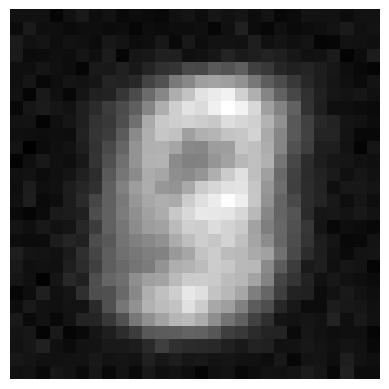

In [21]:
import matplotlib.pyplot as plt

img7 = model.generate_images(5, prior_std=0.001)
plt.imshow(img7.squeeze().cpu().numpy(), cmap='gray')
plt.axis('off')
plt.show()

In [22]:
fig, axes = plt.subplots(
    nrows=10,
    ncols=10,
    figsize=(10, 10),
    tight_layout=True
)

for digit in range(10):
    # make a batch of labels all equal to `digit`
    labels = torch.full(
        (10,),
        fill_value=digit,
        dtype=torch.long,
        device=model.device
    )
    # generate images; style_z=None → sampled inside with prior_std
    imgs = model.generate_images(labels, style_z=None, prior_std=PRIOR_STD)

    # plot each sample in its column
    for col in range(10):
        ax = axes[digit, col]
        img = imgs[col].squeeze().cpu().numpy()
        ax.imshow(img, cmap='gray')
        ax.axis('off')

# save to disk
fig.savefig(f'/home/franciszek-latala/VsCodeProjects/adversarial-autoencoders/src/adversarial_autoencoder/semisupervised_results/500_epochs_100_labeled_sgd_momentum_noise_030_run_2/fig_1', dpi=300, bbox_inches='tight')
plt.close(fig)

In [34]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Set grid range
n = 10  # grid size per axis
grid_range = 5.0  # range from -2 to 2

# Make meshgrid for style latent
style_grid_x = np.linspace(-grid_range, grid_range, n)
style_grid_y = np.linspace(-grid_range, grid_range, n)

fig, axes = plt.subplots(n, n, figsize=(10, 10), tight_layout=True)

digit = 4  # fix the digit you want to visualize, e.g. 0, or loop for all digits

# Prepare all latent style codes in advance for the grid
style_z = torch.zeros((n * n, model.options.latent_dim_style), device=model.device)
for i, sx in enumerate(style_grid_x):
    for j, sy in enumerate(style_grid_y):
        idx = i * n + j
        style_z[idx, 0] = sx  # first style dim
        style_z[idx, 1] = sy  # second style dim
        # if more style dims, leave them as 0

# All labels are digit
labels = torch.full((n * n,), fill_value=digit, dtype=torch.long, device=model.device)
imgs = model.generate_images(labels, style_z=style_z)

# Plot grid: i = row, j = col
for i in range(n):
    for j in range(n):
        ax = axes[i, j]
        idx = i * n + j
        img = imgs[idx].squeeze().cpu().numpy()
        ax.imshow(img, cmap='gray')
        ax.axis('off')

fig.savefig('fig_style_grid.png', dpi=300, bbox_inches='tight')
plt.close(fig)
